# Tree Canopy Segmentation with Detectron2

This notebook demonstrates how to train a Detectron2 model for tree canopy segmentation.

## 1. Install Dependencies

In [ ]:
# Install PyTorch and Detectron2 in Colab
!pip install -q torch torchvision torchaudio
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'
!pip install -q pycocotools


## 2. Data Download & Extraction

In [ ]:
# Step 1: Install dependencies (if needed)
import os
import zipfile
import requests
import json

# Step 2: Define dataset URLs
urls = {
    "train_annotations": "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/tree-canopy-detection/dataset/train_annotations.json",
    "train_images": "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/tree-canopy-detection/dataset/train_images.zip",
    "evaluation_images": "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/tree-canopy-detection/dataset/evaluation_images.zip",
    "sample_answer": "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/tree-canopy-detection/dataset/sample_answer.json",
}

# Step 3: Create data folder
os.makedirs("data", exist_ok=True)

# Step 4: Download files
def download_file(url, save_path):
    if not os.path.exists(save_path):
        print(f"Downloading {url} ...")
        r = requests.get(url, stream=True)
        with open(save_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    else:
        print(f"{save_path} already exists, skipping.")

download_file(urls["train_annotations"], "data/train_annotations.json")
download_file(urls["train_images"], "data/train_images.zip")
download_file(urls["evaluation_images"], "data/evaluation_images.zip")
download_file(urls["sample_answer"], "data/sample_answer.json")

# Step 5: Unzip image archives
def unzip_file(zip_path, extract_to):
    if os.path.exists(extract_to):
        print(f"{extract_to} already exists, skipping unzip.")
    else:
        print(f"Unzipping {zip_path} ...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

unzip_file("data/train_images.zip", "data/train_images")
unzip_file("data/evaluation_images.zip", "data/evaluation_images")

# Step 6: Quick checks
print("Train images:", len(os.listdir("data/train_images")))
print("Eval images:", len(os.listdir("data/evaluation_images")))

# Load annotations as JSON
with open("data/train_annotations.json", "r") as f:
    train_annotations = json.load(f)

print("Number of annotations:", len(train_annotations))
print("Sample keys:", list(train_annotations.keys())[:5])


Unzipping data/train_images.zip ...
Unzipping data/evaluation_images.zip ...
Train images: 151
Eval images: 151
Number of annotations: 1
Sample keys: ['images']


In [ ]:
urls = {
    "train_annotations.json": "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/tree-canopy-detection/dataset/train_annotations.json",
    "train_images.zip": "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/tree-canopy-detection/dataset/train_images.zip",
    "evaluation_images.zip": "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/tree-canopy-detection/dataset/evaluation_images.zip",
    "sample_answer.json": "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/tree-canopy-detection/dataset/sample_answer.json"
}

# Download each file
for filename, url in urls.items():
    if not os.path.exists(filename):
        print(f"⬇️ Downloading {filename}...")
        response = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(response.content)
    else:
        print(f"✅ {filename} already exists")

# ===============================
# 📦 STEP 3: Unzip Archives
# ===============================
def unzip_file(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Unzipped {zip_path} → {extract_to}")

# Unzip training and evaluation images
unzip_file("train_images.zip", "train_images")
unzip_file("evaluation_images.zip", "evaluation_images")

# ===============================
# 📄 STEP 4: Load JSON Files
# ===============================
with open('train_annotations.json', 'r') as f:
    train_data = json.load(f)

with open('sample_answer.json', 'r') as f:
    eval_data = json.load(f)

print(f"📊 Number of images in training data: {len(train_data['images'])}")
print(f"📊 Number of images in evaluation data: {len(eval_data['images'])}")



⬇️ Downloading train_annotations.json...
⬇️ Downloading train_images.zip...
⬇️ Downloading evaluation_images.zip...
⬇️ Downloading sample_answer.json...
✅ Unzipped train_images.zip → train_images
✅ Unzipped evaluation_images.zip → evaluation_images
📊 Number of images in training data: 150
📊 Number of images in evaluation data: 150


In [ ]:
import os, json, random, shutil
from pathlib import Path
import numpy as np
from pprint import pprint

# Paths (adjust if your files are in a subfolder)
ROOT = "/content"
DATA_ROOT = os.path.join(ROOT, "dataset")
os.makedirs(DATA_ROOT, exist_ok=True)

# Files expected in current Colab working dir
TRAIN_ZIP = os.path.join(ROOT, "train_images.zip")
EVAL_ZIP = os.path.join(ROOT, "evaluation_images.zip")
RAW_ANN = os.path.join(ROOT, "train_annotations.json")  # your annotation file
# output locations
IMG_DIR = os.path.join(DATA_ROOT, "images")
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, "train_images")
VAL_IMG_DIR = os.path.join(DATA_ROOT, "val_images")

# unzip if needed
import zipfile
if os.path.exists(TRAIN_ZIP):
    print("Unzipping train_images.zip ...")
    with zipfile.ZipFile(TRAIN_ZIP, 'r') as z:
        z.extractall(TRAIN_IMG_DIR)
if os.path.exists(EVAL_ZIP):
    print("Unzipping evaluation_images.zip ...")
    with zipfile.ZipFile(EVAL_ZIP, 'r') as z:
        z.extractall(os.path.join(DATA_ROOT, "evaluation_images"))

# helper: collect all image files
def collect_images(base):
    exts = (".jpg", ".jpeg", ".png", ".tif", ".tiff")
    files = []
    for root, _, filenames in os.walk(base):
        for f in filenames:
            if f.lower().endswith(exts):
                files.append(os.path.relpath(os.path.join(root, f), start=DATA_ROOT))
    return sorted(files)

print("Train image dir:", TRAIN_IMG_DIR, "exists?", os.path.exists(TRAIN_IMG_DIR))


Unzipping train_images.zip ...
Unzipping evaluation_images.zip ...
Train image dir: /content/dataset/train_images exists? True


## 3. Data Conversion (Custom to COCO)

Convert the custom annotation format to the standard COCO format required by Detectron2.

In [ ]:
# if your annotations already follow COCO format (top-level 'annotations' key), we use them directly.
# otherwise we assume the custom format you posted earlier and convert.

COCO_OUT_DIR = os.path.join(DATA_ROOT, "annotations")
os.makedirs(COCO_OUT_DIR, exist_ok=True)
COCO_TRAIN_JSON = os.path.join(COCO_OUT_DIR, "instances_train_coco.json")
COCO_VAL_JSON   = os.path.join(COCO_OUT_DIR, "instances_val_coco.json")
COCO_FULL_JSON  = os.path.join(COCO_OUT_DIR, "instances_full_coco.json")

def is_coco_format(d):
    return isinstance(d, dict) and "annotations" in d and "images" in d and "categories" in d

def convert_custom_to_coco(raw, images_base):
    # raw expected like your earlier message: {"images": [{file_name, width, height, annotations:[{class, segmentation, ...}]}]}
    categories = {}
    cats = []
    anns = []
    imgs = []
    ann_id = 1
    cat_id_counter = 1
    for i, img in enumerate(raw.get("images", [])):
        fname = img["file_name"]
        width = img.get("width")
        height = img.get("height")
        image_id = i+1
        imgs.append({"id": image_id, "file_name": fname, "width": width, "height": height})
        for a in img.get("annotations", []):
            cname = a.get("class", "unknown")
            if cname not in categories:
                categories[cname] = cat_id_counter
                cats.append({"id": cat_id_counter, "name": cname})
                cat_id_counter += 1
            seg = a.get("segmentation", [])
            # ensure segmentation is list of polygons
            if not seg:
                continue
            if isinstance(seg[0], list):
                segs = seg
            else:
                segs = [seg]
            # bbox from first polygon
            xs = segs[0][0::2]; ys = segs[0][1::2]
            x_min, y_min, x_max, y_max = min(xs), min(ys), max(xs), max(ys)
            bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
            # area via shoelace for the first poly
            area = 0
            px = xs; py = ys
            for t in range(len(px)):
                q = (t+1) % len(px)
                area += px[t]*py[q] - px[q]*py[t]
            area = abs(area) / 2.0
            anns.append({
                "id": ann_id,
                "image_id": image_id,
                "category_id": categories[cname],
                "segmentation": segs,
                "area": area,
                "bbox": bbox,
                "iscrowd": 0
            })
            ann_id += 1
    coco = {"images": imgs, "annotations": anns, "categories": cats}
    return coco

# Load raw JSON
with open(RAW_ANN, "r") as f:
    raw = json.load(f)

if is_coco_format(raw):
    print("Annotation file already in COCO format.")
    # write full copy
    with open(COCO_FULL_JSON, "w") as f:
        json.dump(raw, f)
    coco_full = raw
else:
    print("Converting custom format to COCO...")
    coco_full = convert_custom_to_coco(raw, TRAIN_IMG_DIR)
    with open(COCO_FULL_JSON, "w") as f:
        json.dump(coco_full, f)

print("Images found in annotation:", len(coco_full["images"]))
print("Annotations:", len(coco_full["annotations"]))
print("Categories:", coco_full["categories"])


Converting custom format to COCO...
Images found in annotation: 150
Annotations: 38912
Categories: [{'id': 1, 'name': 'individual_tree'}, {'id': 2, 'name': 'group_of_trees'}]


## 4. Dataset Splitting

In [ ]:
c# Split by images
imgs = coco_full["images"]
anns = coco_full["annotations"]
random.seed(42)
img_ids = [img["id"] for img in imgs]
random.shuffle(img_ids)
split = int(0.8 * len(img_ids))
train_ids = set(img_ids[:split])
val_ids = set(img_ids[split:])

def filter_coco(images, anns, keep_ids):
    imgs_f = [im for im in images if im["id"] in keep_ids]
    anns_f = [a for a in anns if a["image_id"] in keep_ids]
    return imgs_f, anns_f

train_imgs, train_anns = filter_coco(imgs, anns, train_ids)
val_imgs, val_anns = filter_coco(imgs, anns, val_ids)

cats = coco_full["categories"]

train_coco = {"images": train_imgs, "annotations": train_anns, "categories": cats}
val_coco   = {"images": val_imgs,   "annotations": val_anns,   "categories": cats}

with open(COCO_TRAIN_JSON, "w") as f:
    json.dump(train_coco, f)
with open(COCO_VAL_JSON, "w") as f:
    json.dump(val_coco, f)

print("Train images:", len(train_imgs), "Val images:", len(val_imgs))


Train images: 120 Val images: 30


## 5. Register Dataset in Detectron2


In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog

TRAIN_NAME = "tree_canopy_train_abs"
VAL_NAME = "tree_canopy_val_abs"

COCO_TRAIN_JSON = "/content/dataset/annotations/instances_train_coco_abs.json"
COCO_VAL_JSON   = "/content/dataset/annotations/instances_val_coco_abs.json"
TRAIN_IMG_DIR   = "/content/dataset"
VAL_IMG_DIR     = "/content/dataset"

# ✅ Correct registration
register_coco_instances(TRAIN_NAME, {}, COCO_TRAIN_JSON, TRAIN_IMG_DIR)
register_coco_instances(VAL_NAME, {}, COCO_VAL_JSON, VAL_IMG_DIR)

# Sanity check
print("Registered datasets:", list(MetadataCatalog.keys()))
print("Train Metadata:", MetadataCatalog.get(TRAIN_NAME))


Registered datasets: ['coco_2014_train', 'coco_2014_val', 'coco_2014_minival', 'coco_2014_valminusminival', 'coco_2017_train', 'coco_2017_val', 'coco_2017_test', 'coco_2017_test-dev', 'coco_2017_val_100', 'keypoints_coco_2014_train', 'keypoints_coco_2014_val', 'keypoints_coco_2014_minival', 'keypoints_coco_2014_valminusminival', 'keypoints_coco_2017_train', 'keypoints_coco_2017_val', 'keypoints_coco_2017_val_100', 'coco_2017_train_panoptic_separated', 'coco_2017_train_panoptic_stuffonly', 'coco_2017_train_panoptic', 'coco_2017_val_panoptic_separated', 'coco_2017_val_panoptic_stuffonly', 'coco_2017_val_panoptic', 'coco_2017_val_100_panoptic_separated', 'coco_2017_val_100_panoptic_stuffonly', 'coco_2017_val_100_panoptic', 'lvis_v1_train', 'lvis_v1_val', 'lvis_v1_test_dev', 'lvis_v1_test_challenge', 'lvis_v0.5_train', 'lvis_v0.5_val', 'lvis_v0.5_val_rand_100', 'lvis_v0.5_test', 'lvis_v0.5_train_cocofied', 'lvis_v0.5_val_cocofied', 'cityscapes_fine_instance_seg_train', 'cityscapes_fine_sem

## 6. Model Configuration & Training

In [ ]:
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (TRAIN_NAME,)
cfg.DATASETS.TEST = (VAL_NAME,)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2           # lower if GPU OOM
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000             # change larger for full training
cfg.SOLVER.STEPS = (2000, 2500)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(cats)

cfg.OUTPUT_DIR = os.path.join(DATA_ROOT, "detectron2_output")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


NameError: name 'TRAIN_NAME' is not defined

## 7. Inference & Visualization

In [ ]:
# Robust inference + debug cell for Detectron2 predictions & visualization
import os, sys, traceback, random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import importlib

from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog

# --- config checks ------------------------------------------------
print("CHECKS:")
print("  cfg.OUTPUT_DIR:", getattr(cfg, "OUTPUT_DIR", None))
weights_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
print("  expected weights:", weights_path, "exists?", os.path.exists(weights_path))
print("  cfg.MODEL.ROI_HEADS.NUM_CLASSES:", cfg.MODEL.ROI_HEADS.NUM_CLASSES)
print("  VAL dataset name:", VAL_NAME)
print("  #val entries:", len(DatasetCatalog.get(VAL_NAME)))

# utility: robust image reader
def read_image_robust(path):
    # try cv2
    img = None
    try:
        img = cv2.imread(path)
        if img is not None:
            return img
    except Exception as e:
        pass
    # try PIL
    try:
        pil = Image.open(path).convert("RGB")
        arr = np.array(pil)
        # convert RGB -> BGR for detectron2 (predictor expects BGR numpy image)
        return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
    except Exception as e:
        pass
    # try tifffile
    try:
        import tifffile
        arr = tifffile.imread(path)
        if arr is None:
            return None
        if arr.ndim == 2:
            arr = np.stack([arr]*3, axis=-1)
        if arr.shape[-1] == 4:
            arr = arr[..., :3]
        # assume arr is RGB
        return cv2.cvtColor(arr.astype("uint8"), cv2.COLOR_RGB2BGR)
    except Exception as e:
        return None

# Make predictor (ensure weights path exists)
if not os.path.exists(weights_path):
    print("ERROR: weights file not found at", weights_path)
    print("If training finished, check cfg.OUTPUT_DIR or the saved checkpoint name.")
else:
    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    predictor = DefaultPredictor(cfg)
    print("Predictor created. Device:", cfg.MODEL.DEVICE if hasattr(cfg.MODEL, "DEVICE") else "unknown")

# Visualize a few random validation images
dataset_dicts = DatasetCatalog.get(VAL_NAME)
meta = MetadataCatalog.get(VAL_NAME)
n_show = min(5, len(dataset_dicts))
samples = random.sample(dataset_dicts, n_show)

for idx, d in enumerate(samples):
    f = d["file_name"]
    # construct absolute path if file_name is relative
    if not os.path.isabs(f):
        img_path = os.path.join(DATA_ROOT, f)
    else:
        img_path = f
    print(f"\n[{idx+1}/{n_show}] file_name field: {f}")
    print("  abs path:", img_path)
    print("  exists?:", os.path.exists(img_path))
    if not os.path.exists(img_path):
        # try matching by basename search inside DATA_ROOT
        base = os.path.basename(f)
        print("  Attempting to locate by basename inside DATA_ROOT...")
        import glob
        matches = glob.glob(os.path.join(DATA_ROOT, "**", base), recursive=True)
        print("  matches found:", len(matches))
        if len(matches) == 1:
            img_path = matches[0]
            print("  Using found path:", img_path)
        elif len(matches) > 1:
            print("  Multiple matches found, using first:", matches[0])
            img_path = matches[0]
        else:
            print("  No matching file found; skipping this item.")
            continue

    # read image robustly
    im = read_image_robust(img_path)
    if im is None:
        print("  Failed to read image with cv2/PIL/tifffile. Skipping.")
        continue
    print("  image shape (H,W,C):", im.shape)

    # Run prediction with try/except and print full traceback on error
    try:
        outputs = predictor(im)
    except Exception as e:
        print("  ERROR while running predictor(im):")
        traceback.print_exc()
        # print common diagnostic hints
        print("\n  Common causes:")
        print("   - cfg.MODEL.ROI_HEADS.NUM_CLASSES mismatch vs weights")
        print("   - model weights corrupted")
        print("   - GPU OOM (check runtime logs) or CUDA/device mismatch")
        print("   - image channels or dtype unexpected (we convert to BGR uint8)")
        continue

    # check outputs
    if "instances" not in outputs:
        print("  No 'instances' in outputs:", outputs.keys())
        continue
    inst = outputs["instances"].to("cpu")
    n_inst = len(inst)
    print("  #instances predicted:", n_inst)
    if n_inst == 0:
        print("  No detections above score threshold. Try lowering cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST")
    # visualize predictions
    try:
        v = Visualizer(im[:, :, ::-1], metadata=meta, scale=1.0, instance_mode=ColorMode.IMAGE)
        out = v.draw_instance_predictions(inst)
        plt.figure(figsize=(10,10))
        plt.imshow(out.get_image()[:, :, ::-1])
        plt.axis("off")
        plt.show()
    except Exception as e:
        print("  ERROR during visualization:")
        traceback.print_exc()
        continue

print("\nDone.")


## 8. Generate Submission File


In [ ]:
import os, cv2, json
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog
from tqdm import tqdm

# Paths
EVAL_DIR = "/content/evaluation_images"
OUT_JSON_PATH = "/content/submission.json"
WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Load trained model
cfg.MODEL.WEIGHTS = WEIGHTS
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)


In [ ]:
from glob import glob
import numpy as np

image_paths = sorted(glob(os.path.join(EVAL_DIR, "*.*")))

results = {"images": []}

for img_path in tqdm(image_paths, desc="Running inference"):
    im = cv2.imread(img_path)
    if im is None:
        print("Skipping unreadable:", img_path)
        continue

    outputs = predictor(im)
    instances = outputs["instances"].to("cpu")

    file_name = os.path.basename(img_path)
    img_h, img_w = im.shape[:2]
    annotations = []

    # Loop over predicted instances
    for i in range(len(instances)):
        cls_id = int(instances.pred_classes[i])
        cls_name = MetadataCatalog.get(VAL_NAME).thing_classes[cls_id]
        score = float(instances.scores[i])
        mask = instances.pred_masks[i].numpy()

        # Convert binary mask to polygon (RLE/contours)
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            continue

        # Convert each contour to flat polygon list
        for contour in contours:
            if len(contour) < 3:
                continue
            poly = contour.flatten().tolist()

            annotations.append({
                "class": cls_name,
                "confidence_score": round(score, 4),
                "segmentation": poly
            })

    results["images"].append({
        "file_name": file_name,
        "width": img_w,
        "height": img_h,
        "annotations": annotations
    })

# Save JSON
with open(OUT_JSON_PATH, "w") as f:
    json.dump(results, f)

print("✅ Submission file saved at:", OUT_JSON_PATH)


In [ ]:
import json
with open(OUT_JSON_PATH) as f:
    data = json.load(f)

print(json.dumps(data["images"][0], indent=2)[:1000])  # show sample


## 5. Register Dataset in Detectron2


Looking for annotation files in: /content/dataset/annotations
Scanned 3 roots, found 2400 image files total.

Summary: matched=120, ambiguous=0, unmatched=0

Wrote remapped train JSON: /content/dataset/annotations/instances_train_coco_remapped.json
Remapped images: 120 annotations: 31899

Registered datasets: tree_canopy_train_remap , tree_canopy_val_remap
[10/23 19:54:10 d2.data.datasets.coco]: Loaded 120 images in COCO format from /content/dataset/annotations/instances_train_coco_remapped.json
Train images registered: 120
[10/23 19:54:11 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/dataset/annotations/instances_val_coco.json
Val images registered: 30
Classes: ['individual_tree', 'group_of_trees']
[10/23 19:54:11 d2.data.datasets.coco]: Loaded 120 images in COCO format from /content/dataset/annotations/instances_train_coco_remapped.json


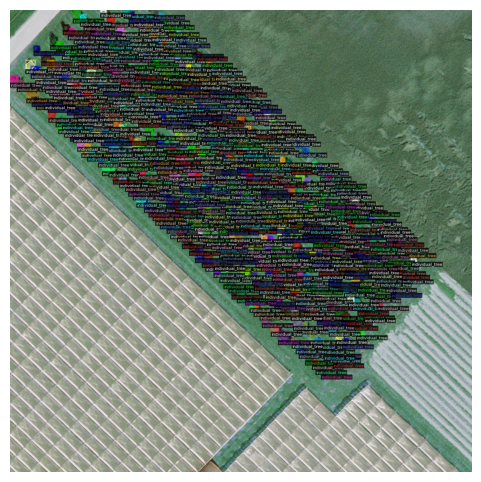

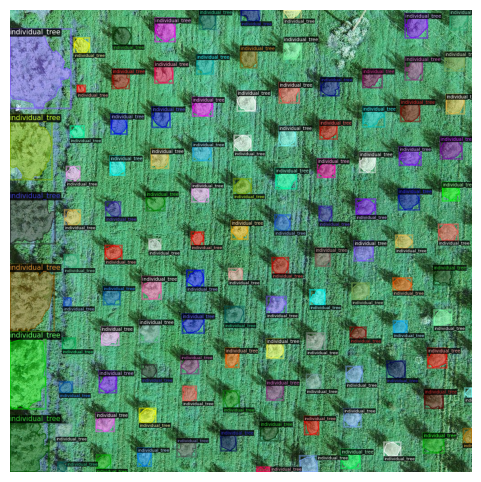


✅ All basenames matched. Use TRAIN_NAME = tree_canopy_train_remap in your cfg and start training.


In [ ]:
# === Auto-find image files (content + drive), remap COCO train JSON to absolute paths, re-register ===
import os, json, glob
from collections import defaultdict
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# ---------- Configure these paths ----------
DATA_ROOT = "/content/dataset"   # where your annotations live
ANN_DIR = os.path.join(DATA_ROOT, "annotations")
TRAIN_JSON = os.path.join(ANN_DIR, "instances_train_coco.json")
VAL_JSON   = os.path.join(ANN_DIR, "instances_val_coco.json")
OUT_TRAIN_JSON = os.path.join(ANN_DIR, "instances_train_coco_remapped.json")
TRAIN_DS_NAME = "tree_canopy_train_remap"
VAL_DS_NAME   = "tree_canopy_val_remap"
# ----------------------------------------------------------------

print("Looking for annotation files in:", ANN_DIR)
if not os.path.isdir(ANN_DIR):
    raise FileNotFoundError(f"Annotation dir not found: {ANN_DIR}. Put your COCO jsons under {ANN_DIR}")

# 1) locate image files under likely roots
search_roots = ["/content/dataset", "/content", "/content/drive"]  # add drive if mounted
exts = (".tif", ".tiff", ".png", ".jpg", ".jpeg", ".jp2")
found = []
for root in search_roots:
    if not os.path.exists(root):
        continue
    for r, dirs, files in os.walk(root):
        for fn in files:
            if fn.lower().endswith(exts):
                found.append(os.path.join(r, fn))

print(f"Scanned {len(search_roots)} roots, found {len(found)} image files total.")

# 2) create basename -> paths map
basename_map = defaultdict(list)
for p in found:
    basename_map[os.path.basename(p)].append(p)

# 3) load COCO train JSON
if not os.path.exists(TRAIN_JSON):
    raise FileNotFoundError(f"Train JSON not found: {TRAIN_JSON}")

with open(TRAIN_JSON, "r") as f:
    coco = json.load(f)

images = coco.get("images", [])
anns = coco.get("annotations", [])
categories = coco.get("categories", [])

matched = []
ambiguous = []
unmatched = []

new_images = []
for im in images:
    fname = im.get("file_name")
    base = os.path.basename(fname)
    cands = basename_map.get(base, [])
    chosen = None
    if len(cands) == 1:
        chosen = cands[0]
    elif len(cands) > 1:
        # prefer ones under DATA_ROOT
        pref = [c for c in cands if os.path.commonpath([os.path.abspath(c), os.path.abspath(DATA_ROOT)]) == os.path.abspath(DATA_ROOT)]
        if pref:
            chosen = pref[0]
        else:
            # pick shortest path as heuristic
            cands.sort(key=len)
            chosen = cands[0]
            ambiguous.append((base, cands))
    else:
        unmatched.append(base)

    if chosen:
        new_im = im.copy()
        new_im["file_name"] = os.path.abspath(chosen)
        new_images.append(new_im)
        matched.append((base, chosen))

print(f"\nSummary: matched={len(matched)}, ambiguous={len(ambiguous)}, unmatched={len(unmatched)}")

if len(matched) == 0:
    # nothing matched — common causes: images not uploaded, or inside zip not extracted, or wrong search_root
    print("\n⚠️ No images matched any COCO basenames. Possible causes:")
    print("  • You haven't uploaded the image files to Colab (upload them to /content or /content/dataset),")
    print("  • Images are in a zip / tar and not extracted,")
    print("  • Images are on Google Drive but Drive not mounted. To mount Drive, run:\n")
    print("    from google.colab import drive\n    drive.mount('/content/drive')\n")
    print("After placing/mounting your images, re-run this cell.")
    # show a sample of COCO basenames to help locate files locally
    print("\nSample basenames from JSON (first 30):")
    for b in [os.path.basename(i.get("file_name")) for i in images[:30]]:
        print(" -", b)
    raise RuntimeError("No images matched. Upload/mount images and re-run.")

# 4) report ambiguous and unmatched
if ambiguous:
    print("\nAmbiguous basename examples (basename -> candidates):")
    for b, cands in ambiguous[:6]:
        print(" -", b, "->", cands[:4])
if unmatched:
    print(f"\nUnmatched basenames: {len(unmatched)} (showing up to 30):")
    for u in unmatched[:30]:
        print(" -", u)

# 5) build remapped COCO JSON keeping same image ids for matched images
old_id_to_new = {}
for im in new_images:
    old_id_to_new[im["id"]] = im

# keep annotations whose image_id was remapped
new_annotations = [a for a in anns if a["image_id"] in old_id_to_new]
new_images_final = [old_id_to_new[iid] for iid in sorted(old_id_to_new.keys())]

coco_remapped = {
    "info": coco.get("info", {"description":"remapped"}),
    "licenses": coco.get("licenses", []),
    "images": new_images_final,
    "annotations": new_annotations,
    "categories": categories
}

with open(OUT_TRAIN_JSON, "w") as f:
    json.dump(coco_remapped, f)
print("\nWrote remapped train JSON:", OUT_TRAIN_JSON)
print("Remapped images:", len(new_images_final), "annotations:", len(new_annotations))

# 6) re-register cleaned dataset
DatasetCatalog.clear(); MetadataCatalog.clear()
register_coco_instances(TRAIN_DS_NAME, {}, OUT_TRAIN_JSON, image_root="")
# for val, keep as-is but try to use absolute if val JSON has relative paths (we keep image_root empty)
register_coco_instances(VAL_DS_NAME, {}, VAL_JSON, image_root="")

# ensure thing_classes set
if not MetadataCatalog.get(TRAIN_DS_NAME).get("thing_classes"):
    cats_list = [c["name"] for c in categories] or ["individual_tree","group_of_trees"]
    MetadataCatalog.get(TRAIN_DS_NAME).set(thing_classes=cats_list)
    MetadataCatalog.get(VAL_DS_NAME).set(thing_classes=cats_list)

print("\nRegistered datasets:", TRAIN_DS_NAME, ",", VAL_DS_NAME)
print("Train images registered:", len(DatasetCatalog.get(TRAIN_DS_NAME)))
print("Val images registered:", len(DatasetCatalog.get(VAL_DS_NAME)))
print("Classes:", MetadataCatalog.get(TRAIN_DS_NAME).thing_classes)

# 7) quick visual check for up to 2 images
try:
    import cv2, matplotlib.pyplot as plt
    from detectron2.utils.visualizer import Visualizer
    samples = DatasetCatalog.get(TRAIN_DS_NAME)[:2]
    if not samples:
        print("No samples available to display.")
    for d in samples:
        p = d["file_name"]
        img = cv2.imread(p)
        if img is None:
            print("Could not read remapped image:", p)
            continue
        v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(TRAIN_DS_NAME), scale=1.0)
        out = v.draw_dataset_dict(d)
        plt.figure(figsize=(6,6)); plt.imshow(out.get_image()[:, :, ::-1]); plt.axis("off"); plt.show()
except Exception as e:
    print("Visualization skipped (OpenCV/Visualizer error):", e)

# 8) next actions printed
if len(unmatched) == 0:
    print("\n✅ All basenames matched. Use TRAIN_NAME =", TRAIN_DS_NAME, "in your cfg and start training.")
else:
    print(f"\n⚠️ {len(unmatched)} basenames were not found. Inspect the printed list above.")
    print("Next steps:")
    print(" - If images are on Google Drive: mount it with\n       from google.colab import drive\n       drive.mount('/content/drive')\n   then re-run this cell.")
    print(" - If images are zipped: upload and extract them to /content/dataset (or mount Drive).\n - Or move/copy the missing files into /content/dataset and re-run this cell.")


## 5. Register Dataset in Detectron2


In [ ]:
# === TRAIN -> EVAL -> SUBMIT (single cell) ===
import os, json, random, time, cv2, numpy as np
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_train_loader, DatasetCatalog, MetadataCatalog
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine import DefaultPredictor

# ---------- Edit these if you used different names in the remap step ----------
TRAIN_NAME = "tree_canopy_train_remap"   # name created by remap cell
VAL_NAME   = "tree_canopy_val_remap"     # name created by remap cell
DATA_ROOT  = "/content/dataset"
OUTPUT_DIR = os.path.join(DATA_ROOT, "detectron2_output_final")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- Hyperparams you can tweak ----------
BACKBONE = "R_50"            # "R_50" or "R_101"
IMS_PER_BATCH = 1            # safe for Colab GPU
BASE_LR = 1e-4
MAX_ITER = 3000              # change to 8000 for longer training
STEPS = (2000, 2500)
SCORE_THRESH = 0.5

# ---------- simple augment mapper (robust reading + a few augments) ----------
def aug_mapper(dataset_dict):
    d = dataset_dict.copy()
    img_path = d["file_name"]
    if not os.path.isabs(img_path):
        img_path = os.path.join(DATA_ROOT, img_path)
    image = utils.read_image(img_path, format="BGR")
    aug_list = [
        T.ResizeShortestEdge(short_edge_length=(800, 1024), max_size=1600, sample_style='choice'),
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
        # small rotation may help:
        T.RandomRotation(angle=[-10,10]),
    ]
    aug_input = T.AugInput(image)
    transforms = T.AugmentationList(aug_list)(aug_input)
    image = aug_input.image
    d["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2,0,1)))
    annos = [utils.transform_instance_annotations(obj, transforms, image.shape[:2]) for obj in d.pop("annotations", [])]
    d["instances"] = utils.annotations_to_instances(annos, image.shape[:2])
    return d

# ---------- Custom trainer using aug_mapper ----------
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=aug_mapper)
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# ---------- Build config ----------
cfg = get_cfg()
cfg_file = f"COCO-InstanceSegmentation/mask_rcnn_{BACKBONE}_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(cfg_file))

cfg.DATASETS.TRAIN = (TRAIN_NAME,)
cfg.DATASETS.TEST  = (VAL_NAME,)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_file)  # start from COCO weights
cfg.SOLVER.IMS_PER_BATCH = IMS_PER_BATCH
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.SOLVER.STEPS = STEPS
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.AMP.ENABLED = True

cfg.INPUT.MIN_SIZE_TRAIN = (800, 1024)
cfg.INPUT.MAX_SIZE_TRAIN = 1600
cfg.INPUT.MIN_SIZE_TEST = 1024
cfg.INPUT.MAX_SIZE_TEST = 1600

# num classes from metadata
num_classes = len(MetadataCatalog.get(TRAIN_NAME).get("thing_classes", []))
if num_classes == 0:
    # try reading json categories
    annp = os.path.join(DATA_ROOT, "annotations")
    possible = [p for p in os.listdir(annp) if p.endswith(".json")]
    # fallback: set 2 classes (individual_tree, group_of_trees)
    num_classes = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

cfg.OUTPUT_DIR = OUTPUT_DIR
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

print("CONFIG SUMMARY")
print("TRAIN:", TRAIN_NAME, "VAL:", VAL_NAME)
print("OUTPUT_DIR:", cfg.OUTPUT_DIR)
print("NUM_CLASSES:", cfg.MODEL.ROI_HEADS.NUM_CLASSES)
print("IMS_PER_BATCH:", cfg.SOLVER.IMS_PER_BATCH, "MAX_ITER:", cfg.SOLVER.MAX_ITER)

# ---------- Start training ----------
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
print("\nStarting training... (Ctrl-C to stop early)\n")
trainer.train()

# ---------- After training: evaluate on validation ----------
print("\nTraining finished. Running evaluation on validation set...")
evaluator = COCOEvaluator(VAL_NAME, cfg, False, output_dir=os.path.join(cfg.OUTPUT_DIR, "eval"))
val_loader = build_detection_train_loader(cfg, mapper=None)  # wrong loader -> use test loader below
from detectron2.data import build_detection_test_loader
val_loader = build_detection_test_loader(cfg, VAL_NAME)
res = inference_on_dataset(trainer.model, val_loader, evaluator)
print("EVAL RESULTS:", json.dumps(res, indent=2))

# ---------- Build predictor for inference and create submission JSON ----------
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = SCORE_THRESH
predictor = DefaultPredictor(cfg)

# We'll generate predictions for the validation set (or change to test set if you have test images)
dataset_dicts = DatasetCatalog.get(VAL_NAME)
submission = {"images": []}
for d in dataset_dicts:
    img_path = d["file_name"]
    if not os.path.isabs(img_path):
        img_path = os.path.join(DATA_ROOT, img_path)
    im = cv2.imread(img_path)
    if im is None:
        print("WARN: could not read", img_path); continue
    outputs = predictor(im)
    instances = outputs["instances"].to("cpu")
    ann_list = []
    # convert masks -> polygons (simple contour on first mask)
    for i in range(len(instances)):
        score = float(instances.scores[i].item())
        mask = instances.pred_masks[i].numpy().astype("uint8") * 255
        # find contours and flatten first one
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        # pick the largest contour
        contour = max(contours, key=cv2.contourArea)
        poly = contour.flatten().tolist()
        if len(poly) < 6:
            continue
        ann_list.append({
            "class": "individual_tree",               # if multiple classes, map according to MetadataCatalog
            "confidence_score": score,
            "segmentation": poly
        })
    submission["images"].append({
        "file_name": os.path.basename(img_path),
        "width": int(im.shape[1]),
        "height": int(im.shape[0]),
        "scene_type": "unknown",
        "cm_resolution": 40,
        "annotations": ann_list
    })

SUB_OUT = os.path.join(DATA_ROOT, "submission_from_detectron2.json")
with open(SUB_OUT, "w") as f:
    json.dump(submission, f)
print("Submission written to:", SUB_OUT)

# ---------- Small visual check of a random prediction ----------
try:
    import random
    sample = random.choice(dataset_dicts)
    p = sample["file_name"] if os.path.isabs(sample["file_name"]) else os.path.join(DATA_ROOT, sample["file_name"])
    img = cv2.imread(p)
    out = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(VAL_NAME), scale=1.0, instance_mode=ColorMode.IMAGE)
    v = v.draw_instance_predictions(out["instances"].to("cpu"))
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,8)); plt.imshow(v.get_image()[:, :, ::-1]); plt.axis("off"); plt.show()
except Exception as e:
    print("Visual check failed:", e)

print("\nAll done. If you want to tune: change MAX_ITER, augmentations, backbone (R_101), or ROI_HEADS.BATCH_SIZE_PER_IMAGE.")


CONFIG SUMMARY
TRAIN: tree_canopy_train_remap VAL: tree_canopy_val_remap
OUTPUT_DIR: /content/dataset/detectron2_output_final
NUM_CLASSES: 2
IMS_PER_BATCH: 1 MAX_ITER: 3000
[10/23 19:56:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}



Starting training... (Ctrl-C to stop early)

[10/23 19:56:57 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-a

[10/23 19:57:08 d2.utils.events]:  eta: 0:13:43  iter: 19  total_loss: 5.672  loss_cls: 1.122  loss_box_reg: 0.2521  loss_mask: 0.6932  loss_rpn_cls: 3.186  loss_rpn_loc: 0.3885    time: 0.3224  last_time: 0.1451  data_time: 0.0286  last_data_time: 0.0006   lr: 3.8962e-06  max_mem: 6152M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:57:20 d2.utils.events]:  eta: 0:10:35  iter: 39  total_loss: 4.701  loss_cls: 1.114  loss_box_reg: 0.1705  loss_mask: 0.6918  loss_rpn_cls: 2.096  loss_rpn_loc: 0.6841    time: 0.2617  last_time: 0.1731  data_time: 0.0055  last_data_time: 0.0055   lr: 7.8922e-06  max_mem: 6152M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:57:23 d2.utils.events]:  eta: 0:09:25  iter: 59  total_loss: 3.188  loss_cls: 1.039  loss_box_reg: 0.2335  loss_mask: 0.689  loss_rpn_cls: 0.749  loss_rpn_loc: 0.4467    time: 0.2316  last_time: 0.1815  data_time: 0.0055  last_data_time: 0.0077   lr: 1.1888e-05  max_mem: 6152M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:57:29 d2.utils.events]:  eta: 0:10:06  iter: 79  total_loss: 2.881  loss_cls: 0.9521  loss_box_reg: 0.1675  loss_mask: 0.6847  loss_rpn_cls: 0.5491  loss_rpn_loc: 0.5095    time: 0.2383  last_time: 0.2124  data_time: 0.0089  last_data_time: 0.0012   lr: 1.5884e-05  max_mem: 8445M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:57:33 d2.utils.events]:  eta: 0:09:49  iter: 99  total_loss: 2.697  loss_cls: 0.8608  loss_box_reg: 0.3836  loss_mask: 0.6762  loss_rpn_cls: 0.3685  loss_rpn_loc: 0.4268    time: 0.2353  last_time: 0.7042  data_time: 0.0066  last_data_time: 0.0032   lr: 1.988e-05  max_mem: 8445M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:57:37 d2.utils.events]:  eta: 0:09:38  iter: 119  total_loss: 2.657  loss_cls: 0.7917  loss_box_reg: 0.2275  loss_mask: 0.6678  loss_rpn_cls: 0.4087  loss_rpn_loc: 0.3603    time: 0.2297  last_time: 0.1816  data_time: 0.0054  last_data_time: 0.0025   lr: 2.3876e-05  max_mem: 8445M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:57:41 d2.utils.events]:  eta: 0:09:34  iter: 139  total_loss: 2.53  loss_cls: 0.7447  loss_box_reg: 0.3132  loss_mask: 0.658  loss_rpn_cls: 0.3705  loss_rpn_loc: 0.399    time: 0.2263  last_time: 0.1780  data_time: 0.0056  last_data_time: 0.0009   lr: 2.7872e-05  max_mem: 8445M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:57:46 d2.utils.events]:  eta: 0:09:27  iter: 159  total_loss: 2.39  loss_cls: 0.6838  loss_box_reg: 0.2527  loss_mask: 0.6551  loss_rpn_cls: 0.3183  loss_rpn_loc: 0.4149    time: 0.2248  last_time: 0.3532  data_time: 0.0067  last_data_time: 0.0103   lr: 3.1868e-05  max_mem: 8445M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:57:49 d2.utils.events]:  eta: 0:09:17  iter: 179  total_loss: 2.369  loss_cls: 0.6588  loss_box_reg: 0.3468  loss_mask: 0.6429  loss_rpn_cls: 0.3302  loss_rpn_loc: 0.4673    time: 0.2203  last_time: 0.2225  data_time: 0.0059  last_data_time: 0.0033   lr: 3.5864e-05  max_mem: 8445M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:57:54 d2.utils.events]:  eta: 0:09:16  iter: 199  total_loss: 2.368  loss_cls: 0.6389  loss_box_reg: 0.296  loss_mask: 0.6304  loss_rpn_cls: 0.3077  loss_rpn_loc: 0.416    time: 0.2201  last_time: 0.2217  data_time: 0.0077  last_data_time: 0.0139   lr: 3.986e-05  max_mem: 8445M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:57:58 d2.utils.events]:  eta: 0:09:15  iter: 219  total_loss: 2.324  loss_cls: 0.6104  loss_box_reg: 0.2042  loss_mask: 0.6214  loss_rpn_cls: 0.3441  loss_rpn_loc: 0.473    time: 0.2211  last_time: 0.1470  data_time: 0.0060  last_data_time: 0.0012   lr: 4.3856e-05  max_mem: 8445M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:03 d2.utils.events]:  eta: 0:09:17  iter: 239  total_loss: 2.233  loss_cls: 0.6054  loss_box_reg: 0.302  loss_mask: 0.6001  loss_rpn_cls: 0.2928  loss_rpn_loc: 0.4529    time: 0.2217  last_time: 0.2413  data_time: 0.0076  last_data_time: 0.0072   lr: 4.7852e-05  max_mem: 8445M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:08 d2.utils.events]:  eta: 0:09:17  iter: 259  total_loss: 2.215  loss_cls: 0.5996  loss_box_reg: 0.1889  loss_mask: 0.5897  loss_rpn_cls: 0.3414  loss_rpn_loc: 0.4916    time: 0.2245  last_time: 0.2437  data_time: 0.0089  last_data_time: 0.0061   lr: 5.1848e-05  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:12 d2.utils.events]:  eta: 0:09:04  iter: 279  total_loss: 2.161  loss_cls: 0.5829  loss_box_reg: 0.3933  loss_mask: 0.5656  loss_rpn_cls: 0.3278  loss_rpn_loc: 0.3962    time: 0.2221  last_time: 0.1988  data_time: 0.0051  last_data_time: 0.0045   lr: 5.5844e-05  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:16 d2.utils.events]:  eta: 0:08:58  iter: 299  total_loss: 2.149  loss_cls: 0.5658  loss_box_reg: 0.6035  loss_mask: 0.5655  loss_rpn_cls: 0.1883  loss_rpn_loc: 0.2014    time: 0.2197  last_time: 0.1954  data_time: 0.0057  last_data_time: 0.0034   lr: 5.984e-05  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:20 d2.utils.events]:  eta: 0:08:55  iter: 319  total_loss: 2.159  loss_cls: 0.5683  loss_box_reg: 0.371  loss_mask: 0.5313  loss_rpn_cls: 0.296  loss_rpn_loc: 0.3864    time: 0.2193  last_time: 0.1467  data_time: 0.0058  last_data_time: 0.0041   lr: 6.3836e-05  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:24 d2.utils.events]:  eta: 0:08:51  iter: 339  total_loss: 2.188  loss_cls: 0.5688  loss_box_reg: 0.2206  loss_mask: 0.5375  loss_rpn_cls: 0.3465  loss_rpn_loc: 0.4725    time: 0.2185  last_time: 0.3232  data_time: 0.0061  last_data_time: 0.0127   lr: 6.7832e-05  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:28 d2.utils.events]:  eta: 0:08:45  iter: 359  total_loss: 2.125  loss_cls: 0.564  loss_box_reg: 0.3023  loss_mask: 0.4975  loss_rpn_cls: 0.3392  loss_rpn_loc: 0.4015    time: 0.2171  last_time: 0.1917  data_time: 0.0056  last_data_time: 0.0058   lr: 7.1828e-05  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:33 d2.utils.events]:  eta: 0:08:43  iter: 379  total_loss: 2.114  loss_cls: 0.5383  loss_box_reg: 0.3266  loss_mask: 0.4807  loss_rpn_cls: 0.3447  loss_rpn_loc: 0.4563    time: 0.2180  last_time: 0.2093  data_time: 0.0084  last_data_time: 0.0131   lr: 7.5824e-05  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:37 d2.utils.events]:  eta: 0:08:40  iter: 399  total_loss: 1.931  loss_cls: 0.5216  loss_box_reg: 0.2873  loss_mask: 0.4516  loss_rpn_cls: 0.3064  loss_rpn_loc: 0.4071    time: 0.2183  last_time: 0.2161  data_time: 0.0068  last_data_time: 0.0052   lr: 7.982e-05  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:41 d2.utils.events]:  eta: 0:08:39  iter: 419  total_loss: 2.042  loss_cls: 0.5136  loss_box_reg: 0.3645  loss_mask: 0.4559  loss_rpn_cls: 0.2886  loss_rpn_loc: 0.4021    time: 0.2179  last_time: 0.2389  data_time: 0.0056  last_data_time: 0.0014   lr: 8.3816e-05  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:46 d2.utils.events]:  eta: 0:08:35  iter: 439  total_loss: 1.885  loss_cls: 0.4934  loss_box_reg: 0.3504  loss_mask: 0.4237  loss_rpn_cls: 0.3029  loss_rpn_loc: 0.2928    time: 0.2175  last_time: 0.1338  data_time: 0.0059  last_data_time: 0.0012   lr: 8.7812e-05  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:49 d2.utils.events]:  eta: 0:08:27  iter: 459  total_loss: 1.977  loss_cls: 0.5339  loss_box_reg: 0.4813  loss_mask: 0.4198  loss_rpn_cls: 0.271  loss_rpn_loc: 0.3248    time: 0.2165  last_time: 0.2017  data_time: 0.0057  last_data_time: 0.0010   lr: 9.1808e-05  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:54 d2.utils.events]:  eta: 0:08:23  iter: 479  total_loss: 1.942  loss_cls: 0.4816  loss_box_reg: 0.3625  loss_mask: 0.4071  loss_rpn_cls: 0.2877  loss_rpn_loc: 0.414    time: 0.2165  last_time: 0.2873  data_time: 0.0062  last_data_time: 0.0103   lr: 9.5804e-05  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:58:59 d2.utils.events]:  eta: 0:08:24  iter: 499  total_loss: 1.819  loss_cls: 0.4751  loss_box_reg: 0.2456  loss_mask: 0.3954  loss_rpn_cls: 0.2934  loss_rpn_loc: 0.3814    time: 0.2184  last_time: 0.1415  data_time: 0.0101  last_data_time: 0.0012   lr: 9.98e-05  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:03 d2.utils.events]:  eta: 0:08:17  iter: 519  total_loss: 2.007  loss_cls: 0.4978  loss_box_reg: 0.4659  loss_mask: 0.3978  loss_rpn_cls: 0.266  loss_rpn_loc: 0.3531    time: 0.2174  last_time: 0.2588  data_time: 0.0049  last_data_time: 0.0076   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:07 d2.utils.events]:  eta: 0:08:12  iter: 539  total_loss: 1.937  loss_cls: 0.4522  loss_box_reg: 0.5308  loss_mask: 0.3757  loss_rpn_cls: 0.2535  loss_rpn_loc: 0.2711    time: 0.2168  last_time: 0.2965  data_time: 0.0045  last_data_time: 0.0085   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:12 d2.utils.events]:  eta: 0:08:12  iter: 559  total_loss: 1.874  loss_cls: 0.4651  loss_box_reg: 0.3959  loss_mask: 0.3788  loss_rpn_cls: 0.3008  loss_rpn_loc: 0.3987    time: 0.2175  last_time: 0.1828  data_time: 0.0081  last_data_time: 0.0031   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:16 d2.utils.events]:  eta: 0:08:05  iter: 579  total_loss: 1.906  loss_cls: 0.4709  loss_box_reg: 0.3401  loss_mask: 0.382  loss_rpn_cls: 0.306  loss_rpn_loc: 0.3919    time: 0.2167  last_time: 0.1276  data_time: 0.0056  last_data_time: 0.0010   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:20 d2.utils.events]:  eta: 0:08:00  iter: 599  total_loss: 1.899  loss_cls: 0.4977  loss_box_reg: 0.3394  loss_mask: 0.3777  loss_rpn_cls: 0.2755  loss_rpn_loc: 0.4052    time: 0.2167  last_time: 0.4251  data_time: 0.0077  last_data_time: 0.0215   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:25 d2.utils.events]:  eta: 0:07:57  iter: 619  total_loss: 1.881  loss_cls: 0.4495  loss_box_reg: 0.3177  loss_mask: 0.3589  loss_rpn_cls: 0.258  loss_rpn_loc: 0.4435    time: 0.2172  last_time: 0.2177  data_time: 0.0085  last_data_time: 0.0032   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:28 d2.utils.events]:  eta: 0:07:51  iter: 639  total_loss: 1.875  loss_cls: 0.4804  loss_box_reg: 0.444  loss_mask: 0.3673  loss_rpn_cls: 0.2392  loss_rpn_loc: 0.2949    time: 0.2163  last_time: 0.2584  data_time: 0.0055  last_data_time: 0.0040   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:33 d2.utils.events]:  eta: 0:07:47  iter: 659  total_loss: 1.695  loss_cls: 0.4258  loss_box_reg: 0.5055  loss_mask: 0.377  loss_rpn_cls: 0.1818  loss_rpn_loc: 0.2857    time: 0.2159  last_time: 0.3207  data_time: 0.0083  last_data_time: 0.0533   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:37 d2.utils.events]:  eta: 0:07:43  iter: 679  total_loss: 1.818  loss_cls: 0.4502  loss_box_reg: 0.3857  loss_mask: 0.3771  loss_rpn_cls: 0.2873  loss_rpn_loc: 0.3714    time: 0.2161  last_time: 0.1964  data_time: 0.0085  last_data_time: 0.0030   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:41 d2.utils.events]:  eta: 0:07:40  iter: 699  total_loss: 1.845  loss_cls: 0.4521  loss_box_reg: 0.2911  loss_mask: 0.3689  loss_rpn_cls: 0.3065  loss_rpn_loc: 0.3927    time: 0.2163  last_time: 0.2243  data_time: 0.0065  last_data_time: 0.0113   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:46 d2.utils.events]:  eta: 0:07:36  iter: 719  total_loss: 1.816  loss_cls: 0.4763  loss_box_reg: 0.3707  loss_mask: 0.3691  loss_rpn_cls: 0.2557  loss_rpn_loc: 0.3584    time: 0.2163  last_time: 0.2609  data_time: 0.0072  last_data_time: 0.0126   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:50 d2.utils.events]:  eta: 0:07:32  iter: 739  total_loss: 1.862  loss_cls: 0.4389  loss_box_reg: 0.4732  loss_mask: 0.3971  loss_rpn_cls: 0.2245  loss_rpn_loc: 0.3133    time: 0.2157  last_time: 0.1593  data_time: 0.0048  last_data_time: 0.0037   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:53 d2.utils.events]:  eta: 0:07:27  iter: 759  total_loss: 1.85  loss_cls: 0.448  loss_box_reg: 0.3817  loss_mask: 0.3476  loss_rpn_cls: 0.2793  loss_rpn_loc: 0.338    time: 0.2149  last_time: 0.1839  data_time: 0.0052  last_data_time: 0.0088   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 19:59:58 d2.utils.events]:  eta: 0:07:23  iter: 779  total_loss: 1.841  loss_cls: 0.4767  loss_box_reg: 0.4026  loss_mask: 0.3738  loss_rpn_cls: 0.2352  loss_rpn_loc: 0.3827    time: 0.2148  last_time: 0.2829  data_time: 0.0058  last_data_time: 0.0105   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:03 d2.utils.events]:  eta: 0:07:20  iter: 799  total_loss: 1.895  loss_cls: 0.462  loss_box_reg: 0.4823  loss_mask: 0.3624  loss_rpn_cls: 0.2563  loss_rpn_loc: 0.3938    time: 0.2156  last_time: 0.1401  data_time: 0.0077  last_data_time: 0.0012   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:07 d2.utils.events]:  eta: 0:07:16  iter: 819  total_loss: 1.88  loss_cls: 0.4722  loss_box_reg: 0.2895  loss_mask: 0.3519  loss_rpn_cls: 0.2961  loss_rpn_loc: 0.4286    time: 0.2158  last_time: 0.1948  data_time: 0.0064  last_data_time: 0.0088   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:12 d2.utils.events]:  eta: 0:07:13  iter: 839  total_loss: 1.847  loss_cls: 0.4708  loss_box_reg: 0.4099  loss_mask: 0.3669  loss_rpn_cls: 0.2351  loss_rpn_loc: 0.3023    time: 0.2161  last_time: 0.2656  data_time: 0.0062  last_data_time: 0.0028   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:16 d2.utils.events]:  eta: 0:07:10  iter: 859  total_loss: 1.938  loss_cls: 0.4729  loss_box_reg: 0.3455  loss_mask: 0.3686  loss_rpn_cls: 0.2906  loss_rpn_loc: 0.3929    time: 0.2160  last_time: 0.1776  data_time: 0.0068  last_data_time: 0.0041   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:20 d2.utils.events]:  eta: 0:07:05  iter: 879  total_loss: 1.717  loss_cls: 0.3643  loss_box_reg: 0.493  loss_mask: 0.3587  loss_rpn_cls: 0.2118  loss_rpn_loc: 0.2619    time: 0.2156  last_time: 0.1694  data_time: 0.0060  last_data_time: 0.0045   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:26 d2.utils.events]:  eta: 0:07:01  iter: 899  total_loss: 1.907  loss_cls: 0.4535  loss_box_reg: 0.4665  loss_mask: 0.3623  loss_rpn_cls: 0.243  loss_rpn_loc: 0.3543    time: 0.2172  last_time: 0.1316  data_time: 0.0114  last_data_time: 0.0033   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:30 d2.utils.events]:  eta: 0:06:57  iter: 919  total_loss: 1.747  loss_cls: 0.4397  loss_box_reg: 0.4192  loss_mask: 0.3282  loss_rpn_cls: 0.2507  loss_rpn_loc: 0.3527    time: 0.2171  last_time: 0.2404  data_time: 0.0063  last_data_time: 0.0070   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:34 d2.utils.events]:  eta: 0:06:52  iter: 939  total_loss: 1.793  loss_cls: 0.4711  loss_box_reg: 0.4933  loss_mask: 0.3607  loss_rpn_cls: 0.2093  loss_rpn_loc: 0.2664    time: 0.2167  last_time: 0.1858  data_time: 0.0051  last_data_time: 0.0084   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:39 d2.utils.events]:  eta: 0:06:49  iter: 959  total_loss: 1.821  loss_cls: 0.4636  loss_box_reg: 0.3926  loss_mask: 0.3523  loss_rpn_cls: 0.2538  loss_rpn_loc: 0.4279    time: 0.2174  last_time: 0.2489  data_time: 0.0088  last_data_time: 0.0148   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:43 d2.utils.events]:  eta: 0:06:45  iter: 979  total_loss: 1.903  loss_cls: 0.4109  loss_box_reg: 0.4135  loss_mask: 0.3528  loss_rpn_cls: 0.2582  loss_rpn_loc: 0.3588    time: 0.2170  last_time: 0.2294  data_time: 0.0047  last_data_time: 0.0037   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:47 d2.utils.events]:  eta: 0:06:40  iter: 999  total_loss: 1.81  loss_cls: 0.4555  loss_box_reg: 0.4499  loss_mask: 0.3681  loss_rpn_cls: 0.3029  loss_rpn_loc: 0.3585    time: 0.2167  last_time: 0.1838  data_time: 0.0056  last_data_time: 0.0008   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:52 d2.utils.events]:  eta: 0:06:37  iter: 1019  total_loss: 1.92  loss_cls: 0.4959  loss_box_reg: 0.3855  loss_mask: 0.3544  loss_rpn_cls: 0.2369  loss_rpn_loc: 0.4239    time: 0.2173  last_time: 0.1909  data_time: 0.0097  last_data_time: 0.0039   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:56 d2.utils.events]:  eta: 0:06:32  iter: 1039  total_loss: 1.781  loss_cls: 0.4139  loss_box_reg: 0.4499  loss_mask: 0.354  loss_rpn_cls: 0.1447  loss_rpn_loc: 0.1848    time: 0.2167  last_time: 0.1522  data_time: 0.0055  last_data_time: 0.0034   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:00:59 d2.utils.events]:  eta: 0:06:29  iter: 1059  total_loss: 1.957  loss_cls: 0.4686  loss_box_reg: 0.4022  loss_mask: 0.3723  loss_rpn_cls: 0.2587  loss_rpn_loc: 0.3544    time: 0.2161  last_time: 0.1697  data_time: 0.0046  last_data_time: 0.0032   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:04 d2.utils.events]:  eta: 0:06:25  iter: 1079  total_loss: 1.742  loss_cls: 0.4398  loss_box_reg: 0.4498  loss_mask: 0.3242  loss_rpn_cls: 0.2047  loss_rpn_loc: 0.3449    time: 0.2167  last_time: 0.1941  data_time: 0.0089  last_data_time: 0.0031   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:08 d2.utils.events]:  eta: 0:06:19  iter: 1099  total_loss: 1.85  loss_cls: 0.4247  loss_box_reg: 0.4394  loss_mask: 0.3468  loss_rpn_cls: 0.2164  loss_rpn_loc: 0.3899    time: 0.2163  last_time: 0.1880  data_time: 0.0054  last_data_time: 0.0091   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:12 d2.utils.events]:  eta: 0:06:15  iter: 1119  total_loss: 1.879  loss_cls: 0.4783  loss_box_reg: 0.4579  loss_mask: 0.3705  loss_rpn_cls: 0.2353  loss_rpn_loc: 0.3471    time: 0.2159  last_time: 0.2136  data_time: 0.0050  last_data_time: 0.0016   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:17 d2.utils.events]:  eta: 0:06:13  iter: 1139  total_loss: 1.74  loss_cls: 0.3775  loss_box_reg: 0.3953  loss_mask: 0.3435  loss_rpn_cls: 0.2421  loss_rpn_loc: 0.319    time: 0.2163  last_time: 0.1608  data_time: 0.0078  last_data_time: 0.0040   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:21 d2.utils.events]:  eta: 0:06:09  iter: 1159  total_loss: 1.836  loss_cls: 0.4656  loss_box_reg: 0.3446  loss_mask: 0.3652  loss_rpn_cls: 0.2976  loss_rpn_loc: 0.4019    time: 0.2161  last_time: 0.1938  data_time: 0.0063  last_data_time: 0.0065   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:25 d2.utils.events]:  eta: 0:06:05  iter: 1179  total_loss: 1.842  loss_cls: 0.4529  loss_box_reg: 0.3941  loss_mask: 0.3551  loss_rpn_cls: 0.2211  loss_rpn_loc: 0.3742    time: 0.2158  last_time: 0.2004  data_time: 0.0050  last_data_time: 0.0087   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:30 d2.utils.events]:  eta: 0:06:01  iter: 1199  total_loss: 1.773  loss_cls: 0.4715  loss_box_reg: 0.4692  loss_mask: 0.3531  loss_rpn_cls: 0.2322  loss_rpn_loc: 0.2852    time: 0.2160  last_time: 0.1483  data_time: 0.0080  last_data_time: 0.0052   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:34 d2.utils.events]:  eta: 0:05:57  iter: 1219  total_loss: 1.696  loss_cls: 0.4036  loss_box_reg: 0.3934  loss_mask: 0.3323  loss_rpn_cls: 0.2216  loss_rpn_loc: 0.3103    time: 0.2159  last_time: 0.2856  data_time: 0.0061  last_data_time: 0.0062   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:38 d2.utils.events]:  eta: 0:05:51  iter: 1239  total_loss: 1.788  loss_cls: 0.3984  loss_box_reg: 0.4009  loss_mask: 0.3554  loss_rpn_cls: 0.1728  loss_rpn_loc: 0.3509    time: 0.2155  last_time: 0.1355  data_time: 0.0048  last_data_time: 0.0033   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:42 d2.utils.events]:  eta: 0:05:47  iter: 1259  total_loss: 1.785  loss_cls: 0.4288  loss_box_reg: 0.4585  loss_mask: 0.3453  loss_rpn_cls: 0.2174  loss_rpn_loc: 0.298    time: 0.2158  last_time: 0.1705  data_time: 0.0076  last_data_time: 0.0013   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:46 d2.utils.events]:  eta: 0:05:43  iter: 1279  total_loss: 1.935  loss_cls: 0.4938  loss_box_reg: 0.3776  loss_mask: 0.362  loss_rpn_cls: 0.3001  loss_rpn_loc: 0.4489    time: 0.2156  last_time: 0.1605  data_time: 0.0054  last_data_time: 0.0009   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:50 d2.utils.events]:  eta: 0:05:40  iter: 1299  total_loss: 1.898  loss_cls: 0.4761  loss_box_reg: 0.3715  loss_mask: 0.3584  loss_rpn_cls: 0.2307  loss_rpn_loc: 0.4103    time: 0.2153  last_time: 0.1490  data_time: 0.0053  last_data_time: 0.0014   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:55 d2.utils.events]:  eta: 0:05:35  iter: 1319  total_loss: 1.661  loss_cls: 0.4179  loss_box_reg: 0.4834  loss_mask: 0.3478  loss_rpn_cls: 0.1333  loss_rpn_loc: 0.1751    time: 0.2158  last_time: 0.1805  data_time: 0.0084  last_data_time: 0.0030   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:01:59 d2.utils.events]:  eta: 0:05:30  iter: 1339  total_loss: 1.852  loss_cls: 0.4479  loss_box_reg: 0.3974  loss_mask: 0.3526  loss_rpn_cls: 0.2022  loss_rpn_loc: 0.2643    time: 0.2153  last_time: 0.2405  data_time: 0.0051  last_data_time: 0.0039   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:02:03 d2.utils.events]:  eta: 0:05:27  iter: 1359  total_loss: 1.657  loss_cls: 0.4077  loss_box_reg: 0.4042  loss_mask: 0.3402  loss_rpn_cls: 0.1943  loss_rpn_loc: 0.311    time: 0.2151  last_time: 0.1963  data_time: 0.0056  last_data_time: 0.0062   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:02:08 d2.utils.events]:  eta: 0:05:22  iter: 1379  total_loss: 1.852  loss_cls: 0.4381  loss_box_reg: 0.4196  loss_mask: 0.3537  loss_rpn_cls: 0.2955  loss_rpn_loc: 0.3667    time: 0.2153  last_time: 0.2531  data_time: 0.0085  last_data_time: 0.0107   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:02:12 d2.utils.events]:  eta: 0:05:18  iter: 1399  total_loss: 1.655  loss_cls: 0.3894  loss_box_reg: 0.3612  loss_mask: 0.329  loss_rpn_cls: 0.2321  loss_rpn_loc: 0.3325    time: 0.2153  last_time: 0.2138  data_time: 0.0066  last_data_time: 0.0112   lr: 0.0001  max_mem: 8889M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:02:16 d2.utils.events]:  eta: 0:05:15  iter: 1419  total_loss: 1.856  loss_cls: 0.4451  loss_box_reg: 0.3656  loss_mask: 0.3381  loss_rpn_cls: 0.2723  loss_rpn_loc: 0.4165    time: 0.2154  last_time: 0.2382  data_time: 0.0056  last_data_time: 0.0066   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:02:21 d2.utils.events]:  eta: 0:05:12  iter: 1439  total_loss: 1.807  loss_cls: 0.4262  loss_box_reg: 0.3973  loss_mask: 0.3588  loss_rpn_cls: 0.2335  loss_rpn_loc: 0.3788    time: 0.2156  last_time: 0.2031  data_time: 0.0081  last_data_time: 0.0030   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:02:25 d2.utils.events]:  eta: 0:05:08  iter: 1459  total_loss: 1.732  loss_cls: 0.4126  loss_box_reg: 0.3286  loss_mask: 0.3456  loss_rpn_cls: 0.2402  loss_rpn_loc: 0.3677    time: 0.2155  last_time: 0.2785  data_time: 0.0054  last_data_time: 0.0051   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:02:29 d2.utils.events]:  eta: 0:05:04  iter: 1479  total_loss: 1.742  loss_cls: 0.4237  loss_box_reg: 0.4416  loss_mask: 0.3476  loss_rpn_cls: 0.1787  loss_rpn_loc: 0.2952    time: 0.2154  last_time: 0.1506  data_time: 0.0051  last_data_time: 0.0014   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:02:34 d2.utils.events]:  eta: 0:04:58  iter: 1499  total_loss: 1.56  loss_cls: 0.4122  loss_box_reg: 0.4116  loss_mask: 0.3366  loss_rpn_cls: 0.148  loss_rpn_loc: 0.2171    time: 0.2153  last_time: 0.1710  data_time: 0.0069  last_data_time: 0.0078   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:02:38 d2.utils.events]:  eta: 0:04:55  iter: 1519  total_loss: 1.881  loss_cls: 0.4563  loss_box_reg: 0.4241  loss_mask: 0.3625  loss_rpn_cls: 0.2423  loss_rpn_loc: 0.3824    time: 0.2153  last_time: 0.1886  data_time: 0.0067  last_data_time: 0.0050   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:02:42 d2.utils.events]:  eta: 0:04:50  iter: 1539  total_loss: 1.841  loss_cls: 0.4611  loss_box_reg: 0.4532  loss_mask: 0.3341  loss_rpn_cls: 0.2149  loss_rpn_loc: 0.3148    time: 0.2150  last_time: 0.1897  data_time: 0.0055  last_data_time: 0.0035   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:02:46 d2.utils.events]:  eta: 0:04:46  iter: 1559  total_loss: 1.793  loss_cls: 0.4673  loss_box_reg: 0.3026  loss_mask: 0.3548  loss_rpn_cls: 0.256  loss_rpn_loc: 0.426    time: 0.2152  last_time: 0.1654  data_time: 0.0090  last_data_time: 0.0065   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:02:51 d2.utils.events]:  eta: 0:04:43  iter: 1579  total_loss: 1.824  loss_cls: 0.4234  loss_box_reg: 0.3951  loss_mask: 0.3462  loss_rpn_cls: 0.1934  loss_rpn_loc: 0.2971    time: 0.2155  last_time: 0.3024  data_time: 0.0062  last_data_time: 0.0146   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:02:55 d2.utils.events]:  eta: 0:04:40  iter: 1599  total_loss: 1.824  loss_cls: 0.4404  loss_box_reg: 0.3791  loss_mask: 0.3575  loss_rpn_cls: 0.2456  loss_rpn_loc: 0.3603    time: 0.2154  last_time: 0.2479  data_time: 0.0060  last_data_time: 0.0087   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:00 d2.utils.events]:  eta: 0:04:36  iter: 1619  total_loss: 1.878  loss_cls: 0.4846  loss_box_reg: 0.4165  loss_mask: 0.3646  loss_rpn_cls: 0.2236  loss_rpn_loc: 0.403    time: 0.2158  last_time: 0.1947  data_time: 0.0099  last_data_time: 0.0031   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:04 d2.utils.events]:  eta: 0:04:32  iter: 1639  total_loss: 1.719  loss_cls: 0.4285  loss_box_reg: 0.4405  loss_mask: 0.3333  loss_rpn_cls: 0.1804  loss_rpn_loc: 0.2811    time: 0.2155  last_time: 0.2702  data_time: 0.0063  last_data_time: 0.0174   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:08 d2.utils.events]:  eta: 0:04:28  iter: 1659  total_loss: 1.84  loss_cls: 0.4727  loss_box_reg: 0.4525  loss_mask: 0.3519  loss_rpn_cls: 0.1903  loss_rpn_loc: 0.33    time: 0.2151  last_time: 0.1517  data_time: 0.0045  last_data_time: 0.0007   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:13 d2.utils.events]:  eta: 0:04:24  iter: 1679  total_loss: 1.795  loss_cls: 0.4186  loss_box_reg: 0.349  loss_mask: 0.349  loss_rpn_cls: 0.242  loss_rpn_loc: 0.4071    time: 0.2154  last_time: 0.2566  data_time: 0.0087  last_data_time: 0.0045   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:16 d2.utils.events]:  eta: 0:04:19  iter: 1699  total_loss: 1.669  loss_cls: 0.4051  loss_box_reg: 0.4092  loss_mask: 0.3358  loss_rpn_cls: 0.1715  loss_rpn_loc: 0.2099    time: 0.2151  last_time: 0.1625  data_time: 0.0059  last_data_time: 0.0177   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:20 d2.utils.events]:  eta: 0:04:15  iter: 1719  total_loss: 1.79  loss_cls: 0.4061  loss_box_reg: 0.3971  loss_mask: 0.3593  loss_rpn_cls: 0.2566  loss_rpn_loc: 0.4222    time: 0.2149  last_time: 0.2211  data_time: 0.0054  last_data_time: 0.0034   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:25 d2.utils.events]:  eta: 0:04:11  iter: 1739  total_loss: 1.794  loss_cls: 0.4093  loss_box_reg: 0.3444  loss_mask: 0.3484  loss_rpn_cls: 0.1875  loss_rpn_loc: 0.3089    time: 0.2152  last_time: 0.2909  data_time: 0.0098  last_data_time: 0.0102   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:30 d2.utils.events]:  eta: 0:04:08  iter: 1759  total_loss: 1.801  loss_cls: 0.4717  loss_box_reg: 0.3356  loss_mask: 0.3557  loss_rpn_cls: 0.2687  loss_rpn_loc: 0.3719    time: 0.2153  last_time: 0.2019  data_time: 0.0068  last_data_time: 0.0127   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:34 d2.utils.events]:  eta: 0:04:03  iter: 1779  total_loss: 1.846  loss_cls: 0.4175  loss_box_reg: 0.417  loss_mask: 0.3571  loss_rpn_cls: 0.2401  loss_rpn_loc: 0.401    time: 0.2151  last_time: 0.1751  data_time: 0.0061  last_data_time: 0.0039   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:39 d2.utils.events]:  eta: 0:03:59  iter: 1799  total_loss: 1.758  loss_cls: 0.4242  loss_box_reg: 0.3832  loss_mask: 0.3387  loss_rpn_cls: 0.199  loss_rpn_loc: 0.3168    time: 0.2155  last_time: 0.2900  data_time: 0.0079  last_data_time: 0.0040   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:43 d2.utils.events]:  eta: 0:03:54  iter: 1819  total_loss: 1.834  loss_cls: 0.4576  loss_box_reg: 0.4062  loss_mask: 0.369  loss_rpn_cls: 0.2693  loss_rpn_loc: 0.36    time: 0.2155  last_time: 0.2208  data_time: 0.0067  last_data_time: 0.0041   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:47 d2.utils.events]:  eta: 0:03:50  iter: 1839  total_loss: 1.756  loss_cls: 0.3999  loss_box_reg: 0.3476  loss_mask: 0.3529  loss_rpn_cls: 0.2112  loss_rpn_loc: 0.3561    time: 0.2155  last_time: 0.2982  data_time: 0.0067  last_data_time: 0.0092   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:52 d2.utils.events]:  eta: 0:03:46  iter: 1859  total_loss: 1.757  loss_cls: 0.4078  loss_box_reg: 0.4542  loss_mask: 0.337  loss_rpn_cls: 0.1879  loss_rpn_loc: 0.2731    time: 0.2158  last_time: 0.2223  data_time: 0.0080  last_data_time: 0.0013   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:03:56 d2.utils.events]:  eta: 0:03:42  iter: 1879  total_loss: 1.878  loss_cls: 0.4359  loss_box_reg: 0.4236  loss_mask: 0.3405  loss_rpn_cls: 0.2155  loss_rpn_loc: 0.3374    time: 0.2156  last_time: 0.1830  data_time: 0.0059  last_data_time: 0.0095   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:00 d2.utils.events]:  eta: 0:03:38  iter: 1899  total_loss: 1.757  loss_cls: 0.4163  loss_box_reg: 0.3997  loss_mask: 0.3404  loss_rpn_cls: 0.1921  loss_rpn_loc: 0.3261    time: 0.2154  last_time: 0.2835  data_time: 0.0067  last_data_time: 0.0074   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:05 d2.utils.events]:  eta: 0:03:35  iter: 1919  total_loss: 1.893  loss_cls: 0.4514  loss_box_reg: 0.324  loss_mask: 0.365  loss_rpn_cls: 0.2497  loss_rpn_loc: 0.4045    time: 0.2157  last_time: 0.2059  data_time: 0.0084  last_data_time: 0.0060   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:10 d2.utils.events]:  eta: 0:03:32  iter: 1939  total_loss: 1.685  loss_cls: 0.4427  loss_box_reg: 0.3834  loss_mask: 0.3441  loss_rpn_cls: 0.2341  loss_rpn_loc: 0.3618    time: 0.2159  last_time: 0.1407  data_time: 0.0072  last_data_time: 0.0030   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:14 d2.utils.events]:  eta: 0:03:27  iter: 1959  total_loss: 1.755  loss_cls: 0.3918  loss_box_reg: 0.3697  loss_mask: 0.3379  loss_rpn_cls: 0.1601  loss_rpn_loc: 0.3418    time: 0.2156  last_time: 0.1630  data_time: 0.0059  last_data_time: 0.0008   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:18 d2.utils.events]:  eta: 0:03:23  iter: 1979  total_loss: 1.697  loss_cls: 0.3772  loss_box_reg: 0.3441  loss_mask: 0.3392  loss_rpn_cls: 0.2455  loss_rpn_loc: 0.3417    time: 0.2157  last_time: 0.2107  data_time: 0.0079  last_data_time: 0.0101   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:22 d2.utils.events]:  eta: 0:03:19  iter: 1999  total_loss: 1.723  loss_cls: 0.3902  loss_box_reg: 0.3998  loss_mask: 0.3554  loss_rpn_cls: 0.1905  loss_rpn_loc: 0.2556    time: 0.2155  last_time: 0.1833  data_time: 0.0050  last_data_time: 0.0049   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:26 d2.utils.events]:  eta: 0:03:14  iter: 2019  total_loss: 1.818  loss_cls: 0.4926  loss_box_reg: 0.4014  loss_mask: 0.3491  loss_rpn_cls: 0.2264  loss_rpn_loc: 0.3645    time: 0.2155  last_time: 0.2465  data_time: 0.0063  last_data_time: 0.0037   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:31 d2.utils.events]:  eta: 0:03:11  iter: 2039  total_loss: 1.837  loss_cls: 0.4663  loss_box_reg: 0.3962  loss_mask: 0.3679  loss_rpn_cls: 0.2248  loss_rpn_loc: 0.3722    time: 0.2157  last_time: 0.2009  data_time: 0.0078  last_data_time: 0.0064   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:35 d2.utils.events]:  eta: 0:03:07  iter: 2059  total_loss: 1.709  loss_cls: 0.3815  loss_box_reg: 0.4216  loss_mask: 0.3317  loss_rpn_cls: 0.1941  loss_rpn_loc: 0.2476    time: 0.2155  last_time: 0.1487  data_time: 0.0050  last_data_time: 0.0036   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:39 d2.utils.events]:  eta: 0:03:03  iter: 2079  total_loss: 1.699  loss_cls: 0.4188  loss_box_reg: 0.3344  loss_mask: 0.3333  loss_rpn_cls: 0.2507  loss_rpn_loc: 0.4405    time: 0.2154  last_time: 0.2517  data_time: 0.0070  last_data_time: 0.0041   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:44 d2.utils.events]:  eta: 0:03:00  iter: 2099  total_loss: 1.845  loss_cls: 0.4221  loss_box_reg: 0.3008  loss_mask: 0.3578  loss_rpn_cls: 0.2951  loss_rpn_loc: 0.3981    time: 0.2156  last_time: 0.2675  data_time: 0.0090  last_data_time: 0.0134   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:48 d2.utils.events]:  eta: 0:02:56  iter: 2119  total_loss: 1.628  loss_cls: 0.3852  loss_box_reg: 0.4217  loss_mask: 0.343  loss_rpn_cls: 0.1852  loss_rpn_loc: 0.3228    time: 0.2156  last_time: 0.1991  data_time: 0.0066  last_data_time: 0.0036   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:52 d2.utils.events]:  eta: 0:02:51  iter: 2139  total_loss: 1.736  loss_cls: 0.4449  loss_box_reg: 0.4547  loss_mask: 0.3334  loss_rpn_cls: 0.1707  loss_rpn_loc: 0.2488    time: 0.2152  last_time: 0.1847  data_time: 0.0053  last_data_time: 0.0071   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:04:56 d2.utils.events]:  eta: 0:02:47  iter: 2159  total_loss: 1.849  loss_cls: 0.4676  loss_box_reg: 0.4326  loss_mask: 0.3847  loss_rpn_cls: 0.2213  loss_rpn_loc: 0.3534    time: 0.2153  last_time: 0.2135  data_time: 0.0074  last_data_time: 0.0035   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:00 d2.utils.events]:  eta: 0:02:43  iter: 2179  total_loss: 1.806  loss_cls: 0.421  loss_box_reg: 0.4345  loss_mask: 0.3532  loss_rpn_cls: 0.1993  loss_rpn_loc: 0.2663    time: 0.2152  last_time: 0.1746  data_time: 0.0058  last_data_time: 0.0034   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:05 d2.utils.events]:  eta: 0:02:39  iter: 2199  total_loss: 1.805  loss_cls: 0.4393  loss_box_reg: 0.3081  loss_mask: 0.3764  loss_rpn_cls: 0.2668  loss_rpn_loc: 0.3845    time: 0.2153  last_time: 0.2582  data_time: 0.0061  last_data_time: 0.0123   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:09 d2.utils.events]:  eta: 0:02:35  iter: 2219  total_loss: 1.778  loss_cls: 0.4216  loss_box_reg: 0.3236  loss_mask: 0.3619  loss_rpn_cls: 0.2051  loss_rpn_loc: 0.3362    time: 0.2155  last_time: 0.1477  data_time: 0.0074  last_data_time: 0.0010   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:13 d2.utils.events]:  eta: 0:02:31  iter: 2239  total_loss: 1.804  loss_cls: 0.4289  loss_box_reg: 0.3907  loss_mask: 0.34  loss_rpn_cls: 0.1972  loss_rpn_loc: 0.3175    time: 0.2153  last_time: 0.2020  data_time: 0.0059  last_data_time: 0.0033   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:18 d2.utils.events]:  eta: 0:02:27  iter: 2259  total_loss: 1.817  loss_cls: 0.3946  loss_box_reg: 0.3728  loss_mask: 0.3699  loss_rpn_cls: 0.2368  loss_rpn_loc: 0.389    time: 0.2153  last_time: 0.1429  data_time: 0.0064  last_data_time: 0.0058   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:22 d2.utils.events]:  eta: 0:02:23  iter: 2279  total_loss: 1.604  loss_cls: 0.3946  loss_box_reg: 0.4602  loss_mask: 0.3359  loss_rpn_cls: 0.09802  loss_rpn_loc: 0.154    time: 0.2153  last_time: 0.2273  data_time: 0.0066  last_data_time: 0.0038   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:26 d2.utils.events]:  eta: 0:02:20  iter: 2299  total_loss: 1.884  loss_cls: 0.4876  loss_box_reg: 0.4222  loss_mask: 0.3757  loss_rpn_cls: 0.1939  loss_rpn_loc: 0.3072    time: 0.2152  last_time: 0.2371  data_time: 0.0054  last_data_time: 0.0110   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:31 d2.utils.events]:  eta: 0:02:16  iter: 2319  total_loss: 1.728  loss_cls: 0.4062  loss_box_reg: 0.3803  loss_mask: 0.3441  loss_rpn_cls: 0.2047  loss_rpn_loc: 0.329    time: 0.2153  last_time: 0.2234  data_time: 0.0057  last_data_time: 0.0016   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:36 d2.utils.events]:  eta: 0:02:12  iter: 2339  total_loss: 1.741  loss_cls: 0.4412  loss_box_reg: 0.3457  loss_mask: 0.339  loss_rpn_cls: 0.2539  loss_rpn_loc: 0.3596    time: 0.2155  last_time: 0.1516  data_time: 0.0084  last_data_time: 0.0035   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:39 d2.utils.events]:  eta: 0:02:08  iter: 2359  total_loss: 1.628  loss_cls: 0.3669  loss_box_reg: 0.4039  loss_mask: 0.327  loss_rpn_cls: 0.2043  loss_rpn_loc: 0.2573    time: 0.2153  last_time: 0.2313  data_time: 0.0049  last_data_time: 0.0116   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:44 d2.utils.events]:  eta: 0:02:04  iter: 2379  total_loss: 1.63  loss_cls: 0.4023  loss_box_reg: 0.3657  loss_mask: 0.3282  loss_rpn_cls: 0.1484  loss_rpn_loc: 0.316    time: 0.2153  last_time: 0.2487  data_time: 0.0045  last_data_time: 0.0050   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:48 d2.utils.events]:  eta: 0:02:00  iter: 2399  total_loss: 1.809  loss_cls: 0.4329  loss_box_reg: 0.358  loss_mask: 0.3524  loss_rpn_cls: 0.2501  loss_rpn_loc: 0.3997    time: 0.2154  last_time: 0.1934  data_time: 0.0075  last_data_time: 0.0113   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:52 d2.utils.events]:  eta: 0:01:56  iter: 2419  total_loss: 1.851  loss_cls: 0.4133  loss_box_reg: 0.4408  loss_mask: 0.3628  loss_rpn_cls: 0.1948  loss_rpn_loc: 0.334    time: 0.2153  last_time: 0.2970  data_time: 0.0064  last_data_time: 0.0050   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:05:57 d2.utils.events]:  eta: 0:01:52  iter: 2439  total_loss: 1.798  loss_cls: 0.4319  loss_box_reg: 0.3599  loss_mask: 0.3593  loss_rpn_cls: 0.2096  loss_rpn_loc: 0.3658    time: 0.2155  last_time: 0.3466  data_time: 0.0086  last_data_time: 0.0239   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:01 d2.utils.events]:  eta: 0:01:48  iter: 2459  total_loss: 1.548  loss_cls: 0.3675  loss_box_reg: 0.3856  loss_mask: 0.3254  loss_rpn_cls: 0.1205  loss_rpn_loc: 0.2124    time: 0.2154  last_time: 0.2694  data_time: 0.0058  last_data_time: 0.0085   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:05 d2.utils.events]:  eta: 0:01:44  iter: 2479  total_loss: 1.672  loss_cls: 0.4029  loss_box_reg: 0.3469  loss_mask: 0.3577  loss_rpn_cls: 0.1933  loss_rpn_loc: 0.3219    time: 0.2154  last_time: 0.1304  data_time: 0.0061  last_data_time: 0.0041   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:10 d2.utils.events]:  eta: 0:01:40  iter: 2499  total_loss: 1.734  loss_cls: 0.4554  loss_box_reg: 0.3734  loss_mask: 0.343  loss_rpn_cls: 0.1944  loss_rpn_loc: 0.2835    time: 0.2155  last_time: 0.2551  data_time: 0.0063  last_data_time: 0.0089   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:14 d2.utils.events]:  eta: 0:01:36  iter: 2519  total_loss: 1.792  loss_cls: 0.4096  loss_box_reg: 0.3661  loss_mask: 0.3528  loss_rpn_cls: 0.228  loss_rpn_loc: 0.3792    time: 0.2154  last_time: 0.1901  data_time: 0.0065  last_data_time: 0.0067   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:18 d2.utils.events]:  eta: 0:01:32  iter: 2539  total_loss: 1.814  loss_cls: 0.4352  loss_box_reg: 0.4134  loss_mask: 0.3556  loss_rpn_cls: 0.209  loss_rpn_loc: 0.3402    time: 0.2153  last_time: 0.1696  data_time: 0.0053  last_data_time: 0.0034   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:23 d2.utils.events]:  eta: 0:01:28  iter: 2559  total_loss: 1.89  loss_cls: 0.4541  loss_box_reg: 0.4006  loss_mask: 0.3544  loss_rpn_cls: 0.2371  loss_rpn_loc: 0.3548    time: 0.2154  last_time: 0.3250  data_time: 0.0085  last_data_time: 0.0205   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:27 d2.utils.events]:  eta: 0:01:24  iter: 2579  total_loss: 1.816  loss_cls: 0.4238  loss_box_reg: 0.369  loss_mask: 0.3724  loss_rpn_cls: 0.2665  loss_rpn_loc: 0.3617    time: 0.2154  last_time: 0.1518  data_time: 0.0058  last_data_time: 0.0038   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:31 d2.utils.events]:  eta: 0:01:20  iter: 2599  total_loss: 1.825  loss_cls: 0.4425  loss_box_reg: 0.3841  loss_mask: 0.3476  loss_rpn_cls: 0.2456  loss_rpn_loc: 0.3717    time: 0.2154  last_time: 0.1513  data_time: 0.0060  last_data_time: 0.0040   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:35 d2.utils.events]:  eta: 0:01:15  iter: 2619  total_loss: 1.513  loss_cls: 0.3212  loss_box_reg: 0.4465  loss_mask: 0.3288  loss_rpn_cls: 0.101  loss_rpn_loc: 0.192    time: 0.2153  last_time: 0.2830  data_time: 0.0070  last_data_time: 0.0097   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:40 d2.utils.events]:  eta: 0:01:12  iter: 2639  total_loss: 1.612  loss_cls: 0.3834  loss_box_reg: 0.3498  loss_mask: 0.361  loss_rpn_cls: 0.2206  loss_rpn_loc: 0.3808    time: 0.2154  last_time: 0.1402  data_time: 0.0065  last_data_time: 0.0030   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:44 d2.utils.events]:  eta: 0:01:08  iter: 2659  total_loss: 1.619  loss_cls: 0.3867  loss_box_reg: 0.393  loss_mask: 0.3492  loss_rpn_cls: 0.1495  loss_rpn_loc: 0.222    time: 0.2152  last_time: 0.1784  data_time: 0.0050  last_data_time: 0.0040   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:49 d2.utils.events]:  eta: 0:01:04  iter: 2679  total_loss: 1.796  loss_cls: 0.4046  loss_box_reg: 0.3579  loss_mask: 0.3628  loss_rpn_cls: 0.1513  loss_rpn_loc: 0.332    time: 0.2153  last_time: 0.1954  data_time: 0.0071  last_data_time: 0.0039   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:53 d2.utils.events]:  eta: 0:01:00  iter: 2699  total_loss: 1.823  loss_cls: 0.4206  loss_box_reg: 0.3696  loss_mask: 0.3634  loss_rpn_cls: 0.2142  loss_rpn_loc: 0.3574    time: 0.2152  last_time: 0.1869  data_time: 0.0055  last_data_time: 0.0039   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:06:57 d2.utils.events]:  eta: 0:00:56  iter: 2719  total_loss: 1.863  loss_cls: 0.467  loss_box_reg: 0.3708  loss_mask: 0.3477  loss_rpn_cls: 0.2549  loss_rpn_loc: 0.3543    time: 0.2154  last_time: 0.2768  data_time: 0.0074  last_data_time: 0.0105   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:07:02 d2.utils.events]:  eta: 0:00:52  iter: 2739  total_loss: 1.808  loss_cls: 0.4096  loss_box_reg: 0.3636  loss_mask: 0.355  loss_rpn_cls: 0.2421  loss_rpn_loc: 0.3266    time: 0.2157  last_time: 0.2864  data_time: 0.0078  last_data_time: 0.0090   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:07:07 d2.utils.events]:  eta: 0:00:48  iter: 2759  total_loss: 1.738  loss_cls: 0.3933  loss_box_reg: 0.4163  loss_mask: 0.3477  loss_rpn_cls: 0.1615  loss_rpn_loc: 0.2843    time: 0.2156  last_time: 0.1445  data_time: 0.0050  last_data_time: 0.0034   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:07:11 d2.utils.events]:  eta: 0:00:44  iter: 2779  total_loss: 1.785  loss_cls: 0.4735  loss_box_reg: 0.4246  loss_mask: 0.3423  loss_rpn_cls: 0.2082  loss_rpn_loc: 0.2995    time: 0.2155  last_time: 0.2156  data_time: 0.0057  last_data_time: 0.0006   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:07:16 d2.utils.events]:  eta: 0:00:40  iter: 2799  total_loss: 1.664  loss_cls: 0.4139  loss_box_reg: 0.3987  loss_mask: 0.3372  loss_rpn_cls: 0.1882  loss_rpn_loc: 0.3395    time: 0.2158  last_time: 0.2163  data_time: 0.0092  last_data_time: 0.0009   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:07:20 d2.utils.events]:  eta: 0:00:36  iter: 2819  total_loss: 1.64  loss_cls: 0.3765  loss_box_reg: 0.4468  loss_mask: 0.3342  loss_rpn_cls: 0.1703  loss_rpn_loc: 0.3058    time: 0.2156  last_time: 0.3258  data_time: 0.0053  last_data_time: 0.0091   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:07:23 d2.utils.events]:  eta: 0:00:32  iter: 2839  total_loss: 1.876  loss_cls: 0.4945  loss_box_reg: 0.4582  loss_mask: 0.37  loss_rpn_cls: 0.1912  loss_rpn_loc: 0.327    time: 0.2154  last_time: 0.1768  data_time: 0.0047  last_data_time: 0.0010   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:07:28 d2.utils.events]:  eta: 0:00:28  iter: 2859  total_loss: 1.688  loss_cls: 0.4031  loss_box_reg: 0.298  loss_mask: 0.3523  loss_rpn_cls: 0.1873  loss_rpn_loc: 0.3754    time: 0.2157  last_time: 0.2106  data_time: 0.0098  last_data_time: 0.0014   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:07:33 d2.utils.events]:  eta: 0:00:24  iter: 2879  total_loss: 1.709  loss_cls: 0.364  loss_box_reg: 0.3239  loss_mask: 0.3435  loss_rpn_cls: 0.2127  loss_rpn_loc: 0.359    time: 0.2157  last_time: 0.1481  data_time: 0.0066  last_data_time: 0.0096   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:07:37 d2.utils.events]:  eta: 0:00:20  iter: 2899  total_loss: 1.838  loss_cls: 0.4486  loss_box_reg: 0.4288  loss_mask: 0.3595  loss_rpn_cls: 0.238  loss_rpn_loc: 0.3772    time: 0.2156  last_time: 0.2222  data_time: 0.0073  last_data_time: 0.0039   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:07:42 d2.utils.events]:  eta: 0:00:16  iter: 2919  total_loss: 1.666  loss_cls: 0.3672  loss_box_reg: 0.3242  loss_mask: 0.3491  loss_rpn_cls: 0.2353  loss_rpn_loc: 0.349    time: 0.2158  last_time: 0.2502  data_time: 0.0095  last_data_time: 0.0077   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:07:46 d2.utils.events]:  eta: 0:00:12  iter: 2939  total_loss: 1.714  loss_cls: 0.4381  loss_box_reg: 0.3403  loss_mask: 0.3469  loss_rpn_cls: 0.2645  loss_rpn_loc: 0.3746    time: 0.2158  last_time: 0.2474  data_time: 0.0062  last_data_time: 0.0073   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:07:50 d2.utils.events]:  eta: 0:00:08  iter: 2959  total_loss: 1.747  loss_cls: 0.4063  loss_box_reg: 0.4256  loss_mask: 0.327  loss_rpn_cls: 0.1839  loss_rpn_loc: 0.3474    time: 0.2156  last_time: 0.3007  data_time: 0.0050  last_data_time: 0.0091   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:07:54 d2.utils.events]:  eta: 0:00:04  iter: 2979  total_loss: 1.813  loss_cls: 0.4495  loss_box_reg: 0.423  loss_mask: 0.3417  loss_rpn_cls: 0.1884  loss_rpn_loc: 0.3022    time: 0.2157  last_time: 0.1961  data_time: 0.0078  last_data_time: 0.0034   lr: 1e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:08:02 d2.utils.events]:  eta: 0:00:00  iter: 2999  total_loss: 1.544  loss_cls: 0.3589  loss_box_reg: 0.4105  loss_mask: 0.3421  loss_rpn_cls: 0.1522  loss_rpn_loc: 0.2573    time: 0.2156  last_time: 0.1762  data_time: 0.0063  last_data_time: 0.0008   lr: 1e-06  max_mem: 9817M
[10/23 20:08:02 d2.engine.hooks]: Overall training speed: 2998 iterations in 0:10:46 (0.2156 s / it)
[10/23 20:08:02 d2.engine.hooks]: Total training time: 0:10:59 (0:00:13 on hooks)
[10/23 20:08:02 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/dataset/annotations/instances_val_coco.json
[10/23 20:08:02 d2.data.build]: Distribution of instances among all 2 categories:
|   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|
| individual_.. | 6304         | group_of_tr.. | 709          |
|               |              |               |              |
|     total     | 7013         |               |             

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/usr/local/lib/python3.12/dist-packages/detectron2/data/common.py", line 125, in __getitem__
    data = self._map_func(self._dataset[cur_idx])
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/detectron2/utils/serialize.py", line 26, in __call__
    return self._obj(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/detectron2/data/dataset_mapper.py", line 154, in __call__
    image = utils.read_image(dataset_dict["file_name"], format=self.image_format)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/detectron2/data/detection_utils.py", line 180, in read_image
    with PathManager.open(file_name, "rb") as f:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/iopath/common/file_io.py", line 1012, in open
    bret = handler._open(path, mode, buffering=buffering, **kwargs)  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/iopath/common/file_io.py", line 604, in _open
    return open(  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '10cm_train_10.tif'


## 5. Register Dataset in Detectron2


In [ ]:
# === Fix missing-image problem (remap train+val COCO JSONs to absolute paths) and restart training ===
import os, json, glob, sys, traceback
from collections import defaultdict
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# ----- Edit these if your layout is different -----
DATA_ROOT = "/content/dataset"
ANN_DIR = os.path.join(DATA_ROOT, "annotations")
TRAIN_JSON = os.path.join(ANN_DIR, "instances_train_coco.json")
VAL_JSON   = os.path.join(ANN_DIR, "instances_val_coco.json")
OUT_TRAIN = os.path.join(ANN_DIR, "instances_train_coco_remapped.json")
OUT_VAL   = os.path.join(ANN_DIR, "instances_val_coco_remapped.json")
# names used to register datasets
TRAIN_NAME = "tree_canopy_train_remapped"
VAL_NAME   = "tree_canopy_val_remapped"
# where to search for image files (add more roots if needed)
SEARCH_ROOTS = ["/content/dataset", "/content", "/content/drive"]
IMAGE_EXTS = (".tif", ".tiff", ".png", ".jpg", ".jpeg", ".jp2")
# -------------------------------------------------

# sanity checks
if not os.path.isdir(ANN_DIR):
    raise FileNotFoundError(f"Annotation dir not found: {ANN_DIR}")

if not os.path.exists(TRAIN_JSON) or not os.path.exists(VAL_JSON):
    raise FileNotFoundError(f"Train/Val JSONs not found in {ANN_DIR}. Found: {glob.glob(os.path.join(ANN_DIR,'*.json'))}")

print("Searching image files under:", SEARCH_ROOTS)
found_files = []
for root in SEARCH_ROOTS:
    if not os.path.exists(root):
        continue
    for dirpath, dirnames, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith(IMAGE_EXTS):
                found_files.append(os.path.join(dirpath, fn))
print("Found image files:", len(found_files))

# build basename -> paths map
basename_map = defaultdict(list)
for p in found_files:
    basename_map[os.path.basename(p)].append(p)

def remap_json(in_json_path, out_json_path):
    with open(in_json_path, "r") as f:
        coco = json.load(f)
    images = coco.get("images", [])
    anns = coco.get("annotations", [])
    categories = coco.get("categories", [])

    matched = []
    ambiguous = []
    unmatched = []
    new_images = []
    for im in images:
        orig_fname = im.get("file_name")
        base = os.path.basename(orig_fname)
        cands = basename_map.get(base, [])
        chosen = None
        if len(cands) == 1:
            chosen = cands[0]
        elif len(cands) > 1:
            # prefer candidate under DATA_ROOT
            pref = [c for c in cands if os.path.commonpath([os.path.abspath(c), os.path.abspath(DATA_ROOT)]) == os.path.abspath(DATA_ROOT)]
            if pref:
                chosen = pref[0]
            else:
                # pick shortest path (heuristic) and mark ambiguous
                cands.sort(key=len)
                chosen = cands[0]
                ambiguous.append((base, cands))
        else:
            # try substring fallback: maybe filenames were renamed slightly (rare)
            subs = [p for p in found_files if base.split('.')[0] in os.path.basename(p)]
            if len(subs) == 1:
                chosen = subs[0]
            elif len(subs) > 1:
                subs.sort(key=len)
                chosen = subs[0]
                ambiguous.append((base, subs))
            else:
                unmatched.append(base)
                chosen = None

        if chosen:
            new_im = im.copy()
            new_im["file_name"] = os.path.abspath(chosen)
            new_images.append(new_im)
            matched.append((base, chosen))

    # build new annotations only for matched images
    matched_ids = set(im["id"] for im in new_images)
    new_anns = [a for a in anns if a["image_id"] in matched_ids]

    remapped = {
        "info": coco.get("info", {"description": "remapped"}),
        "licenses": coco.get("licenses", []),
        "images": new_images,
        "annotations": new_anns,
        "categories": categories
    }

    with open(out_json_path, "w") as f:
        json.dump(remapped, f)

    return {
        "matched": len(matched),
        "ambiguous": ambiguous,
        "unmatched": unmatched,
        "images_kept": len(new_images),
        "annotations_kept": len(new_anns)
    }

print("Remapping TRAIN JSON...")
rtrain = remap_json(TRAIN_JSON, OUT_TRAIN)
print("Remapping VAL JSON...")
rval = remap_json(VAL_JSON, OUT_VAL)

print("\nTrain remap:", rtrain)
print("Val remap:  ", rval)

# if any unmatched in either, stop and report
all_unmatched = set(rtrain["unmatched"] + rval["unmatched"])
if len(all_unmatched) > 0:
    print("\n⚠️ There are unmatched basenames — training will NOT start until these are fixed.")
    print("Unmatched (showing up to 100):")
    for i, u in enumerate(list(all_unmatched)[:100]):
        print(f" - {u}")
    print("\nPossible fixes:")
    print(" • Move or extract your images into /content/dataset or mount Drive (drive.mount('/content/drive')) and re-run this cell.")
    print(" • If images exist but with different names, rename them to match COCO file_name basenames.")
    raise RuntimeError("Unmatched image basenames remain. Fix them and re-run.")

# All matched -> register the remapped jsons (clear previous registration)
DatasetCatalog.clear(); MetadataCatalog.clear()
register_coco_instances(TRAIN_NAME, {}, OUT_TRAIN, image_root="")
register_coco_instances(VAL_NAME, {}, OUT_VAL, image_root="")

# ensure thing_classes
from detectron2.data import MetadataCatalog as MC
meta = MC.get(TRAIN_NAME)
if not meta.get("thing_classes"):
    with open(OUT_TRAIN, "r") as f:
        tmp = json.load(f)
    cats = [c["name"] for c in tmp.get("categories", [])] or ["individual_tree","group_of_trees"]
    MC.get(TRAIN_NAME).set(thing_classes=cats)
    MC.get(VAL_NAME).set(thing_classes=cats)

print("\n✅ Remapped & registered datasets:")
print(" TRAIN_NAME:", TRAIN_NAME, " ->", len(DatasetCatalog.get(TRAIN_NAME)), "images")
print(" VAL_NAME:  ", VAL_NAME,   " ->", len(DatasetCatalog.get(VAL_NAME)), "images")
print(" Classes:", MC.get(TRAIN_NAME).thing_classes)

# ----------------- If remap succeeded, (re)start training -----------------
# build training cfg and start trainer (safe settings similar to before)
try:
    from detectron2 import model_zoo
    from detectron2.config import get_cfg
    from detectron2.engine import DefaultTrainer
    from detectron2.data import build_detection_train_loader
    from detectron2.data import detection_utils as utils
    from detectron2.data import transforms as T
    import torch, numpy as np

    # custom mapper similar to earlier (reads absolute paths)
    def aug_mapper(dataset_dict):
        d = dataset_dict.copy()
        img_path = d["file_name"]
        if not os.path.isabs(img_path):
            img_path = os.path.join(DATA_ROOT, img_path)
        image = utils.read_image(img_path, format="BGR")
        aug_list = [
            T.ResizeShortestEdge(short_edge_length=(800,1024), max_size=1600, sample_style='choice'),
            T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
            T.RandomRotation(angle=[-10,10]),
        ]
        aug_input = T.AugInput(image)
        transforms = T.AugmentationList(aug_list)(aug_input)
        image = aug_input.image
        d["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2,0,1)))
        annos = [utils.transform_instance_annotations(obj, transforms, image.shape[:2]) for obj in d.pop("annotations", [])]
        d["instances"] = utils.annotations_to_instances(annos, image.shape[:2])
        return d

    class MyTrainer(DefaultTrainer):
        @classmethod
        def build_train_loader(cls, cfg):
            return build_detection_train_loader(cfg, mapper=aug_mapper)

    # build cfg
    cfg = get_cfg()
    cfg_file = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    cfg.merge_from_file(model_zoo.get_config_file(cfg_file))

    cfg.DATASETS.TRAIN = (TRAIN_NAME,)
    cfg.DATASETS.TEST = (VAL_NAME,)
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_file)
    cfg.SOLVER.IMS_PER_BATCH = 1
    cfg.SOLVER.BASE_LR = 1e-4
    cfg.SOLVER.MAX_ITER = 3000
    cfg.SOLVER.STEPS = (2000, 2500)
    cfg.SOLVER.WARMUP_ITERS = 500
    cfg.SOLVER.AMP.ENABLED = True
    cfg.INPUT.MIN_SIZE_TRAIN = (800,1024)
    cfg.INPUT.MAX_SIZE_TRAIN = 1600
    cfg.INPUT.MIN_SIZE_TEST = 1024
    cfg.INPUT.MAX_SIZE_TEST = 1600
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MC.get(TRAIN_NAME).thing_classes)
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.OUTPUT_DIR = os.path.join(DATA_ROOT, "detectron2_output_remapped")
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    print("\nStarting training with remapped datasets. OUTPUT_DIR:", cfg.OUTPUT_DIR)
    trainer = MyTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

except Exception as e:
    print("Error while building cfg / starting training:")
    traceback.print_exc()
    raise


Searching image files under: ['/content/dataset', '/content', '/content/drive']
Found image files: 2400
Remapping TRAIN JSON...
Remapping VAL JSON...

Train remap: {'matched': 120, 'ambiguous': [], 'unmatched': [], 'images_kept': 120, 'annotations_kept': 31899}
Val remap:   {'matched': 30, 'ambiguous': [], 'unmatched': [], 'images_kept': 30, 'annotations_kept': 7013}

✅ Remapped & registered datasets:
[10/23 20:10:59 d2.data.datasets.coco]: Loaded 120 images in COCO format from /content/dataset/annotations/instances_train_coco_remapped.json
 TRAIN_NAME: tree_canopy_train_remapped  -> 120 images
[10/23 20:11:00 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/dataset/annotations/instances_val_coco_remapped.json
 VAL_NAME:   tree_canopy_val_remapped  -> 30 images
 Classes: ['individual_tree', 'group_of_trees']

Starting training with remapped datasets. OUTPUT_DIR: /content/dataset/detectron2_output_remapped
[10/23 20:11:01 d2.engine.defaults]: Model:
GeneralizedRCNN(

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[10/23 20:11:01 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/de

[10/23 20:11:06 d2.utils.events]:  eta: 0:10:14  iter: 19  total_loss: 5.832  loss_cls: 0.9987  loss_box_reg: 0.2863  loss_mask: 0.6939  loss_rpn_cls: 3.301  loss_rpn_loc: 0.4086    time: 0.2019  last_time: 0.1387  data_time: 0.0214  last_data_time: 0.0005   lr: 3.8962e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:11:11 d2.utils.events]:  eta: 0:10:23  iter: 39  total_loss: 4.642  loss_cls: 0.9947  loss_box_reg: 0.2317  loss_mask: 0.6926  loss_rpn_cls: 2.087  loss_rpn_loc: 0.6493    time: 0.2202  last_time: 0.2683  data_time: 0.0082  last_data_time: 0.0054   lr: 7.8922e-06  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:11:14 d2.utils.events]:  eta: 0:09:56  iter: 59  total_loss: 3.117  loss_cls: 0.9364  loss_box_reg: 0.1767  loss_mask: 0.6896  loss_rpn_cls: 0.7315  loss_rpn_loc: 0.4725    time: 0.2115  last_time: 0.1917  data_time: 0.0056  last_data_time: 0.0081   lr: 1.1888e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:11:19 d2.utils.events]:  eta: 0:10:00  iter: 79  total_loss: 2.778  loss_cls: 0.8783  loss_box_reg: 0.1816  loss_mask: 0.6858  loss_rpn_cls: 0.4506  loss_rpn_loc: 0.4976    time: 0.2175  last_time: 0.2210  data_time: 0.0064  last_data_time: 0.0049   lr: 1.5884e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:11:24 d2.utils.events]:  eta: 0:10:05  iter: 99  total_loss: 2.737  loss_cls: 0.8169  loss_box_reg: 0.3582  loss_mask: 0.6768  loss_rpn_cls: 0.377  loss_rpn_loc: 0.4275    time: 0.2198  last_time: 0.1673  data_time: 0.0091  last_data_time: 0.0013   lr: 1.988e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:11:28 d2.utils.events]:  eta: 0:09:42  iter: 119  total_loss: 2.552  loss_cls: 0.7605  loss_box_reg: 0.2048  loss_mask: 0.6685  loss_rpn_cls: 0.4087  loss_rpn_loc: 0.405    time: 0.2159  last_time: 0.1838  data_time: 0.0055  last_data_time: 0.0012   lr: 2.3876e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:11:31 d2.utils.events]:  eta: 0:09:32  iter: 139  total_loss: 2.481  loss_cls: 0.7113  loss_box_reg: 0.3371  loss_mask: 0.6611  loss_rpn_cls: 0.3696  loss_rpn_loc: 0.4226    time: 0.2120  last_time: 0.2076  data_time: 0.0041  last_data_time: 0.0011   lr: 2.7872e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:11:36 d2.utils.events]:  eta: 0:09:36  iter: 159  total_loss: 2.369  loss_cls: 0.6665  loss_box_reg: 0.291  loss_mask: 0.6532  loss_rpn_cls: 0.3609  loss_rpn_loc: 0.3982    time: 0.2165  last_time: 0.2593  data_time: 0.0082  last_data_time: 0.0148   lr: 3.1868e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:11:40 d2.utils.events]:  eta: 0:09:22  iter: 179  total_loss: 2.407  loss_cls: 0.6486  loss_box_reg: 0.3355  loss_mask: 0.6374  loss_rpn_cls: 0.3878  loss_rpn_loc: 0.3912    time: 0.2139  last_time: 0.1360  data_time: 0.0058  last_data_time: 0.0028   lr: 3.5864e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:11:44 d2.utils.events]:  eta: 0:09:17  iter: 199  total_loss: 2.359  loss_cls: 0.6438  loss_box_reg: 0.3923  loss_mask: 0.6276  loss_rpn_cls: 0.2953  loss_rpn_loc: 0.4252    time: 0.2116  last_time: 0.2447  data_time: 0.0050  last_data_time: 0.0059   lr: 3.986e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:11:49 d2.utils.events]:  eta: 0:09:20  iter: 219  total_loss: 2.267  loss_cls: 0.61  loss_box_reg: 0.2565  loss_mask: 0.6152  loss_rpn_cls: 0.3813  loss_rpn_loc: 0.4627    time: 0.2157  last_time: 0.2017  data_time: 0.0090  last_data_time: 0.0007   lr: 4.3856e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:11:53 d2.utils.events]:  eta: 0:09:13  iter: 239  total_loss: 2.255  loss_cls: 0.6077  loss_box_reg: 0.1666  loss_mask: 0.6047  loss_rpn_cls: 0.3199  loss_rpn_loc: 0.4295    time: 0.2145  last_time: 0.1859  data_time: 0.0067  last_data_time: 0.0181   lr: 4.7852e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:11:59 d2.utils.events]:  eta: 0:09:13  iter: 259  total_loss: 2.281  loss_cls: 0.6  loss_box_reg: 0.3264  loss_mask: 0.5927  loss_rpn_cls: 0.3403  loss_rpn_loc: 0.5187    time: 0.2181  last_time: 0.3228  data_time: 0.0081  last_data_time: 0.0013   lr: 5.1848e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:03 d2.utils.events]:  eta: 0:09:06  iter: 279  total_loss: 2.18  loss_cls: 0.58  loss_box_reg: 0.3856  loss_mask: 0.5661  loss_rpn_cls: 0.3164  loss_rpn_loc: 0.3658    time: 0.2169  last_time: 0.1977  data_time: 0.0049  last_data_time: 0.0031   lr: 5.5844e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:06 d2.utils.events]:  eta: 0:08:57  iter: 299  total_loss: 2.158  loss_cls: 0.5701  loss_box_reg: 0.5663  loss_mask: 0.5642  loss_rpn_cls: 0.1852  loss_rpn_loc: 0.2008    time: 0.2150  last_time: 0.1854  data_time: 0.0047  last_data_time: 0.0051   lr: 5.984e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:10 d2.utils.events]:  eta: 0:08:52  iter: 319  total_loss: 2.137  loss_cls: 0.5598  loss_box_reg: 0.3814  loss_mask: 0.5204  loss_rpn_cls: 0.2943  loss_rpn_loc: 0.3705    time: 0.2133  last_time: 0.2785  data_time: 0.0056  last_data_time: 0.0125   lr: 6.3836e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:15 d2.utils.events]:  eta: 0:08:51  iter: 339  total_loss: 2.079  loss_cls: 0.5514  loss_box_reg: 0.1867  loss_mask: 0.5132  loss_rpn_cls: 0.3374  loss_rpn_loc: 0.4349    time: 0.2151  last_time: 0.2847  data_time: 0.0089  last_data_time: 0.0113   lr: 6.7832e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:19 d2.utils.events]:  eta: 0:08:45  iter: 359  total_loss: 2.085  loss_cls: 0.5697  loss_box_reg: 0.293  loss_mask: 0.5084  loss_rpn_cls: 0.2936  loss_rpn_loc: 0.4177    time: 0.2145  last_time: 0.1904  data_time: 0.0044  last_data_time: 0.0014   lr: 7.1828e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:23 d2.utils.events]:  eta: 0:08:41  iter: 379  total_loss: 2.115  loss_cls: 0.5429  loss_box_reg: 0.3168  loss_mask: 0.4861  loss_rpn_cls: 0.3351  loss_rpn_loc: 0.4522    time: 0.2145  last_time: 0.2328  data_time: 0.0076  last_data_time: 0.0148   lr: 7.5824e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:28 d2.utils.events]:  eta: 0:08:37  iter: 399  total_loss: 2.011  loss_cls: 0.5162  loss_box_reg: 0.324  loss_mask: 0.4447  loss_rpn_cls: 0.2674  loss_rpn_loc: 0.336    time: 0.2148  last_time: 0.2100  data_time: 0.0066  last_data_time: 0.0006   lr: 7.982e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:33 d2.utils.events]:  eta: 0:08:38  iter: 419  total_loss: 2.031  loss_cls: 0.5018  loss_box_reg: 0.3184  loss_mask: 0.4417  loss_rpn_cls: 0.2861  loss_rpn_loc: 0.4058    time: 0.2157  last_time: 0.2021  data_time: 0.0102  last_data_time: 0.0009   lr: 8.3816e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:37 d2.utils.events]:  eta: 0:08:36  iter: 439  total_loss: 1.876  loss_cls: 0.4645  loss_box_reg: 0.4227  loss_mask: 0.4195  loss_rpn_cls: 0.2412  loss_rpn_loc: 0.2903    time: 0.2163  last_time: 0.2411  data_time: 0.0065  last_data_time: 0.0182   lr: 8.7812e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:41 d2.utils.events]:  eta: 0:08:32  iter: 459  total_loss: 1.985  loss_cls: 0.5491  loss_box_reg: 0.4418  loss_mask: 0.4242  loss_rpn_cls: 0.2841  loss_rpn_loc: 0.3368    time: 0.2158  last_time: 0.2209  data_time: 0.0057  last_data_time: 0.0059   lr: 9.1808e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:45 d2.utils.events]:  eta: 0:08:26  iter: 479  total_loss: 1.881  loss_cls: 0.4807  loss_box_reg: 0.3147  loss_mask: 0.3877  loss_rpn_cls: 0.2338  loss_rpn_loc: 0.3884    time: 0.2153  last_time: 0.2420  data_time: 0.0056  last_data_time: 0.0048   lr: 9.5804e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:50 d2.utils.events]:  eta: 0:08:25  iter: 499  total_loss: 1.829  loss_cls: 0.4763  loss_box_reg: 0.3377  loss_mask: 0.3902  loss_rpn_cls: 0.3037  loss_rpn_loc: 0.376    time: 0.2167  last_time: 0.2285  data_time: 0.0091  last_data_time: 0.0030   lr: 9.98e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:54 d2.utils.events]:  eta: 0:08:20  iter: 519  total_loss: 1.965  loss_cls: 0.4789  loss_box_reg: 0.4957  loss_mask: 0.4078  loss_rpn_cls: 0.2736  loss_rpn_loc: 0.3748    time: 0.2158  last_time: 0.2326  data_time: 0.0050  last_data_time: 0.0075   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:12:58 d2.utils.events]:  eta: 0:08:14  iter: 539  total_loss: 1.88  loss_cls: 0.4315  loss_box_reg: 0.5028  loss_mask: 0.3797  loss_rpn_cls: 0.2084  loss_rpn_loc: 0.2762    time: 0.2150  last_time: 0.2014  data_time: 0.0051  last_data_time: 0.0049   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:03 d2.utils.events]:  eta: 0:08:11  iter: 559  total_loss: 1.783  loss_cls: 0.4547  loss_box_reg: 0.3542  loss_mask: 0.3566  loss_rpn_cls: 0.2652  loss_rpn_loc: 0.3531    time: 0.2158  last_time: 0.3188  data_time: 0.0095  last_data_time: 0.0238   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:07 d2.utils.events]:  eta: 0:08:06  iter: 579  total_loss: 1.931  loss_cls: 0.4966  loss_box_reg: 0.3422  loss_mask: 0.3722  loss_rpn_cls: 0.3235  loss_rpn_loc: 0.3889    time: 0.2153  last_time: 0.2114  data_time: 0.0060  last_data_time: 0.0006   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:11 d2.utils.events]:  eta: 0:08:00  iter: 599  total_loss: 1.912  loss_cls: 0.5036  loss_box_reg: 0.3358  loss_mask: 0.3691  loss_rpn_cls: 0.3241  loss_rpn_loc: 0.3971    time: 0.2149  last_time: 0.3212  data_time: 0.0058  last_data_time: 0.0126   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:16 d2.utils.events]:  eta: 0:07:58  iter: 619  total_loss: 1.954  loss_cls: 0.4882  loss_box_reg: 0.338  loss_mask: 0.3683  loss_rpn_cls: 0.3209  loss_rpn_loc: 0.4236    time: 0.2151  last_time: 0.2608  data_time: 0.0074  last_data_time: 0.0081   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:19 d2.utils.events]:  eta: 0:07:51  iter: 639  total_loss: 1.819  loss_cls: 0.4525  loss_box_reg: 0.4348  loss_mask: 0.3469  loss_rpn_cls: 0.222  loss_rpn_loc: 0.3179    time: 0.2144  last_time: 0.2342  data_time: 0.0055  last_data_time: 0.0044   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:23 d2.utils.events]:  eta: 0:07:46  iter: 659  total_loss: 1.814  loss_cls: 0.4842  loss_box_reg: 0.5122  loss_mask: 0.3737  loss_rpn_cls: 0.1922  loss_rpn_loc: 0.2553    time: 0.2135  last_time: 0.2112  data_time: 0.0047  last_data_time: 0.0077   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:28 d2.utils.events]:  eta: 0:07:42  iter: 679  total_loss: 1.875  loss_cls: 0.4782  loss_box_reg: 0.3826  loss_mask: 0.3795  loss_rpn_cls: 0.2638  loss_rpn_loc: 0.4102    time: 0.2137  last_time: 0.2078  data_time: 0.0081  last_data_time: 0.0032   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:32 d2.utils.events]:  eta: 0:07:40  iter: 699  total_loss: 1.787  loss_cls: 0.4642  loss_box_reg: 0.3955  loss_mask: 0.3606  loss_rpn_cls: 0.2794  loss_rpn_loc: 0.395    time: 0.2146  last_time: 0.3408  data_time: 0.0074  last_data_time: 0.0084   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:37 d2.utils.events]:  eta: 0:07:36  iter: 719  total_loss: 1.817  loss_cls: 0.4248  loss_box_reg: 0.3384  loss_mask: 0.3767  loss_rpn_cls: 0.2815  loss_rpn_loc: 0.35    time: 0.2145  last_time: 0.2904  data_time: 0.0057  last_data_time: 0.0087   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:41 d2.utils.events]:  eta: 0:07:32  iter: 739  total_loss: 1.957  loss_cls: 0.4766  loss_box_reg: 0.5077  loss_mask: 0.3785  loss_rpn_cls: 0.218  loss_rpn_loc: 0.2925    time: 0.2141  last_time: 0.2487  data_time: 0.0058  last_data_time: 0.0152   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:44 d2.utils.events]:  eta: 0:07:26  iter: 759  total_loss: 1.838  loss_cls: 0.4622  loss_box_reg: 0.4614  loss_mask: 0.3555  loss_rpn_cls: 0.2561  loss_rpn_loc: 0.344    time: 0.2132  last_time: 0.1579  data_time: 0.0047  last_data_time: 0.0079   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:49 d2.utils.events]:  eta: 0:07:22  iter: 779  total_loss: 1.849  loss_cls: 0.4678  loss_box_reg: 0.4009  loss_mask: 0.3719  loss_rpn_cls: 0.2617  loss_rpn_loc: 0.3473    time: 0.2133  last_time: 0.2209  data_time: 0.0062  last_data_time: 0.0045   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:53 d2.utils.events]:  eta: 0:07:19  iter: 799  total_loss: 1.902  loss_cls: 0.4621  loss_box_reg: 0.3703  loss_mask: 0.3644  loss_rpn_cls: 0.2569  loss_rpn_loc: 0.4315    time: 0.2137  last_time: 0.1705  data_time: 0.0085  last_data_time: 0.0010   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:13:58 d2.utils.events]:  eta: 0:07:17  iter: 819  total_loss: 1.871  loss_cls: 0.4506  loss_box_reg: 0.2966  loss_mask: 0.3554  loss_rpn_cls: 0.3438  loss_rpn_loc: 0.4187    time: 0.2141  last_time: 0.2270  data_time: 0.0070  last_data_time: 0.0098   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:02 d2.utils.events]:  eta: 0:07:11  iter: 839  total_loss: 1.794  loss_cls: 0.4725  loss_box_reg: 0.4094  loss_mask: 0.3681  loss_rpn_cls: 0.2314  loss_rpn_loc: 0.3246    time: 0.2140  last_time: 0.1838  data_time: 0.0044  last_data_time: 0.0008   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:07 d2.utils.events]:  eta: 0:07:08  iter: 859  total_loss: 1.911  loss_cls: 0.457  loss_box_reg: 0.2973  loss_mask: 0.3767  loss_rpn_cls: 0.2976  loss_rpn_loc: 0.3796    time: 0.2142  last_time: 0.2143  data_time: 0.0076  last_data_time: 0.0088   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:11 d2.utils.events]:  eta: 0:07:04  iter: 879  total_loss: 1.763  loss_cls: 0.4548  loss_box_reg: 0.4227  loss_mask: 0.3589  loss_rpn_cls: 0.1775  loss_rpn_loc: 0.2644    time: 0.2141  last_time: 0.2248  data_time: 0.0053  last_data_time: 0.0053   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:15 d2.utils.events]:  eta: 0:07:00  iter: 899  total_loss: 1.977  loss_cls: 0.4716  loss_box_reg: 0.5093  loss_mask: 0.3834  loss_rpn_cls: 0.2363  loss_rpn_loc: 0.3763    time: 0.2137  last_time: 0.1782  data_time: 0.0053  last_data_time: 0.0103   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:19 d2.utils.events]:  eta: 0:06:56  iter: 919  total_loss: 1.847  loss_cls: 0.4726  loss_box_reg: 0.3872  loss_mask: 0.3447  loss_rpn_cls: 0.2842  loss_rpn_loc: 0.3811    time: 0.2139  last_time: 0.2355  data_time: 0.0093  last_data_time: 0.0038   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:23 d2.utils.events]:  eta: 0:06:51  iter: 939  total_loss: 1.769  loss_cls: 0.4634  loss_box_reg: 0.4706  loss_mask: 0.3606  loss_rpn_cls: 0.2256  loss_rpn_loc: 0.2612    time: 0.2136  last_time: 0.2057  data_time: 0.0053  last_data_time: 0.0054   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:28 d2.utils.events]:  eta: 0:06:47  iter: 959  total_loss: 1.825  loss_cls: 0.436  loss_box_reg: 0.3727  loss_mask: 0.3524  loss_rpn_cls: 0.2349  loss_rpn_loc: 0.4325    time: 0.2138  last_time: 0.3705  data_time: 0.0061  last_data_time: 0.0108   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:33 d2.utils.events]:  eta: 0:06:44  iter: 979  total_loss: 1.945  loss_cls: 0.4695  loss_box_reg: 0.4952  loss_mask: 0.378  loss_rpn_cls: 0.198  loss_rpn_loc: 0.3573    time: 0.2145  last_time: 0.3078  data_time: 0.0077  last_data_time: 0.0186   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:37 d2.utils.events]:  eta: 0:06:41  iter: 999  total_loss: 1.811  loss_cls: 0.4575  loss_box_reg: 0.3313  loss_mask: 0.3631  loss_rpn_cls: 0.2545  loss_rpn_loc: 0.388    time: 0.2144  last_time: 0.2236  data_time: 0.0058  last_data_time: 0.0010   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:41 d2.utils.events]:  eta: 0:06:37  iter: 1019  total_loss: 1.878  loss_cls: 0.4978  loss_box_reg: 0.4099  loss_mask: 0.3731  loss_rpn_cls: 0.2498  loss_rpn_loc: 0.3793    time: 0.2142  last_time: 0.1456  data_time: 0.0057  last_data_time: 0.0048   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:46 d2.utils.events]:  eta: 0:06:33  iter: 1039  total_loss: 1.603  loss_cls: 0.4  loss_box_reg: 0.4915  loss_mask: 0.3337  loss_rpn_cls: 0.1393  loss_rpn_loc: 0.1717    time: 0.2146  last_time: 0.2438  data_time: 0.0087  last_data_time: 0.0007   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:50 d2.utils.events]:  eta: 0:06:31  iter: 1059  total_loss: 1.943  loss_cls: 0.4801  loss_box_reg: 0.392  loss_mask: 0.3689  loss_rpn_cls: 0.2446  loss_rpn_loc: 0.3556    time: 0.2148  last_time: 0.2134  data_time: 0.0069  last_data_time: 0.0035   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:55 d2.utils.events]:  eta: 0:06:26  iter: 1079  total_loss: 1.811  loss_cls: 0.4938  loss_box_reg: 0.4778  loss_mask: 0.3472  loss_rpn_cls: 0.206  loss_rpn_loc: 0.3034    time: 0.2149  last_time: 0.1896  data_time: 0.0068  last_data_time: 0.0097   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:14:59 d2.utils.events]:  eta: 0:06:22  iter: 1099  total_loss: 1.869  loss_cls: 0.4628  loss_box_reg: 0.4603  loss_mask: 0.3538  loss_rpn_cls: 0.2189  loss_rpn_loc: 0.3549    time: 0.2151  last_time: 0.1955  data_time: 0.0067  last_data_time: 0.0079   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:03 d2.utils.events]:  eta: 0:06:19  iter: 1119  total_loss: 1.937  loss_cls: 0.4934  loss_box_reg: 0.4487  loss_mask: 0.385  loss_rpn_cls: 0.2437  loss_rpn_loc: 0.3533    time: 0.2147  last_time: 0.2160  data_time: 0.0048  last_data_time: 0.0051   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:07 d2.utils.events]:  eta: 0:06:15  iter: 1139  total_loss: 1.771  loss_cls: 0.4148  loss_box_reg: 0.3944  loss_mask: 0.3479  loss_rpn_cls: 0.2188  loss_rpn_loc: 0.3019    time: 0.2147  last_time: 0.1841  data_time: 0.0051  last_data_time: 0.0012   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:12 d2.utils.events]:  eta: 0:06:11  iter: 1159  total_loss: 1.718  loss_cls: 0.4421  loss_box_reg: 0.3588  loss_mask: 0.3678  loss_rpn_cls: 0.2371  loss_rpn_loc: 0.3738    time: 0.2153  last_time: 0.2486  data_time: 0.0081  last_data_time: 0.0095   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:16 d2.utils.events]:  eta: 0:06:08  iter: 1179  total_loss: 1.89  loss_cls: 0.4664  loss_box_reg: 0.453  loss_mask: 0.3609  loss_rpn_cls: 0.2441  loss_rpn_loc: 0.3603    time: 0.2152  last_time: 0.2069  data_time: 0.0064  last_data_time: 0.0059   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:20 d2.utils.events]:  eta: 0:06:04  iter: 1199  total_loss: 1.798  loss_cls: 0.4659  loss_box_reg: 0.4492  loss_mask: 0.3458  loss_rpn_cls: 0.2127  loss_rpn_loc: 0.2938    time: 0.2149  last_time: 0.1575  data_time: 0.0056  last_data_time: 0.0048   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:25 d2.utils.events]:  eta: 0:06:00  iter: 1219  total_loss: 1.824  loss_cls: 0.4668  loss_box_reg: 0.4198  loss_mask: 0.3588  loss_rpn_cls: 0.2097  loss_rpn_loc: 0.2852    time: 0.2152  last_time: 0.1847  data_time: 0.0070  last_data_time: 0.0048   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:29 d2.utils.events]:  eta: 0:05:54  iter: 1239  total_loss: 1.804  loss_cls: 0.4456  loss_box_reg: 0.3859  loss_mask: 0.3516  loss_rpn_cls: 0.2144  loss_rpn_loc: 0.3926    time: 0.2147  last_time: 0.1799  data_time: 0.0043  last_data_time: 0.0027   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:33 d2.utils.events]:  eta: 0:05:49  iter: 1259  total_loss: 1.902  loss_cls: 0.4778  loss_box_reg: 0.454  loss_mask: 0.3663  loss_rpn_cls: 0.2279  loss_rpn_loc: 0.3354    time: 0.2145  last_time: 0.1416  data_time: 0.0059  last_data_time: 0.0011   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:38 d2.utils.events]:  eta: 0:05:46  iter: 1279  total_loss: 1.948  loss_cls: 0.4663  loss_box_reg: 0.3797  loss_mask: 0.3568  loss_rpn_cls: 0.2759  loss_rpn_loc: 0.4281    time: 0.2150  last_time: 0.1373  data_time: 0.0081  last_data_time: 0.0010   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:42 d2.utils.events]:  eta: 0:05:43  iter: 1299  total_loss: 1.89  loss_cls: 0.5052  loss_box_reg: 0.3629  loss_mask: 0.3568  loss_rpn_cls: 0.2572  loss_rpn_loc: 0.3883    time: 0.2149  last_time: 0.1910  data_time: 0.0051  last_data_time: 0.0034   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:46 d2.utils.events]:  eta: 0:05:40  iter: 1319  total_loss: 1.63  loss_cls: 0.4235  loss_box_reg: 0.4664  loss_mask: 0.3348  loss_rpn_cls: 0.1577  loss_rpn_loc: 0.1851    time: 0.2149  last_time: 0.1838  data_time: 0.0060  last_data_time: 0.0030   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:51 d2.utils.events]:  eta: 0:05:35  iter: 1339  total_loss: 1.878  loss_cls: 0.4759  loss_box_reg: 0.487  loss_mask: 0.359  loss_rpn_cls: 0.225  loss_rpn_loc: 0.3403    time: 0.2150  last_time: 0.2301  data_time: 0.0085  last_data_time: 0.0041   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:55 d2.utils.events]:  eta: 0:05:31  iter: 1359  total_loss: 1.624  loss_cls: 0.3778  loss_box_reg: 0.4153  loss_mask: 0.3527  loss_rpn_cls: 0.2023  loss_rpn_loc: 0.2715    time: 0.2148  last_time: 0.3026  data_time: 0.0058  last_data_time: 0.0187   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:15:59 d2.utils.events]:  eta: 0:05:28  iter: 1379  total_loss: 1.879  loss_cls: 0.4383  loss_box_reg: 0.4511  loss_mask: 0.3647  loss_rpn_cls: 0.2433  loss_rpn_loc: 0.4066    time: 0.2147  last_time: 0.1899  data_time: 0.0053  last_data_time: 0.0060   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:04 d2.utils.events]:  eta: 0:05:25  iter: 1399  total_loss: 1.622  loss_cls: 0.3841  loss_box_reg: 0.3425  loss_mask: 0.3396  loss_rpn_cls: 0.1877  loss_rpn_loc: 0.3389    time: 0.2150  last_time: 0.2378  data_time: 0.0083  last_data_time: 0.0037   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:08 d2.utils.events]:  eta: 0:05:20  iter: 1419  total_loss: 1.874  loss_cls: 0.4494  loss_box_reg: 0.4015  loss_mask: 0.3801  loss_rpn_cls: 0.2301  loss_rpn_loc: 0.4247    time: 0.2151  last_time: 0.2255  data_time: 0.0066  last_data_time: 0.0069   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:12 d2.utils.events]:  eta: 0:05:15  iter: 1439  total_loss: 1.822  loss_cls: 0.4607  loss_box_reg: 0.4284  loss_mask: 0.3695  loss_rpn_cls: 0.2317  loss_rpn_loc: 0.3775    time: 0.2148  last_time: 0.2019  data_time: 0.0051  last_data_time: 0.0035   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:17 d2.utils.events]:  eta: 0:05:13  iter: 1459  total_loss: 1.871  loss_cls: 0.4284  loss_box_reg: 0.4205  loss_mask: 0.3481  loss_rpn_cls: 0.2172  loss_rpn_loc: 0.4081    time: 0.2152  last_time: 0.2484  data_time: 0.0083  last_data_time: 0.0070   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:21 d2.utils.events]:  eta: 0:05:09  iter: 1479  total_loss: 1.862  loss_cls: 0.4298  loss_box_reg: 0.3974  loss_mask: 0.3367  loss_rpn_cls: 0.1959  loss_rpn_loc: 0.3474    time: 0.2152  last_time: 0.1492  data_time: 0.0067  last_data_time: 0.0013   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:25 d2.utils.events]:  eta: 0:05:03  iter: 1499  total_loss: 1.605  loss_cls: 0.4079  loss_box_reg: 0.4457  loss_mask: 0.3564  loss_rpn_cls: 0.1564  loss_rpn_loc: 0.211    time: 0.2147  last_time: 0.1438  data_time: 0.0049  last_data_time: 0.0052   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:30 d2.utils.events]:  eta: 0:05:00  iter: 1519  total_loss: 1.776  loss_cls: 0.4323  loss_box_reg: 0.3131  loss_mask: 0.3439  loss_rpn_cls: 0.2738  loss_rpn_loc: 0.3916    time: 0.2151  last_time: 0.1393  data_time: 0.0102  last_data_time: 0.0047   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:33 d2.utils.events]:  eta: 0:04:55  iter: 1539  total_loss: 1.866  loss_cls: 0.4602  loss_box_reg: 0.4645  loss_mask: 0.3456  loss_rpn_cls: 0.1905  loss_rpn_loc: 0.3223    time: 0.2146  last_time: 0.1640  data_time: 0.0054  last_data_time: 0.0035   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:38 d2.utils.events]:  eta: 0:04:50  iter: 1559  total_loss: 1.903  loss_cls: 0.4789  loss_box_reg: 0.3705  loss_mask: 0.3721  loss_rpn_cls: 0.2337  loss_rpn_loc: 0.4239    time: 0.2145  last_time: 0.2480  data_time: 0.0058  last_data_time: 0.0063   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:42 d2.utils.events]:  eta: 0:04:48  iter: 1579  total_loss: 1.734  loss_cls: 0.447  loss_box_reg: 0.3973  loss_mask: 0.358  loss_rpn_cls: 0.2293  loss_rpn_loc: 0.3391    time: 0.2149  last_time: 0.2136  data_time: 0.0081  last_data_time: 0.0065   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:47 d2.utils.events]:  eta: 0:04:44  iter: 1599  total_loss: 1.73  loss_cls: 0.3907  loss_box_reg: 0.3797  loss_mask: 0.3694  loss_rpn_cls: 0.2524  loss_rpn_loc: 0.3532    time: 0.2150  last_time: 0.1448  data_time: 0.0064  last_data_time: 0.0038   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:51 d2.utils.events]:  eta: 0:04:39  iter: 1619  total_loss: 1.891  loss_cls: 0.4666  loss_box_reg: 0.3972  loss_mask: 0.3767  loss_rpn_cls: 0.2282  loss_rpn_loc: 0.391    time: 0.2146  last_time: 0.1504  data_time: 0.0050  last_data_time: 0.0030   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:55 d2.utils.events]:  eta: 0:04:36  iter: 1639  total_loss: 1.79  loss_cls: 0.4143  loss_box_reg: 0.4037  loss_mask: 0.3439  loss_rpn_cls: 0.1783  loss_rpn_loc: 0.3064    time: 0.2148  last_time: 0.3233  data_time: 0.0085  last_data_time: 0.0155   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:16:59 d2.utils.events]:  eta: 0:04:32  iter: 1659  total_loss: 1.685  loss_cls: 0.4265  loss_box_reg: 0.4133  loss_mask: 0.3329  loss_rpn_cls: 0.1783  loss_rpn_loc: 0.329    time: 0.2145  last_time: 0.1792  data_time: 0.0044  last_data_time: 0.0010   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:03 d2.utils.events]:  eta: 0:04:28  iter: 1679  total_loss: 1.809  loss_cls: 0.4662  loss_box_reg: 0.3564  loss_mask: 0.3434  loss_rpn_cls: 0.2574  loss_rpn_loc: 0.4168    time: 0.2145  last_time: 0.2361  data_time: 0.0064  last_data_time: 0.0049   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:08 d2.utils.events]:  eta: 0:04:24  iter: 1699  total_loss: 1.777  loss_cls: 0.424  loss_box_reg: 0.4266  loss_mask: 0.3457  loss_rpn_cls: 0.1871  loss_rpn_loc: 0.224    time: 0.2146  last_time: 0.2127  data_time: 0.0078  last_data_time: 0.0083   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:12 d2.utils.events]:  eta: 0:04:19  iter: 1719  total_loss: 1.946  loss_cls: 0.4329  loss_box_reg: 0.4139  loss_mask: 0.3545  loss_rpn_cls: 0.2378  loss_rpn_loc: 0.3402    time: 0.2144  last_time: 0.1371  data_time: 0.0056  last_data_time: 0.0011   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:16 d2.utils.events]:  eta: 0:04:15  iter: 1739  total_loss: 1.79  loss_cls: 0.4205  loss_box_reg: 0.4117  loss_mask: 0.3313  loss_rpn_cls: 0.1663  loss_rpn_loc: 0.2989    time: 0.2143  last_time: 0.2903  data_time: 0.0064  last_data_time: 0.0105   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:21 d2.utils.events]:  eta: 0:04:13  iter: 1759  total_loss: 1.89  loss_cls: 0.4451  loss_box_reg: 0.3546  loss_mask: 0.3719  loss_rpn_cls: 0.2425  loss_rpn_loc: 0.3839    time: 0.2146  last_time: 0.1577  data_time: 0.0096  last_data_time: 0.0081   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:25 d2.utils.events]:  eta: 0:04:09  iter: 1779  total_loss: 1.789  loss_cls: 0.4073  loss_box_reg: 0.4155  loss_mask: 0.351  loss_rpn_cls: 0.2224  loss_rpn_loc: 0.3406    time: 0.2145  last_time: 0.2019  data_time: 0.0058  last_data_time: 0.0049   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:29 d2.utils.events]:  eta: 0:04:04  iter: 1799  total_loss: 1.794  loss_cls: 0.4531  loss_box_reg: 0.4338  loss_mask: 0.3449  loss_rpn_cls: 0.1794  loss_rpn_loc: 0.3294    time: 0.2143  last_time: 0.2439  data_time: 0.0046  last_data_time: 0.0034   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:34 d2.utils.events]:  eta: 0:04:00  iter: 1819  total_loss: 1.806  loss_cls: 0.4349  loss_box_reg: 0.4144  loss_mask: 0.3518  loss_rpn_cls: 0.2277  loss_rpn_loc: 0.336    time: 0.2146  last_time: 0.1437  data_time: 0.0087  last_data_time: 0.0034   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:38 d2.utils.events]:  eta: 0:03:56  iter: 1839  total_loss: 1.729  loss_cls: 0.4373  loss_box_reg: 0.3747  loss_mask: 0.3575  loss_rpn_cls: 0.2224  loss_rpn_loc: 0.3401    time: 0.2145  last_time: 0.2839  data_time: 0.0062  last_data_time: 0.0094   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:42 d2.utils.events]:  eta: 0:03:51  iter: 1859  total_loss: 1.69  loss_cls: 0.3795  loss_box_reg: 0.4543  loss_mask: 0.3549  loss_rpn_cls: 0.1836  loss_rpn_loc: 0.2442    time: 0.2143  last_time: 0.1507  data_time: 0.0050  last_data_time: 0.0014   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:46 d2.utils.events]:  eta: 0:03:47  iter: 1879  total_loss: 1.788  loss_cls: 0.4534  loss_box_reg: 0.424  loss_mask: 0.3418  loss_rpn_cls: 0.1882  loss_rpn_loc: 0.3429    time: 0.2144  last_time: 0.2814  data_time: 0.0067  last_data_time: 0.0112   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:50 d2.utils.events]:  eta: 0:03:43  iter: 1899  total_loss: 1.665  loss_cls: 0.4297  loss_box_reg: 0.3857  loss_mask: 0.3403  loss_rpn_cls: 0.1645  loss_rpn_loc: 0.3006    time: 0.2142  last_time: 0.1904  data_time: 0.0050  last_data_time: 0.0111   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:54 d2.utils.events]:  eta: 0:03:38  iter: 1919  total_loss: 1.957  loss_cls: 0.4566  loss_box_reg: 0.3774  loss_mask: 0.3619  loss_rpn_cls: 0.242  loss_rpn_loc: 0.433    time: 0.2140  last_time: 0.1750  data_time: 0.0053  last_data_time: 0.0010   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:17:59 d2.utils.events]:  eta: 0:03:35  iter: 1939  total_loss: 1.871  loss_cls: 0.4199  loss_box_reg: 0.4247  loss_mask: 0.3595  loss_rpn_cls: 0.2612  loss_rpn_loc: 0.3677    time: 0.2145  last_time: 0.1823  data_time: 0.0083  last_data_time: 0.0027   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:18:03 d2.utils.events]:  eta: 0:03:31  iter: 1959  total_loss: 1.746  loss_cls: 0.4079  loss_box_reg: 0.391  loss_mask: 0.3441  loss_rpn_cls: 0.1788  loss_rpn_loc: 0.2972    time: 0.2143  last_time: 0.2107  data_time: 0.0059  last_data_time: 0.0057   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:18:07 d2.utils.events]:  eta: 0:03:26  iter: 1979  total_loss: 1.669  loss_cls: 0.3905  loss_box_reg: 0.4201  loss_mask: 0.3444  loss_rpn_cls: 0.2085  loss_rpn_loc: 0.3067    time: 0.2142  last_time: 0.2987  data_time: 0.0053  last_data_time: 0.0102   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:18:12 d2.utils.events]:  eta: 0:03:22  iter: 1999  total_loss: 1.721  loss_cls: 0.351  loss_box_reg: 0.3737  loss_mask: 0.3221  loss_rpn_cls: 0.161  loss_rpn_loc: 0.2927    time: 0.2143  last_time: 0.1310  data_time: 0.0069  last_data_time: 0.0028   lr: 0.0001  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:18:16 d2.utils.events]:  eta: 0:03:18  iter: 2019  total_loss: 1.854  loss_cls: 0.4513  loss_box_reg: 0.3855  loss_mask: 0.3495  loss_rpn_cls: 0.2647  loss_rpn_loc: 0.3498    time: 0.2141  last_time: 0.1835  data_time: 0.0056  last_data_time: 0.0010   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:18:20 d2.utils.events]:  eta: 0:03:14  iter: 2039  total_loss: 1.831  loss_cls: 0.4743  loss_box_reg: 0.4006  loss_mask: 0.3595  loss_rpn_cls: 0.2073  loss_rpn_loc: 0.3302    time: 0.2142  last_time: 0.2056  data_time: 0.0059  last_data_time: 0.0037   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:18:25 d2.utils.events]:  eta: 0:03:10  iter: 2059  total_loss: 1.717  loss_cls: 0.4037  loss_box_reg: 0.3955  loss_mask: 0.3204  loss_rpn_cls: 0.1949  loss_rpn_loc: 0.2687    time: 0.2143  last_time: 0.1537  data_time: 0.0076  last_data_time: 0.0013   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:18:29 d2.utils.events]:  eta: 0:03:06  iter: 2079  total_loss: 1.713  loss_cls: 0.3991  loss_box_reg: 0.3536  loss_mask: 0.3336  loss_rpn_cls: 0.2464  loss_rpn_loc: 0.4459    time: 0.2143  last_time: 0.1524  data_time: 0.0063  last_data_time: 0.0037   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:18:33 d2.utils.events]:  eta: 0:03:01  iter: 2099  total_loss: 1.809  loss_cls: 0.4022  loss_box_reg: 0.3089  loss_mask: 0.3663  loss_rpn_cls: 0.2644  loss_rpn_loc: 0.4021    time: 0.2143  last_time: 0.3134  data_time: 0.0062  last_data_time: 0.0086   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:18:38 d2.utils.events]:  eta: 0:02:58  iter: 2119  total_loss: 1.685  loss_cls: 0.4072  loss_box_reg: 0.4047  loss_mask: 0.3323  loss_rpn_cls: 0.1963  loss_rpn_loc: 0.3378    time: 0.2146  last_time: 0.2240  data_time: 0.0107  last_data_time: 0.0137   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:18:42 d2.utils.events]:  eta: 0:02:54  iter: 2139  total_loss: 1.709  loss_cls: 0.4427  loss_box_reg: 0.4351  loss_mask: 0.3342  loss_rpn_cls: 0.1478  loss_rpn_loc: 0.253    time: 0.2146  last_time: 0.1925  data_time: 0.0060  last_data_time: 0.0009   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:18:46 d2.utils.events]:  eta: 0:02:49  iter: 2159  total_loss: 1.879  loss_cls: 0.4454  loss_box_reg: 0.4281  loss_mask: 0.3699  loss_rpn_cls: 0.1927  loss_rpn_loc: 0.3527    time: 0.2145  last_time: 0.1897  data_time: 0.0054  last_data_time: 0.0059   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:18:51 d2.utils.events]:  eta: 0:02:45  iter: 2179  total_loss: 1.8  loss_cls: 0.4299  loss_box_reg: 0.3709  loss_mask: 0.363  loss_rpn_cls: 0.2121  loss_rpn_loc: 0.2644    time: 0.2145  last_time: 0.1445  data_time: 0.0088  last_data_time: 0.0087   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:18:56 d2.utils.events]:  eta: 0:02:42  iter: 2199  total_loss: 1.791  loss_cls: 0.4061  loss_box_reg: 0.3185  loss_mask: 0.369  loss_rpn_cls: 0.2204  loss_rpn_loc: 0.3695    time: 0.2149  last_time: 0.2758  data_time: 0.0060  last_data_time: 0.0065   lr: 1e-05  max_mem: 9817M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:00 d2.utils.events]:  eta: 0:02:37  iter: 2219  total_loss: 1.834  loss_cls: 0.4359  loss_box_reg: 0.3713  loss_mask: 0.3466  loss_rpn_cls: 0.2369  loss_rpn_loc: 0.3632    time: 0.2147  last_time: 0.1668  data_time: 0.0052  last_data_time: 0.0054   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:05 d2.utils.events]:  eta: 0:02:34  iter: 2239  total_loss: 1.599  loss_cls: 0.3966  loss_box_reg: 0.3802  loss_mask: 0.3247  loss_rpn_cls: 0.1939  loss_rpn_loc: 0.2711    time: 0.2149  last_time: 0.2385  data_time: 0.0086  last_data_time: 0.0049   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:09 d2.utils.events]:  eta: 0:02:30  iter: 2259  total_loss: 1.672  loss_cls: 0.4176  loss_box_reg: 0.3622  loss_mask: 0.3507  loss_rpn_cls: 0.2086  loss_rpn_loc: 0.3704    time: 0.2150  last_time: 0.1923  data_time: 0.0059  last_data_time: 0.0050   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:13 d2.utils.events]:  eta: 0:02:26  iter: 2279  total_loss: 1.609  loss_cls: 0.3969  loss_box_reg: 0.4436  loss_mask: 0.3332  loss_rpn_cls: 0.08433  loss_rpn_loc: 0.184    time: 0.2149  last_time: 0.2357  data_time: 0.0046  last_data_time: 0.0053   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:18 d2.utils.events]:  eta: 0:02:22  iter: 2299  total_loss: 1.782  loss_cls: 0.4461  loss_box_reg: 0.4344  loss_mask: 0.3858  loss_rpn_cls: 0.1715  loss_rpn_loc: 0.328    time: 0.2150  last_time: 0.3046  data_time: 0.0076  last_data_time: 0.0074   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:22 d2.utils.events]:  eta: 0:02:18  iter: 2319  total_loss: 1.747  loss_cls: 0.4116  loss_box_reg: 0.4013  loss_mask: 0.3305  loss_rpn_cls: 0.1798  loss_rpn_loc: 0.3683    time: 0.2150  last_time: 0.1946  data_time: 0.0056  last_data_time: 0.0038   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:27 d2.utils.events]:  eta: 0:02:14  iter: 2339  total_loss: 1.776  loss_cls: 0.4288  loss_box_reg: 0.346  loss_mask: 0.3546  loss_rpn_cls: 0.2335  loss_rpn_loc: 0.3578    time: 0.2150  last_time: 0.2450  data_time: 0.0070  last_data_time: 0.0037   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:31 d2.utils.events]:  eta: 0:02:10  iter: 2359  total_loss: 1.634  loss_cls: 0.3741  loss_box_reg: 0.4157  loss_mask: 0.3453  loss_rpn_cls: 0.1691  loss_rpn_loc: 0.3004    time: 0.2150  last_time: 0.2559  data_time: 0.0065  last_data_time: 0.0096   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:35 d2.utils.events]:  eta: 0:02:05  iter: 2379  total_loss: 1.659  loss_cls: 0.3822  loss_box_reg: 0.3704  loss_mask: 0.3272  loss_rpn_cls: 0.1908  loss_rpn_loc: 0.3169    time: 0.2148  last_time: 0.1498  data_time: 0.0043  last_data_time: 0.0006   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:39 d2.utils.events]:  eta: 0:02:01  iter: 2399  total_loss: 1.698  loss_cls: 0.3991  loss_box_reg: 0.3734  loss_mask: 0.3662  loss_rpn_cls: 0.2619  loss_rpn_loc: 0.368    time: 0.2148  last_time: 0.2910  data_time: 0.0066  last_data_time: 0.0109   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:44 d2.utils.events]:  eta: 0:01:57  iter: 2419  total_loss: 1.839  loss_cls: 0.4564  loss_box_reg: 0.3879  loss_mask: 0.3602  loss_rpn_cls: 0.1879  loss_rpn_loc: 0.3625    time: 0.2150  last_time: 0.3364  data_time: 0.0104  last_data_time: 0.0300   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:48 d2.utils.events]:  eta: 0:01:53  iter: 2439  total_loss: 1.761  loss_cls: 0.3909  loss_box_reg: 0.4037  loss_mask: 0.3716  loss_rpn_cls: 0.2347  loss_rpn_loc: 0.3938    time: 0.2151  last_time: 0.3524  data_time: 0.0070  last_data_time: 0.0082   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:52 d2.utils.events]:  eta: 0:01:48  iter: 2459  total_loss: 1.478  loss_cls: 0.3668  loss_box_reg: 0.356  loss_mask: 0.3165  loss_rpn_cls: 0.1591  loss_rpn_loc: 0.2241    time: 0.2149  last_time: 0.3049  data_time: 0.0057  last_data_time: 0.0136   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:19:57 d2.utils.events]:  eta: 0:01:45  iter: 2479  total_loss: 1.742  loss_cls: 0.4134  loss_box_reg: 0.3162  loss_mask: 0.3334  loss_rpn_cls: 0.2108  loss_rpn_loc: 0.3499    time: 0.2150  last_time: 0.1826  data_time: 0.0056  last_data_time: 0.0035   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:01 d2.utils.events]:  eta: 0:01:41  iter: 2499  total_loss: 1.87  loss_cls: 0.4696  loss_box_reg: 0.397  loss_mask: 0.3338  loss_rpn_cls: 0.1928  loss_rpn_loc: 0.2871    time: 0.2149  last_time: 0.2222  data_time: 0.0045  last_data_time: 0.0032   lr: 1e-05  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:05 d2.utils.events]:  eta: 0:01:36  iter: 2519  total_loss: 1.809  loss_cls: 0.4145  loss_box_reg: 0.4691  loss_mask: 0.347  loss_rpn_cls: 0.2062  loss_rpn_loc: 0.3411    time: 0.2149  last_time: 0.2935  data_time: 0.0058  last_data_time: 0.0145   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:10 d2.utils.events]:  eta: 0:01:33  iter: 2539  total_loss: 1.752  loss_cls: 0.4322  loss_box_reg: 0.3887  loss_mask: 0.3582  loss_rpn_cls: 0.2171  loss_rpn_loc: 0.3613    time: 0.2150  last_time: 0.2002  data_time: 0.0075  last_data_time: 0.0051   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:14 d2.utils.events]:  eta: 0:01:29  iter: 2559  total_loss: 1.768  loss_cls: 0.4435  loss_box_reg: 0.3291  loss_mask: 0.3642  loss_rpn_cls: 0.2243  loss_rpn_loc: 0.3834    time: 0.2149  last_time: 0.2033  data_time: 0.0057  last_data_time: 0.0095   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:18 d2.utils.events]:  eta: 0:01:25  iter: 2579  total_loss: 1.768  loss_cls: 0.401  loss_box_reg: 0.4125  loss_mask: 0.3662  loss_rpn_cls: 0.2237  loss_rpn_loc: 0.3842    time: 0.2150  last_time: 0.2379  data_time: 0.0095  last_data_time: 0.0091   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:23 d2.utils.events]:  eta: 0:01:21  iter: 2599  total_loss: 1.721  loss_cls: 0.4262  loss_box_reg: 0.3752  loss_mask: 0.3705  loss_rpn_cls: 0.2113  loss_rpn_loc: 0.3477    time: 0.2151  last_time: 0.1560  data_time: 0.0076  last_data_time: 0.0035   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:27 d2.utils.events]:  eta: 0:01:16  iter: 2619  total_loss: 1.593  loss_cls: 0.3938  loss_box_reg: 0.4751  loss_mask: 0.3482  loss_rpn_cls: 0.1205  loss_rpn_loc: 0.1877    time: 0.2149  last_time: 0.2417  data_time: 0.0046  last_data_time: 0.0034   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:31 d2.utils.events]:  eta: 0:01:12  iter: 2639  total_loss: 1.69  loss_cls: 0.4128  loss_box_reg: 0.3293  loss_mask: 0.3431  loss_rpn_cls: 0.2555  loss_rpn_loc: 0.384    time: 0.2150  last_time: 0.1823  data_time: 0.0074  last_data_time: 0.0029   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:35 d2.utils.events]:  eta: 0:01:08  iter: 2659  total_loss: 1.612  loss_cls: 0.3905  loss_box_reg: 0.3842  loss_mask: 0.337  loss_rpn_cls: 0.1759  loss_rpn_loc: 0.2096    time: 0.2149  last_time: 0.1678  data_time: 0.0085  last_data_time: 0.0060   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:39 d2.utils.events]:  eta: 0:01:04  iter: 2679  total_loss: 1.762  loss_cls: 0.4374  loss_box_reg: 0.3783  loss_mask: 0.337  loss_rpn_cls: 0.1659  loss_rpn_loc: 0.3439    time: 0.2149  last_time: 0.1865  data_time: 0.0060  last_data_time: 0.0017   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:44 d2.utils.events]:  eta: 0:01:00  iter: 2699  total_loss: 1.763  loss_cls: 0.394  loss_box_reg: 0.3378  loss_mask: 0.3554  loss_rpn_cls: 0.2358  loss_rpn_loc: 0.3817    time: 0.2148  last_time: 0.2857  data_time: 0.0068  last_data_time: 0.0114   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:48 d2.utils.events]:  eta: 0:00:56  iter: 2719  total_loss: 1.732  loss_cls: 0.4355  loss_box_reg: 0.3551  loss_mask: 0.3583  loss_rpn_cls: 0.2263  loss_rpn_loc: 0.3572    time: 0.2150  last_time: 0.1905  data_time: 0.0084  last_data_time: 0.0112   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:53 d2.utils.events]:  eta: 0:00:52  iter: 2739  total_loss: 1.828  loss_cls: 0.4375  loss_box_reg: 0.3295  loss_mask: 0.3488  loss_rpn_cls: 0.1982  loss_rpn_loc: 0.3685    time: 0.2150  last_time: 0.2383  data_time: 0.0065  last_data_time: 0.0107   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:20:57 d2.utils.events]:  eta: 0:00:48  iter: 2759  total_loss: 1.763  loss_cls: 0.4037  loss_box_reg: 0.4171  loss_mask: 0.3331  loss_rpn_cls: 0.2377  loss_rpn_loc: 0.311    time: 0.2149  last_time: 0.2200  data_time: 0.0054  last_data_time: 0.0116   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:21:01 d2.utils.events]:  eta: 0:00:44  iter: 2779  total_loss: 1.807  loss_cls: 0.4727  loss_box_reg: 0.454  loss_mask: 0.3672  loss_rpn_cls: 0.2112  loss_rpn_loc: 0.3007    time: 0.2150  last_time: 0.1955  data_time: 0.0076  last_data_time: 0.0079   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:21:06 d2.utils.events]:  eta: 0:00:40  iter: 2799  total_loss: 1.567  loss_cls: 0.3895  loss_box_reg: 0.3644  loss_mask: 0.32  loss_rpn_cls: 0.1365  loss_rpn_loc: 0.3044    time: 0.2150  last_time: 0.2166  data_time: 0.0064  last_data_time: 0.0012   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:21:10 d2.utils.events]:  eta: 0:00:36  iter: 2819  total_loss: 1.551  loss_cls: 0.3775  loss_box_reg: 0.3694  loss_mask: 0.3086  loss_rpn_cls: 0.172  loss_rpn_loc: 0.2896    time: 0.2149  last_time: 0.3705  data_time: 0.0067  last_data_time: 0.0163   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:21:14 d2.utils.events]:  eta: 0:00:32  iter: 2839  total_loss: 1.9  loss_cls: 0.459  loss_box_reg: 0.4708  loss_mask: 0.3753  loss_rpn_cls: 0.2134  loss_rpn_loc: 0.3376    time: 0.2149  last_time: 0.2256  data_time: 0.0064  last_data_time: 0.0094   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:21:18 d2.utils.events]:  eta: 0:00:28  iter: 2859  total_loss: 1.766  loss_cls: 0.4089  loss_box_reg: 0.3459  loss_mask: 0.3687  loss_rpn_cls: 0.2244  loss_rpn_loc: 0.3604    time: 0.2149  last_time: 0.3194  data_time: 0.0060  last_data_time: 0.0091   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:21:23 d2.utils.events]:  eta: 0:00:24  iter: 2879  total_loss: 1.675  loss_cls: 0.3588  loss_box_reg: 0.3304  loss_mask: 0.3445  loss_rpn_cls: 0.1927  loss_rpn_loc: 0.3333    time: 0.2150  last_time: 0.2625  data_time: 0.0073  last_data_time: 0.0100   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:21:27 d2.utils.events]:  eta: 0:00:20  iter: 2899  total_loss: 1.846  loss_cls: 0.4378  loss_box_reg: 0.3636  loss_mask: 0.3668  loss_rpn_cls: 0.252  loss_rpn_loc: 0.3704    time: 0.2150  last_time: 0.1588  data_time: 0.0089  last_data_time: 0.0031   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:21:31 d2.utils.events]:  eta: 0:00:16  iter: 2919  total_loss: 1.792  loss_cls: 0.3811  loss_box_reg: 0.3731  loss_mask: 0.3523  loss_rpn_cls: 0.2302  loss_rpn_loc: 0.3958    time: 0.2149  last_time: 0.2693  data_time: 0.0060  last_data_time: 0.0062   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:21:36 d2.utils.events]:  eta: 0:00:12  iter: 2939  total_loss: 1.918  loss_cls: 0.4229  loss_box_reg: 0.3769  loss_mask: 0.3607  loss_rpn_cls: 0.2481  loss_rpn_loc: 0.3949    time: 0.2150  last_time: 0.2576  data_time: 0.0089  last_data_time: 0.0084   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:21:40 d2.utils.events]:  eta: 0:00:08  iter: 2959  total_loss: 1.779  loss_cls: 0.3998  loss_box_reg: 0.4152  loss_mask: 0.3486  loss_rpn_cls: 0.1714  loss_rpn_loc: 0.3338    time: 0.2149  last_time: 0.2807  data_time: 0.0052  last_data_time: 0.0054   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:21:43 d2.utils.events]:  eta: 0:00:04  iter: 2979  total_loss: 1.809  loss_cls: 0.4152  loss_box_reg: 0.4093  loss_mask: 0.3314  loss_rpn_cls: 0.1464  loss_rpn_loc: 0.2811    time: 0.2146  last_time: 0.1536  data_time: 0.0044  last_data_time: 0.0046   lr: 1e-06  max_mem: 9854M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:21:54 d2.utils.events]:  eta: 0:00:00  iter: 2999  total_loss: 1.633  loss_cls: 0.3758  loss_box_reg: 0.4186  loss_mask: 0.3507  loss_rpn_cls: 0.1449  loss_rpn_loc: 0.2517    time: 0.2146  last_time: 0.2763  data_time: 0.0063  last_data_time: 0.0021   lr: 1e-06  max_mem: 9854M
[10/23 20:21:55 d2.engine.hooks]: Overall training speed: 2998 iterations in 0:10:43 (0.2146 s / it)
[10/23 20:21:55 d2.engine.hooks]: Total training time: 0:10:52 (0:00:09 on hooks)
[10/23 20:21:55 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/dataset/annotations/instances_val_coco_remapped.json
[10/23 20:21:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1600, sample_style='choice')]
[10/23 20:21:55 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/23 20:21:55 d2.data.common]: Serializing 30 elements to byte tensors and concatenating 

Loading weights: /content/dataset/detectron2_output_remapped/model_final.pth
WARNING [10/23 20:25:27 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/23 20:25:27 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/dataset/annotations/instances_val_coco_remapped.json
[10/23 20:25:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1600, sample_style='choice')]
[10/23 20:25:27 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/23 20:25:27 d2.data.common]: Serializing 30 elements to byte tensors and concatenating them all ...
[10/23 20:25:27 d2.data.common]: Serialized dataset takes 2.28 MiB
Running evaluation on dataset: tree_canopy_val_remapped
[10/23 20:25:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading fro

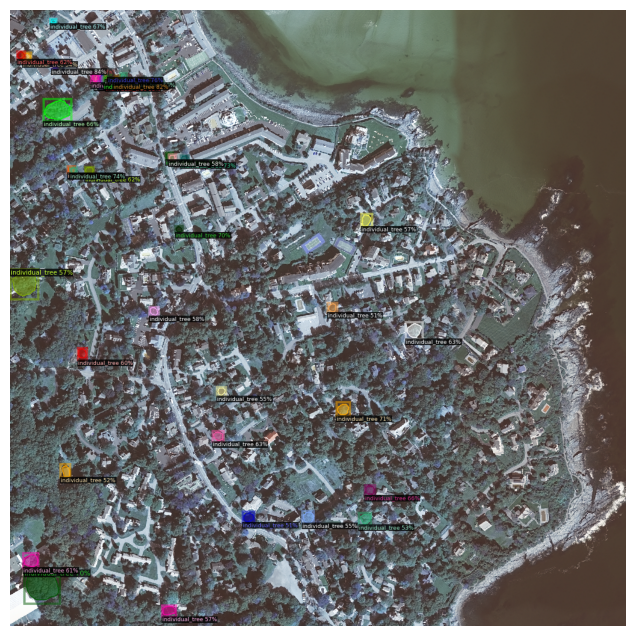


Done. Files written to the eval folder and submission JSON saved.


In [ ]:
# === EVAL + TTA + submission generation (single cell) ===
import os, json, time, cv2, numpy as np
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader, DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.evaluation import DatasetEvaluator
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

# ---- Edit these if your names/paths are different ----
VAL_NAME = "tree_canopy_val_remapped"       # validation dataset name you registered
OUTPUT_DIR = cfg.OUTPUT_DIR                 # keep same output dir used for training
DATA_ROOT = "/content/dataset"
SCORE_THRESH = 0.5
SUBMISSION_OUT = os.path.join(DATA_ROOT, "submission_from_eval.json")
COCO_RESULTS_OUT = os.path.join(OUTPUT_DIR, "eval", "coco_instances_results.json")
USE_TTA = False      # set True to run TTA eval (slower but usually better)
# -----------------------------------------------------

os.makedirs(os.path.join(OUTPUT_DIR, "eval"), exist_ok=True)

# 1) Load trained weights (prefer model_final.pth)
weights_path = os.path.join(OUTPUT_DIR, "model_final.pth")
if not os.path.exists(weights_path):
    # find latest checkpoint in OUTPUT_DIR
    ckps = [os.path.join(OUTPUT_DIR, f) for f in os.listdir(OUTPUT_DIR) if f.endswith(".pth") or f.endswith(".pth.tar")]
    if ckps:
        weights_path = sorted(ckps, key=os.path.getmtime)[-1]
        print("Using latest checkpoint:", weights_path)
    else:
        # try detectron2 default last_checkpoint file
        last = os.path.join(OUTPUT_DIR, "last_checkpoint")
        if os.path.exists(last):
            with open(last, "r") as f:
                weights_path = f.read().strip()
        else:
            raise FileNotFoundError("No checkpoint found in OUTPUT_DIR: " + OUTPUT_DIR)

print("Loading weights:", weights_path)
cfg.MODEL.WEIGHTS = weights_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = SCORE_THRESH

# 2) Build evaluator + dataloader, then run inference
evaluator = COCOEvaluator(VAL_NAME, cfg, False, output_dir=os.path.join(OUTPUT_DIR, "eval"))
val_loader = build_detection_test_loader(cfg, VAL_NAME)

print("Running evaluation on dataset:", VAL_NAME)
start = time.time()
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import inference_on_dataset
# if trainer exists and has model, use it; otherwise build model from cfg
try:
    model = trainer.model
    # ensure weights loaded into model
    DetectionCheckpointer(model).load(weights_path)
except Exception:
    model = build_model(cfg)
    DetectionCheckpointer(model).load(weights_path)
res = inference_on_dataset(model, val_loader, evaluator)
dur = time.time() - start
print(f"EVAL completed in {dur:.1f}s")
print("EVAL RESULTS (dict):")
print(json.dumps(res, indent=2))

# Save a copy of the COCO results (if produced by evaluator)
coco_json_path = os.path.join(OUTPUT_DIR, "eval", "coco_instances_results.json")
if os.path.exists(coco_json_path):
    print("COCO results saved at:", coco_json_path)
else:
    print("COCO results file not found at expected path:", coco_json_path)

# 3) Optional: Test-time augmentation evaluation (Detectron2 convenience)
if USE_TTA:
    print("\nRunning TTA evaluation (this is slower)...")
    from detectron2.engine import DefaultTrainer
    from detectron2.modeling.test_time_augment import GeneralizedRCNNWithTTA
    tta_model = GeneralizedRCNNWithTTA(cfg, model)
    tta_evaluator = COCOEvaluator(VAL_NAME, cfg, False, output_dir=os.path.join(OUTPUT_DIR, "eval_tta"))
    tta_loader = build_detection_test_loader(cfg, VAL_NAME)
    tta_res = inference_on_dataset(tta_model, tta_loader, tta_evaluator)
    print("TTA RESULTS:")
    print(json.dumps(tta_res, indent=2))

# 4) Build a submission JSON (Solafune format) from predictions (val set)
print("\nBuilding submission JSON from predictions (val set) ...")
predictor = DefaultPredictor(cfg)  # uses cfg.MODEL.WEIGHTS and SCORE_THRESH_TEST
dataset_dicts = DatasetCatalog.get(VAL_NAME)
meta = MetadataCatalog.get(VAL_NAME)

submission = {"images": []}
cnt_images = 0
for d in dataset_dicts:
    file_name = d["file_name"]
    # make absolute path if needed
    img_path = file_name if os.path.isabs(file_name) else os.path.join(DATA_ROOT, file_name)
    im = cv2.imread(img_path)
    if im is None:
        print("WARN: could not read", img_path)
        continue
    outputs = predictor(im)
    instances = outputs.get("instances")
    if instances is None or len(instances) == 0:
        # add empty entry to conform with expected output
        submission["images"].append({
            "file_name": os.path.basename(img_path),
            "width": int(d.get("width", im.shape[1])),
            "height": int(d.get("height", im.shape[0])),
            "scene_type": d.get("scene_type", "unknown"),
            "cm_resolution": d.get("cm_resolution", 40),
            "annotations": []
        })
        cnt_images += 1
        continue

    ins = instances.to("cpu")
    ann_list = []
    for i in range(len(ins)):
        score = float(ins.scores[i].item())
        # class handling: map class id -> name
        cat_id = int(ins.pred_classes[i].item()) if ins.has("pred_classes") else 0
        class_name = meta.thing_classes[cat_id] if meta and hasattr(meta, "thing_classes") and len(meta.thing_classes)>cat_id else "individual_tree"
        mask = ins.pred_masks[i].numpy().astype("uint8") * 255
        # clean small holes / noise
        kernel = np.ones((3,3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        # keep the largest contour (optionally you may keep multiple)
        contour = max(contours, key=cv2.contourArea)
        # approximate polygon (epsilon controls simplification)
        eps = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)
        poly = approx.flatten().tolist()
        if len(poly) < 6:
            # skip too small polygons
            continue
        ann_list.append({
            "class": class_name,
            "confidence_score": score,
            "segmentation": poly
        })

    submission["images"].append({
        "file_name": os.path.basename(img_path),
        "width": int(d.get("width", im.shape[1])),
        "height": int(d.get("height", im.shape[0])),
        "scene_type": d.get("scene_type", "unknown"),
        "cm_resolution": d.get("cm_resolution", 40),
        "annotations": ann_list
    })
    cnt_images += 1

# Save submission
with open(SUBMISSION_OUT, "w") as f:
    json.dump(submission, f)
print(f"Submission JSON saved to: {SUBMISSION_OUT}  (images processed: {cnt_images})")

# quick visual sample of predictions
try:
    import random, matplotlib.pyplot as plt
    sample = random.choice(dataset_dicts)
    p = sample["file_name"] if os.path.isabs(sample["file_name"]) else os.path.join(DATA_ROOT, sample["file_name"])
    im = cv2.imread(p)
    out = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get(VAL_NAME), scale=1.0, instance_mode=ColorMode.IMAGE)
    out_vis = v.draw_instance_predictions(out["instances"].to("cpu"))
    plt.figure(figsize=(8,8)); plt.imshow(out_vis.get_image()[:, :, ::-1]); plt.axis("off"); plt.show()
except Exception as e:
    print("Visual check failed:", e)

print("\nDone. Files written to the eval folder and submission JSON saved.")


In [ ]:
# Robust fixer: find sample_answer.json, build validator-friendly submission and download
import os, json, cv2, numpy as np, pathlib, random
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from google.colab import files

# ---------- CONFIG ----------
DATA_ROOT = "/content/dataset"
CANDIDATES = [
    os.path.join(DATA_ROOT, "sample_answer.json"),
    "/content/sample_answer.json",
    "./sample_answer.json",
    os.path.join(DATA_ROOT, "sample_submission.json"),
    "/content/sample_submission.json",
]
VAL_NAME = "tree_canopy_val_remapped"   # registered dataset name
OUT_JSON = "/content/submission_fixed.json"
CONF_THRESH = 0.5
DEFAULT_SCENE = "unknown"
DEFAULT_CM = 40
SKIP_MISSING = False   # if False, we'll insert empty entries for missing images to match expected list
# ----------------------------

# Find sample template if present
sample_path = None
for p in CANDIDATES:
    if p and os.path.exists(p):
        sample_path = p
        break

if sample_path:
    print("Using sample/template JSON found at:", sample_path)
    with open(sample_path, "r") as f:
        sample = json.load(f)
    expected_list = [im.get("file_name") for im in sample.get("images", []) if im.get("file_name")]
    # Build mapping from basename -> sample filename (exact string validator expects)
    expected_map = {os.path.basename(fn): fn for fn in expected_list}
else:
    print("No sample template found at standard locations. Falling back to dataset image list (will create expected list from dataset).")
    # Build expected list from registered val dataset basenames
    if VAL_NAME not in list(DatasetCatalog.keys()):
        raise KeyError(f"Dataset '{VAL_NAME}' is not registered. Registered datasets: {list(DatasetCatalog.keys())}")
    dataset_dicts = DatasetCatalog.get(VAL_NAME)
    expected_list = [d["file_name"] for d in dataset_dicts]
    expected_map = {os.path.basename(fn): fn for fn in expected_list}
    sample = {"images": [{"file_name": fn} for fn in expected_list]}

# Ensure cfg and weights exist
try:
    cfg
except NameError:
    raise RuntimeError("cfg not defined. Recreate cfg exactly as used during training before running this cell.")

# Ensure we have model weights
if not (getattr(cfg.MODEL, "WEIGHTS", None) and os.path.exists(cfg.MODEL.WEIGHTS)):
    candidate = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    if os.path.exists(candidate):
        cfg.MODEL.WEIGHTS = candidate
        print("Auto-set cfg.MODEL.WEIGHTS ->", candidate)
    else:
        # try find latest .pth
        if os.path.isdir(cfg.OUTPUT_DIR):
            ckps = [os.path.join(cfg.OUTPUT_DIR, f) for f in os.listdir(cfg.OUTPUT_DIR) if f.endswith(".pth")]
            if ckps:
                cfg.MODEL.WEIGHTS = sorted(ckps, key=os.path.getmtime)[-1]
                print("Auto-set cfg.MODEL.WEIGHTS ->", cfg.MODEL.WEIGHTS)
            else:
                raise FileNotFoundError("No checkpoint found in cfg.OUTPUT_DIR; set cfg.MODEL.WEIGHTS manually.")
        else:
            raise FileNotFoundError("cfg.OUTPUT_DIR not found; recreate cfg or set OUTPUT_DIR.")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = CONF_THRESH
predictor = DefaultPredictor(cfg)

# Build a lookup of on-disk images by basename -> fullpath (search DATA_ROOT and candidates)
disk_images = {}
# Walk DATA_ROOT quickly for image files (tif/jpg/png)
for root, _, files_in_dir in os.walk(DATA_ROOT):
    for fname in files_in_dir:
        if fname.lower().endswith((".tif", ".tiff", ".jpg", ".jpeg", ".png")):
            disk_images[fname] = os.path.join(root, fname)

# Also include top-level /content images
for top in ["/content"]:
    if os.path.isdir(top):
        for fname in os.listdir(top):
            if fname.lower().endswith((".tif", ".tiff", ".jpg", ".jpeg", ".png")):
                disk_images[fname] = os.path.join(top, fname)

print(f"Found {len(disk_images)} image files on disk (indexed by basename).")

# Iterate expected_list and create submission entries
submission = {"images": []}
processed = 0
missing_on_disk = []
for expected_fname in expected_list:
    # expected_fname may be path-like; get basename
    base = os.path.basename(expected_fname)
    # find local image path
    img_path = None
    # priority: same path relative to DATA_ROOT, then disk_images mapping
    candidate1 = expected_fname if os.path.isabs(expected_fname) else os.path.join(DATA_ROOT, expected_fname)
    if os.path.exists(candidate1):
        img_path = candidate1
    elif base in disk_images:
        img_path = disk_images[base]
    else:
        img_path = None

    if img_path is None:
        # missing on disk
        missing_on_disk.append(expected_fname)
        # decide whether to insert empty annotations or skip
        if SKIP_MISSING:
            print("Skipping missing image:", expected_fname)
            continue
        else:
            # insert empty entry (validator-friendly)
            submission["images"].append({
                "file_name": expected_fname,
                "width": None,
                "height": None,
                "scene_type": DEFAULT_SCENE,
                "cm_resolution": DEFAULT_CM,
                "annotations": []
            })
            continue

    # read image
    im = cv2.imread(img_path)
    if im is None:
        print("Warning: could not read image:", img_path, "— inserting empty annotations")
        submission["images"].append({
            "file_name": expected_fname,
            "width": None,
            "height": None,
            "scene_type": DEFAULT_SCENE,
            "cm_resolution": DEFAULT_CM,
            "annotations": []
        })
        continue

    outputs = predictor(im)
    ins = outputs.get("instances")
    ann_list = []
    if ins is not None and len(ins) > 0:
        ins = ins.to("cpu")
        meta = MetadataCatalog.get(VAL_NAME) if VAL_NAME in MetadataCatalog.list() else None
        for i in range(len(ins)):
            score = float(ins.scores[i].item())
            cls_id = int(ins.pred_classes[i].item()) if ins.has("pred_classes") else 0
            class_name = meta.thing_classes[cls_id] if meta and hasattr(meta, "thing_classes") and len(meta.thing_classes) > cls_id else "individual_tree"
            mask = ins.pred_masks[i].numpy().astype("uint8") * 255

            # morphological cleaning
            kernel = np.ones((3,3), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                if cv2.contourArea(cnt) < 20:
                    continue
                eps = 0.01 * cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, eps, True)
                poly = approx.flatten().tolist()
                if len(poly) < 6:
                    continue
                ann_list.append({
                    "class": class_name,
                    "confidence_score": score,
                    "segmentation": poly
                })

    submission["images"].append({
        "file_name": expected_fname,
        "width": int(im.shape[1]),
        "height": int(im.shape[0]),
        "scene_type": DEFAULT_SCENE,
        "cm_resolution": DEFAULT_CM,
        "annotations": ann_list
    })
    processed += 1

print(f"\nProcessed entries: {processed}")
print(f"Missing images not found on disk: {len(missing_on_disk)} (example): {missing_on_disk[:5]}")

# Save and download
with open(OUT_JSON, "w") as f:
    json.dump(submission, f)
print("Saved submission to:", OUT_JSON, "size:", pathlib.Path(OUT_JSON).stat().st_size, "bytes")
files.download(OUT_JSON)


Using sample/template JSON found at: /content/sample_answer.json
[10/23 20:36:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/dataset/detectron2_output_remapped/model_final.pth ...
Found 600 image files on disk (indexed by basename).

Processed entries: 150
Missing images not found on disk: 0 (example): []
Saved submission to: /content/submission_fixed.json size: 1239771 bytes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# === Fine-tune configuration for better performance ===

cfg.SOLVER.MAX_ITER = 8000
cfg.SOLVER.BASE_LR = 5e-5
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD = 0.1
cfg.INPUT.MIN_SIZE_TRAIN = (600, 800, 1024)
cfg.INPUT.MAX_SIZE_TRAIN = 1600
cfg.TEST.AUG.ENABLED = True

print("✅ Config updated. You can now start training:")
print("trainer = AugTrainer(cfg)")
print("trainer.resume_or_load(resume=False); trainer.train()")


✅ Config updated. You can now start training:
trainer = AugTrainer(cfg)
trainer.resume_or_load(resume=False); trainer.train()


In [ ]:
trainer = AugTrainer(cfg)
trainer.resume_or_load(resume=False); trainer.train()

[10/23 20:38:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()


[10/23 20:38:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/dataset/detectron2_output_remapped/model_final.pth ...
[10/23 20:38:46 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:38:51 d2.utils.events]:  eta: 0:30:36  iter: 19  total_loss: 1.679  loss_cls: 0.4176  loss_box_reg: 0.3292  loss_mask: 0.3479  loss_rpn_cls: 0.1824  loss_rpn_loc: 0.3438    time: 0.2331  last_time: 0.2589  data_time: 0.0335  last_data_time: 0.0070   lr: 1.9481e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:38:56 d2.utils.events]:  eta: 0:31:21  iter: 39  total_loss: 1.826  loss_cls: 0.4077  loss_box_reg: 0.3441  loss_mask: 0.3387  loss_rpn_cls: 0.2388  loss_rpn_loc: 0.3359    time: 0.2382  last_time: 0.1772  data_time: 0.0084  last_data_time: 0.0046   lr: 3.9461e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:39:01 d2.utils.events]:  eta: 0:30:16  iter: 59  total_loss: 1.926  loss_cls: 0.4456  loss_box_reg: 0.44  loss_mask: 0.3744  loss_rpn_cls: 0.2156  loss_rpn_loc: 0.3684    time: 0.2346  last_time: 0.2529  data_time: 0.0071  last_data_time: 0.0046   lr: 5.9441e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:39:05 d2.utils.events]:  eta: 0:29:19  iter: 79  total_loss: 1.8  loss_cls: 0.4281  loss_box_reg: 0.3475  loss_mask: 0.3669  loss_rpn_cls: 0.2536  loss_rpn_loc: 0.4186    time: 0.2273  last_time: 0.1537  data_time: 0.0062  last_data_time: 0.0013   lr: 7.9421e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:39:10 d2.utils.events]:  eta: 0:29:15  iter: 99  total_loss: 1.665  loss_cls: 0.3867  loss_box_reg: 0.425  loss_mask: 0.345  loss_rpn_cls: 0.1758  loss_rpn_loc: 0.2332    time: 0.2289  last_time: 0.2731  data_time: 0.0072  last_data_time: 0.0011   lr: 9.9401e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:39:14 d2.utils.events]:  eta: 0:28:33  iter: 119  total_loss: 1.794  loss_cls: 0.4256  loss_box_reg: 0.3767  loss_mask: 0.3559  loss_rpn_cls: 0.2071  loss_rpn_loc: 0.3508    time: 0.2252  last_time: 0.1720  data_time: 0.0056  last_data_time: 0.0010   lr: 1.1938e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:39:18 d2.utils.events]:  eta: 0:28:01  iter: 139  total_loss: 1.805  loss_cls: 0.3722  loss_box_reg: 0.4132  loss_mask: 0.3615  loss_rpn_cls: 0.168  loss_rpn_loc: 0.3183    time: 0.2218  last_time: 0.1507  data_time: 0.0052  last_data_time: 0.0088   lr: 1.3936e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:39:23 d2.utils.events]:  eta: 0:28:12  iter: 159  total_loss: 1.815  loss_cls: 0.4306  loss_box_reg: 0.4128  loss_mask: 0.3636  loss_rpn_cls: 0.1743  loss_rpn_loc: 0.3456    time: 0.2235  last_time: 0.2552  data_time: 0.0074  last_data_time: 0.0124   lr: 1.5934e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:39:27 d2.utils.events]:  eta: 0:28:07  iter: 179  total_loss: 1.689  loss_cls: 0.3769  loss_box_reg: 0.2812  loss_mask: 0.3564  loss_rpn_cls: 0.2957  loss_rpn_loc: 0.4132    time: 0.2235  last_time: 0.1948  data_time: 0.0064  last_data_time: 0.0010   lr: 1.7932e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:39:32 d2.utils.events]:  eta: 0:27:55  iter: 199  total_loss: 1.803  loss_cls: 0.4141  loss_box_reg: 0.3971  loss_mask: 0.348  loss_rpn_cls: 0.1949  loss_rpn_loc: 0.3442    time: 0.2233  last_time: 0.1678  data_time: 0.0056  last_data_time: 0.0041   lr: 1.993e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:39:37 d2.utils.events]:  eta: 0:28:13  iter: 219  total_loss: 1.832  loss_cls: 0.4393  loss_box_reg: 0.3632  loss_mask: 0.3637  loss_rpn_cls: 0.2143  loss_rpn_loc: 0.2575    time: 0.2275  last_time: 0.3297  data_time: 0.0111  last_data_time: 0.0098   lr: 2.1928e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:39:41 d2.utils.events]:  eta: 0:28:09  iter: 239  total_loss: 1.783  loss_cls: 0.4328  loss_box_reg: 0.3676  loss_mask: 0.3527  loss_rpn_cls: 0.219  loss_rpn_loc: 0.3378    time: 0.2272  last_time: 0.2781  data_time: 0.0060  last_data_time: 0.0109   lr: 2.3926e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:39:46 d2.utils.events]:  eta: 0:28:04  iter: 259  total_loss: 1.862  loss_cls: 0.4505  loss_box_reg: 0.4246  loss_mask: 0.3568  loss_rpn_cls: 0.2639  loss_rpn_loc: 0.3447    time: 0.2284  last_time: 0.2939  data_time: 0.0080  last_data_time: 0.0120   lr: 2.5924e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:39:51 d2.utils.events]:  eta: 0:28:00  iter: 279  total_loss: 1.699  loss_cls: 0.4133  loss_box_reg: 0.404  loss_mask: 0.3384  loss_rpn_cls: 0.159  loss_rpn_loc: 0.273    time: 0.2274  last_time: 0.1761  data_time: 0.0056  last_data_time: 0.0041   lr: 2.7922e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:39:55 d2.utils.events]:  eta: 0:27:59  iter: 299  total_loss: 1.834  loss_cls: 0.466  loss_box_reg: 0.3808  loss_mask: 0.3564  loss_rpn_cls: 0.207  loss_rpn_loc: 0.3947    time: 0.2270  last_time: 0.1519  data_time: 0.0059  last_data_time: 0.0009   lr: 2.992e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:00 d2.utils.events]:  eta: 0:28:15  iter: 319  total_loss: 1.687  loss_cls: 0.3708  loss_box_reg: 0.3733  loss_mask: 0.3283  loss_rpn_cls: 0.1821  loss_rpn_loc: 0.3598    time: 0.2288  last_time: 0.3486  data_time: 0.0066  last_data_time: 0.0080   lr: 3.1918e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:05 d2.utils.events]:  eta: 0:28:02  iter: 339  total_loss: 1.75  loss_cls: 0.3928  loss_box_reg: 0.4513  loss_mask: 0.3497  loss_rpn_cls: 0.191  loss_rpn_loc: 0.3137    time: 0.2280  last_time: 0.2001  data_time: 0.0064  last_data_time: 0.0065   lr: 3.3916e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:09 d2.utils.events]:  eta: 0:27:52  iter: 359  total_loss: 1.672  loss_cls: 0.3943  loss_box_reg: 0.3403  loss_mask: 0.3467  loss_rpn_cls: 0.126  loss_rpn_loc: 0.2795    time: 0.2278  last_time: 0.3073  data_time: 0.0065  last_data_time: 0.0095   lr: 3.5914e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:14 d2.utils.events]:  eta: 0:27:52  iter: 379  total_loss: 1.831  loss_cls: 0.4489  loss_box_reg: 0.4311  loss_mask: 0.3436  loss_rpn_cls: 0.1823  loss_rpn_loc: 0.3312    time: 0.2282  last_time: 0.2229  data_time: 0.0084  last_data_time: 0.0083   lr: 3.7912e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:18 d2.utils.events]:  eta: 0:27:37  iter: 399  total_loss: 1.785  loss_cls: 0.4076  loss_box_reg: 0.3877  loss_mask: 0.3531  loss_rpn_cls: 0.2236  loss_rpn_loc: 0.379    time: 0.2273  last_time: 0.2592  data_time: 0.0068  last_data_time: 0.0137   lr: 3.991e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:23 d2.utils.events]:  eta: 0:27:38  iter: 419  total_loss: 1.765  loss_cls: 0.4314  loss_box_reg: 0.3639  loss_mask: 0.3469  loss_rpn_cls: 0.1954  loss_rpn_loc: 0.3607    time: 0.2273  last_time: 0.1991  data_time: 0.0075  last_data_time: 0.0132   lr: 4.1908e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:28 d2.utils.events]:  eta: 0:27:40  iter: 439  total_loss: 1.604  loss_cls: 0.4139  loss_box_reg: 0.3665  loss_mask: 0.3344  loss_rpn_cls: 0.134  loss_rpn_loc: 0.2396    time: 0.2291  last_time: 0.1504  data_time: 0.0099  last_data_time: 0.0041   lr: 4.3906e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:32 d2.utils.events]:  eta: 0:27:33  iter: 459  total_loss: 1.87  loss_cls: 0.456  loss_box_reg: 0.4389  loss_mask: 0.3511  loss_rpn_cls: 0.2242  loss_rpn_loc: 0.3528    time: 0.2278  last_time: 0.2340  data_time: 0.0065  last_data_time: 0.0037   lr: 4.5904e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:36 d2.utils.events]:  eta: 0:27:25  iter: 479  total_loss: 1.614  loss_cls: 0.4024  loss_box_reg: 0.3341  loss_mask: 0.358  loss_rpn_cls: 0.2209  loss_rpn_loc: 0.3663    time: 0.2278  last_time: 0.3153  data_time: 0.0069  last_data_time: 0.0060   lr: 4.7902e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:41 d2.utils.events]:  eta: 0:27:21  iter: 499  total_loss: 1.82  loss_cls: 0.3834  loss_box_reg: 0.3286  loss_mask: 0.3575  loss_rpn_cls: 0.2192  loss_rpn_loc: 0.3656    time: 0.2285  last_time: 0.2324  data_time: 0.0093  last_data_time: 0.0104   lr: 4.99e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:46 d2.utils.events]:  eta: 0:27:16  iter: 519  total_loss: 1.677  loss_cls: 0.3597  loss_box_reg: 0.413  loss_mask: 0.3437  loss_rpn_cls: 0.1558  loss_rpn_loc: 0.19    time: 0.2280  last_time: 0.1720  data_time: 0.0054  last_data_time: 0.0040   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:51 d2.utils.events]:  eta: 0:27:12  iter: 539  total_loss: 1.845  loss_cls: 0.459  loss_box_reg: 0.4532  loss_mask: 0.3391  loss_rpn_cls: 0.2317  loss_rpn_loc: 0.3662    time: 0.2286  last_time: 0.3245  data_time: 0.0081  last_data_time: 0.0178   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:55 d2.utils.events]:  eta: 0:27:07  iter: 559  total_loss: 1.779  loss_cls: 0.4358  loss_box_reg: 0.3948  loss_mask: 0.3468  loss_rpn_cls: 0.1769  loss_rpn_loc: 0.3791    time: 0.2277  last_time: 0.1984  data_time: 0.0068  last_data_time: 0.0065   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:40:59 d2.utils.events]:  eta: 0:27:00  iter: 579  total_loss: 1.766  loss_cls: 0.4242  loss_box_reg: 0.3974  loss_mask: 0.3525  loss_rpn_cls: 0.193  loss_rpn_loc: 0.385    time: 0.2274  last_time: 0.3553  data_time: 0.0071  last_data_time: 0.0109   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:41:04 d2.utils.events]:  eta: 0:26:59  iter: 599  total_loss: 1.669  loss_cls: 0.3903  loss_box_reg: 0.3454  loss_mask: 0.3542  loss_rpn_cls: 0.1835  loss_rpn_loc: 0.3132    time: 0.2278  last_time: 0.3501  data_time: 0.0077  last_data_time: 0.0144   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:41:09 d2.utils.events]:  eta: 0:26:55  iter: 619  total_loss: 1.796  loss_cls: 0.4474  loss_box_reg: 0.3742  loss_mask: 0.3491  loss_rpn_cls: 0.2178  loss_rpn_loc: 0.3546    time: 0.2288  last_time: 0.1420  data_time: 0.0091  last_data_time: 0.0035   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:41:13 d2.utils.events]:  eta: 0:26:49  iter: 639  total_loss: 1.378  loss_cls: 0.3332  loss_box_reg: 0.3959  loss_mask: 0.3111  loss_rpn_cls: 0.1333  loss_rpn_loc: 0.168    time: 0.2282  last_time: 0.2019  data_time: 0.0072  last_data_time: 0.0048   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:41:18 d2.utils.events]:  eta: 0:26:46  iter: 659  total_loss: 1.889  loss_cls: 0.4202  loss_box_reg: 0.3946  loss_mask: 0.3518  loss_rpn_cls: 0.2133  loss_rpn_loc: 0.346    time: 0.2287  last_time: 0.1566  data_time: 0.0097  last_data_time: 0.0036   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:41:22 d2.utils.events]:  eta: 0:26:41  iter: 679  total_loss: 1.675  loss_cls: 0.4227  loss_box_reg: 0.4241  loss_mask: 0.3328  loss_rpn_cls: 0.1989  loss_rpn_loc: 0.2865    time: 0.2279  last_time: 0.2697  data_time: 0.0054  last_data_time: 0.0098   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:41:27 d2.utils.events]:  eta: 0:26:39  iter: 699  total_loss: 1.742  loss_cls: 0.4205  loss_box_reg: 0.3908  loss_mask: 0.3669  loss_rpn_cls: 0.2182  loss_rpn_loc: 0.3535    time: 0.2287  last_time: 0.2639  data_time: 0.0074  last_data_time: 0.0046   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:41:32 d2.utils.events]:  eta: 0:26:39  iter: 719  total_loss: 1.69  loss_cls: 0.3968  loss_box_reg: 0.3833  loss_mask: 0.3633  loss_rpn_cls: 0.1749  loss_rpn_loc: 0.3577    time: 0.2293  last_time: 0.1935  data_time: 0.0077  last_data_time: 0.0047   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:41:37 d2.utils.events]:  eta: 0:26:30  iter: 739  total_loss: 1.627  loss_cls: 0.355  loss_box_reg: 0.362  loss_mask: 0.3455  loss_rpn_cls: 0.1717  loss_rpn_loc: 0.2448    time: 0.2289  last_time: 0.1513  data_time: 0.0058  last_data_time: 0.0044   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:41:41 d2.utils.events]:  eta: 0:26:30  iter: 759  total_loss: 1.808  loss_cls: 0.4152  loss_box_reg: 0.3962  loss_mask: 0.3496  loss_rpn_cls: 0.2162  loss_rpn_loc: 0.3485    time: 0.2291  last_time: 0.2325  data_time: 0.0077  last_data_time: 0.0100   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:41:46 d2.utils.events]:  eta: 0:26:23  iter: 779  total_loss: 1.699  loss_cls: 0.381  loss_box_reg: 0.4183  loss_mask: 0.3726  loss_rpn_cls: 0.1785  loss_rpn_loc: 0.3177    time: 0.2291  last_time: 0.2933  data_time: 0.0082  last_data_time: 0.0147   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:41:51 d2.utils.events]:  eta: 0:26:20  iter: 799  total_loss: 1.799  loss_cls: 0.4236  loss_box_reg: 0.3687  loss_mask: 0.3454  loss_rpn_cls: 0.194  loss_rpn_loc: 0.3611    time: 0.2295  last_time: 0.1917  data_time: 0.0066  last_data_time: 0.0051   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:41:55 d2.utils.events]:  eta: 0:26:14  iter: 819  total_loss: 1.826  loss_cls: 0.456  loss_box_reg: 0.3292  loss_mask: 0.3585  loss_rpn_cls: 0.1846  loss_rpn_loc: 0.3346    time: 0.2294  last_time: 0.3187  data_time: 0.0073  last_data_time: 0.0139   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:42:00 d2.utils.events]:  eta: 0:26:12  iter: 839  total_loss: 1.732  loss_cls: 0.4408  loss_box_reg: 0.4226  loss_mask: 0.3303  loss_rpn_cls: 0.1841  loss_rpn_loc: 0.3116    time: 0.2295  last_time: 0.1589  data_time: 0.0073  last_data_time: 0.0010   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:42:05 d2.utils.events]:  eta: 0:26:09  iter: 859  total_loss: 1.79  loss_cls: 0.4185  loss_box_reg: 0.3473  loss_mask: 0.3704  loss_rpn_cls: 0.2293  loss_rpn_loc: 0.3546    time: 0.2296  last_time: 0.2350  data_time: 0.0076  last_data_time: 0.0039   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:42:10 d2.utils.events]:  eta: 0:26:07  iter: 879  total_loss: 1.696  loss_cls: 0.3808  loss_box_reg: 0.3539  loss_mask: 0.3403  loss_rpn_cls: 0.1453  loss_rpn_loc: 0.2811    time: 0.2301  last_time: 0.2245  data_time: 0.0088  last_data_time: 0.0040   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:42:14 d2.utils.events]:  eta: 0:26:00  iter: 899  total_loss: 1.752  loss_cls: 0.4827  loss_box_reg: 0.4523  loss_mask: 0.3488  loss_rpn_cls: 0.1757  loss_rpn_loc: 0.2861    time: 0.2295  last_time: 0.2495  data_time: 0.0058  last_data_time: 0.0138   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:42:18 d2.utils.events]:  eta: 0:25:50  iter: 919  total_loss: 1.67  loss_cls: 0.4266  loss_box_reg: 0.3934  loss_mask: 0.3324  loss_rpn_cls: 0.1666  loss_rpn_loc: 0.2092    time: 0.2289  last_time: 0.2142  data_time: 0.0056  last_data_time: 0.0088   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:42:23 d2.utils.events]:  eta: 0:25:49  iter: 939  total_loss: 1.818  loss_cls: 0.4495  loss_box_reg: 0.3505  loss_mask: 0.3659  loss_rpn_cls: 0.2488  loss_rpn_loc: 0.3939    time: 0.2296  last_time: 0.1533  data_time: 0.0098  last_data_time: 0.0011   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:42:28 d2.utils.events]:  eta: 0:25:47  iter: 959  total_loss: 1.717  loss_cls: 0.3679  loss_box_reg: 0.3537  loss_mask: 0.3381  loss_rpn_cls: 0.1827  loss_rpn_loc: 0.3121    time: 0.2300  last_time: 0.4045  data_time: 0.0077  last_data_time: 0.0143   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:42:33 d2.utils.events]:  eta: 0:25:37  iter: 979  total_loss: 1.741  loss_cls: 0.4448  loss_box_reg: 0.391  loss_mask: 0.3547  loss_rpn_cls: 0.1702  loss_rpn_loc: 0.3022    time: 0.2296  last_time: 0.2951  data_time: 0.0059  last_data_time: 0.0092   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:42:37 d2.utils.events]:  eta: 0:25:36  iter: 999  total_loss: 1.653  loss_cls: 0.3951  loss_box_reg: 0.4047  loss_mask: 0.3406  loss_rpn_cls: 0.1742  loss_rpn_loc: 0.3224    time: 0.2299  last_time: 0.2299  data_time: 0.0076  last_data_time: 0.0007   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:42:42 d2.utils.events]:  eta: 0:25:31  iter: 1019  total_loss: 1.634  loss_cls: 0.3902  loss_box_reg: 0.3575  loss_mask: 0.3402  loss_rpn_cls: 0.1594  loss_rpn_loc: 0.3405    time: 0.2299  last_time: 0.1672  data_time: 0.0063  last_data_time: 0.0029   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:42:47 d2.utils.events]:  eta: 0:25:23  iter: 1039  total_loss: 1.772  loss_cls: 0.4031  loss_box_reg: 0.3401  loss_mask: 0.3553  loss_rpn_cls: 0.1859  loss_rpn_loc: 0.3629    time: 0.2302  last_time: 0.3764  data_time: 0.0082  last_data_time: 0.0221   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:42:53 d2.utils.events]:  eta: 0:25:25  iter: 1059  total_loss: 1.871  loss_cls: 0.4353  loss_box_reg: 0.3804  loss_mask: 0.3734  loss_rpn_cls: 0.2643  loss_rpn_loc: 0.365    time: 0.2312  last_time: 0.2374  data_time: 0.0114  last_data_time: 0.0049   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:42:57 d2.utils.events]:  eta: 0:25:25  iter: 1079  total_loss: 1.712  loss_cls: 0.4051  loss_box_reg: 0.3193  loss_mask: 0.3429  loss_rpn_cls: 0.1866  loss_rpn_loc: 0.3491    time: 0.2312  last_time: 0.2392  data_time: 0.0062  last_data_time: 0.0038   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:43:02 d2.utils.events]:  eta: 0:25:26  iter: 1099  total_loss: 1.74  loss_cls: 0.3746  loss_box_reg: 0.3455  loss_mask: 0.3625  loss_rpn_cls: 0.2266  loss_rpn_loc: 0.3733    time: 0.2315  last_time: 0.1630  data_time: 0.0097  last_data_time: 0.0034   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:43:06 d2.utils.events]:  eta: 0:25:23  iter: 1119  total_loss: 1.705  loss_cls: 0.3989  loss_box_reg: 0.3713  loss_mask: 0.3266  loss_rpn_cls: 0.1462  loss_rpn_loc: 0.1843    time: 0.2311  last_time: 0.1493  data_time: 0.0053  last_data_time: 0.0011   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:43:11 d2.utils.events]:  eta: 0:25:22  iter: 1139  total_loss: 1.903  loss_cls: 0.4473  loss_box_reg: 0.3717  loss_mask: 0.3443  loss_rpn_cls: 0.2379  loss_rpn_loc: 0.4258    time: 0.2311  last_time: 0.2788  data_time: 0.0076  last_data_time: 0.0092   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:43:16 d2.utils.events]:  eta: 0:25:21  iter: 1159  total_loss: 1.76  loss_cls: 0.4307  loss_box_reg: 0.3629  loss_mask: 0.3688  loss_rpn_cls: 0.186  loss_rpn_loc: 0.3453    time: 0.2316  last_time: 0.2334  data_time: 0.0091  last_data_time: 0.0071   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:43:21 d2.utils.events]:  eta: 0:25:12  iter: 1179  total_loss: 1.431  loss_cls: 0.3327  loss_box_reg: 0.4416  loss_mask: 0.3247  loss_rpn_cls: 0.09503  loss_rpn_loc: 0.182    time: 0.2313  last_time: 0.1869  data_time: 0.0051  last_data_time: 0.0034   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:43:25 d2.utils.events]:  eta: 0:25:08  iter: 1199  total_loss: 1.807  loss_cls: 0.4159  loss_box_reg: 0.3667  loss_mask: 0.3471  loss_rpn_cls: 0.2254  loss_rpn_loc: 0.3474    time: 0.2312  last_time: 0.2980  data_time: 0.0071  last_data_time: 0.0035   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:43:30 d2.utils.events]:  eta: 0:25:04  iter: 1219  total_loss: 1.728  loss_cls: 0.4138  loss_box_reg: 0.3352  loss_mask: 0.3459  loss_rpn_cls: 0.1996  loss_rpn_loc: 0.3742    time: 0.2315  last_time: 0.2607  data_time: 0.0067  last_data_time: 0.0072   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:43:34 d2.utils.events]:  eta: 0:24:58  iter: 1239  total_loss: 1.665  loss_cls: 0.346  loss_box_reg: 0.4233  loss_mask: 0.3388  loss_rpn_cls: 0.1819  loss_rpn_loc: 0.1965    time: 0.2311  last_time: 0.1991  data_time: 0.0057  last_data_time: 0.0039   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:43:39 d2.utils.events]:  eta: 0:24:56  iter: 1259  total_loss: 1.526  loss_cls: 0.3573  loss_box_reg: 0.4051  loss_mask: 0.3236  loss_rpn_cls: 0.1701  loss_rpn_loc: 0.2435    time: 0.2311  last_time: 0.2175  data_time: 0.0079  last_data_time: 0.0084   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:43:43 d2.utils.events]:  eta: 0:24:52  iter: 1279  total_loss: 1.739  loss_cls: 0.4292  loss_box_reg: 0.3915  loss_mask: 0.3498  loss_rpn_cls: 0.1951  loss_rpn_loc: 0.3349    time: 0.2310  last_time: 0.1701  data_time: 0.0061  last_data_time: 0.0045   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:43:48 d2.utils.events]:  eta: 0:24:47  iter: 1299  total_loss: 1.698  loss_cls: 0.4006  loss_box_reg: 0.3451  loss_mask: 0.359  loss_rpn_cls: 0.1566  loss_rpn_loc: 0.3286    time: 0.2308  last_time: 0.2773  data_time: 0.0065  last_data_time: 0.0037   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:43:53 d2.utils.events]:  eta: 0:24:39  iter: 1319  total_loss: 1.821  loss_cls: 0.4375  loss_box_reg: 0.3592  loss_mask: 0.3586  loss_rpn_cls: 0.2219  loss_rpn_loc: 0.3623    time: 0.2313  last_time: 0.2302  data_time: 0.0099  last_data_time: 0.0153   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:43:57 d2.utils.events]:  eta: 0:24:31  iter: 1339  total_loss: 1.782  loss_cls: 0.4189  loss_box_reg: 0.3517  loss_mask: 0.3586  loss_rpn_cls: 0.2462  loss_rpn_loc: 0.4072    time: 0.2309  last_time: 0.1645  data_time: 0.0077  last_data_time: 0.0036   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:44:02 d2.utils.events]:  eta: 0:24:28  iter: 1359  total_loss: 1.808  loss_cls: 0.4242  loss_box_reg: 0.3922  loss_mask: 0.3512  loss_rpn_cls: 0.2036  loss_rpn_loc: 0.3201    time: 0.2310  last_time: 0.2067  data_time: 0.0072  last_data_time: 0.0037   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:44:07 d2.utils.events]:  eta: 0:24:29  iter: 1379  total_loss: 1.791  loss_cls: 0.4295  loss_box_reg: 0.368  loss_mask: 0.3542  loss_rpn_cls: 0.1814  loss_rpn_loc: 0.3677    time: 0.2315  last_time: 0.2248  data_time: 0.0092  last_data_time: 0.0039   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:44:11 d2.utils.events]:  eta: 0:24:22  iter: 1399  total_loss: 1.205  loss_cls: 0.2673  loss_box_reg: 0.3775  loss_mask: 0.2783  loss_rpn_cls: 0.07966  loss_rpn_loc: 0.1549    time: 0.2309  last_time: 0.2485  data_time: 0.0055  last_data_time: 0.0046   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:44:16 d2.utils.events]:  eta: 0:24:18  iter: 1419  total_loss: 1.704  loss_cls: 0.4279  loss_box_reg: 0.3789  loss_mask: 0.3447  loss_rpn_cls: 0.1698  loss_rpn_loc: 0.3438    time: 0.2310  last_time: 0.3146  data_time: 0.0071  last_data_time: 0.0074   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:44:20 d2.utils.events]:  eta: 0:24:06  iter: 1439  total_loss: 1.696  loss_cls: 0.3477  loss_box_reg: 0.3999  loss_mask: 0.3395  loss_rpn_cls: 0.1594  loss_rpn_loc: 0.2326    time: 0.2309  last_time: 0.1534  data_time: 0.0077  last_data_time: 0.0035   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:44:24 d2.utils.events]:  eta: 0:23:59  iter: 1459  total_loss: 1.663  loss_cls: 0.3913  loss_box_reg: 0.4265  loss_mask: 0.3425  loss_rpn_cls: 0.1161  loss_rpn_loc: 0.2144    time: 0.2304  last_time: 0.2817  data_time: 0.0048  last_data_time: 0.0061   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:44:30 d2.utils.events]:  eta: 0:24:01  iter: 1479  total_loss: 1.748  loss_cls: 0.3896  loss_box_reg: 0.2829  loss_mask: 0.3552  loss_rpn_cls: 0.2274  loss_rpn_loc: 0.361    time: 0.2309  last_time: 0.2309  data_time: 0.0106  last_data_time: 0.0074   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:44:34 d2.utils.events]:  eta: 0:23:56  iter: 1499  total_loss: 1.713  loss_cls: 0.4386  loss_box_reg: 0.4206  loss_mask: 0.3495  loss_rpn_cls: 0.218  loss_rpn_loc: 0.325    time: 0.2310  last_time: 0.1508  data_time: 0.0083  last_data_time: 0.0009   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:44:39 d2.utils.events]:  eta: 0:23:52  iter: 1519  total_loss: 1.894  loss_cls: 0.4451  loss_box_reg: 0.3591  loss_mask: 0.3725  loss_rpn_cls: 0.1953  loss_rpn_loc: 0.3861    time: 0.2308  last_time: 0.1810  data_time: 0.0066  last_data_time: 0.0097   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:44:43 d2.utils.events]:  eta: 0:23:52  iter: 1539  total_loss: 1.752  loss_cls: 0.4318  loss_box_reg: 0.3906  loss_mask: 0.3485  loss_rpn_cls: 0.1845  loss_rpn_loc: 0.3355    time: 0.2309  last_time: 0.1785  data_time: 0.0068  last_data_time: 0.0046   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:44:47 d2.utils.events]:  eta: 0:23:43  iter: 1559  total_loss: 1.724  loss_cls: 0.3583  loss_box_reg: 0.403  loss_mask: 0.3672  loss_rpn_cls: 0.2145  loss_rpn_loc: 0.3107    time: 0.2305  last_time: 0.2107  data_time: 0.0054  last_data_time: 0.0008   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:44:52 d2.utils.events]:  eta: 0:23:38  iter: 1579  total_loss: 1.697  loss_cls: 0.4202  loss_box_reg: 0.4449  loss_mask: 0.3511  loss_rpn_cls: 0.1571  loss_rpn_loc: 0.2292    time: 0.2302  last_time: 0.2220  data_time: 0.0052  last_data_time: 0.0038   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:44:57 d2.utils.events]:  eta: 0:23:35  iter: 1599  total_loss: 1.7  loss_cls: 0.3714  loss_box_reg: 0.3245  loss_mask: 0.3574  loss_rpn_cls: 0.2375  loss_rpn_loc: 0.352    time: 0.2306  last_time: 0.2327  data_time: 0.0083  last_data_time: 0.0168   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:45:01 d2.utils.events]:  eta: 0:23:27  iter: 1619  total_loss: 1.763  loss_cls: 0.4355  loss_box_reg: 0.3696  loss_mask: 0.3467  loss_rpn_cls: 0.2101  loss_rpn_loc: 0.3844    time: 0.2305  last_time: 0.1557  data_time: 0.0079  last_data_time: 0.0034   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:45:06 d2.utils.events]:  eta: 0:23:24  iter: 1639  total_loss: 1.891  loss_cls: 0.4589  loss_box_reg: 0.428  loss_mask: 0.3585  loss_rpn_cls: 0.1775  loss_rpn_loc: 0.3734    time: 0.2303  last_time: 0.3151  data_time: 0.0056  last_data_time: 0.0058   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:45:11 d2.utils.events]:  eta: 0:23:23  iter: 1659  total_loss: 1.745  loss_cls: 0.4499  loss_box_reg: 0.3687  loss_mask: 0.3668  loss_rpn_cls: 0.2073  loss_rpn_loc: 0.3396    time: 0.2309  last_time: 0.2931  data_time: 0.0116  last_data_time: 0.0233   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:45:15 d2.utils.events]:  eta: 0:23:17  iter: 1679  total_loss: 1.62  loss_cls: 0.3595  loss_box_reg: 0.3498  loss_mask: 0.3525  loss_rpn_cls: 0.2064  loss_rpn_loc: 0.3702    time: 0.2306  last_time: 0.2130  data_time: 0.0067  last_data_time: 0.0069   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:45:20 d2.utils.events]:  eta: 0:23:08  iter: 1699  total_loss: 1.728  loss_cls: 0.4064  loss_box_reg: 0.368  loss_mask: 0.3416  loss_rpn_cls: 0.2069  loss_rpn_loc: 0.2959    time: 0.2305  last_time: 0.2043  data_time: 0.0054  last_data_time: 0.0083   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:45:25 d2.utils.events]:  eta: 0:23:01  iter: 1719  total_loss: 1.718  loss_cls: 0.4339  loss_box_reg: 0.42  loss_mask: 0.3604  loss_rpn_cls: 0.1463  loss_rpn_loc: 0.2404    time: 0.2306  last_time: 0.1972  data_time: 0.0081  last_data_time: 0.0036   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:45:29 d2.utils.events]:  eta: 0:22:56  iter: 1739  total_loss: 1.758  loss_cls: 0.3977  loss_box_reg: 0.368  loss_mask: 0.3488  loss_rpn_cls: 0.164  loss_rpn_loc: 0.2568    time: 0.2303  last_time: 0.3906  data_time: 0.0060  last_data_time: 0.0131   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:45:33 d2.utils.events]:  eta: 0:22:44  iter: 1759  total_loss: 1.784  loss_cls: 0.4206  loss_box_reg: 0.4268  loss_mask: 0.3572  loss_rpn_cls: 0.2367  loss_rpn_loc: 0.3487    time: 0.2301  last_time: 0.1790  data_time: 0.0059  last_data_time: 0.0040   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:45:39 d2.utils.events]:  eta: 0:22:46  iter: 1779  total_loss: 1.708  loss_cls: 0.3994  loss_box_reg: 0.2935  loss_mask: 0.3549  loss_rpn_cls: 0.2059  loss_rpn_loc: 0.392    time: 0.2307  last_time: 0.2118  data_time: 0.0111  last_data_time: 0.0008   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:45:43 d2.utils.events]:  eta: 0:22:39  iter: 1799  total_loss: 1.697  loss_cls: 0.4019  loss_box_reg: 0.442  loss_mask: 0.3423  loss_rpn_cls: 0.1526  loss_rpn_loc: 0.2494    time: 0.2305  last_time: 0.1498  data_time: 0.0060  last_data_time: 0.0037   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:45:47 d2.utils.events]:  eta: 0:22:34  iter: 1819  total_loss: 1.708  loss_cls: 0.407  loss_box_reg: 0.3721  loss_mask: 0.3597  loss_rpn_cls: 0.205  loss_rpn_loc: 0.3307    time: 0.2304  last_time: 0.1867  data_time: 0.0058  last_data_time: 0.0045   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:45:53 d2.utils.events]:  eta: 0:22:30  iter: 1839  total_loss: 1.748  loss_cls: 0.405  loss_box_reg: 0.3833  loss_mask: 0.3515  loss_rpn_cls: 0.2113  loss_rpn_loc: 0.3271    time: 0.2308  last_time: 0.1789  data_time: 0.0091  last_data_time: 0.0023   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:45:57 d2.utils.events]:  eta: 0:22:20  iter: 1859  total_loss: 1.788  loss_cls: 0.4357  loss_box_reg: 0.3666  loss_mask: 0.3561  loss_rpn_cls: 0.2401  loss_rpn_loc: 0.3846    time: 0.2305  last_time: 0.2007  data_time: 0.0060  last_data_time: 0.0009   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:46:02 d2.utils.events]:  eta: 0:22:14  iter: 1879  total_loss: 1.678  loss_cls: 0.3973  loss_box_reg: 0.3963  loss_mask: 0.3381  loss_rpn_cls: 0.1462  loss_rpn_loc: 0.1872    time: 0.2306  last_time: 0.3086  data_time: 0.0080  last_data_time: 0.0013   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:46:07 d2.utils.events]:  eta: 0:22:13  iter: 1899  total_loss: 1.749  loss_cls: 0.3664  loss_box_reg: 0.4224  loss_mask: 0.3359  loss_rpn_cls: 0.1309  loss_rpn_loc: 0.2992    time: 0.2308  last_time: 0.1955  data_time: 0.0081  last_data_time: 0.0123   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:46:11 d2.utils.events]:  eta: 0:22:13  iter: 1919  total_loss: 1.783  loss_cls: 0.4064  loss_box_reg: 0.3904  loss_mask: 0.3518  loss_rpn_cls: 0.2305  loss_rpn_loc: 0.3521    time: 0.2306  last_time: 0.2345  data_time: 0.0063  last_data_time: 0.0088   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:46:16 d2.utils.events]:  eta: 0:22:09  iter: 1939  total_loss: 1.753  loss_cls: 0.3871  loss_box_reg: 0.3852  loss_mask: 0.3575  loss_rpn_cls: 0.1836  loss_rpn_loc: 0.333    time: 0.2310  last_time: 0.3217  data_time: 0.0085  last_data_time: 0.0010   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:46:21 d2.utils.events]:  eta: 0:22:00  iter: 1959  total_loss: 1.827  loss_cls: 0.4082  loss_box_reg: 0.3212  loss_mask: 0.3589  loss_rpn_cls: 0.2712  loss_rpn_loc: 0.4118    time: 0.2310  last_time: 0.2082  data_time: 0.0077  last_data_time: 0.0059   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:46:26 d2.utils.events]:  eta: 0:21:59  iter: 1979  total_loss: 1.539  loss_cls: 0.3687  loss_box_reg: 0.3714  loss_mask: 0.3304  loss_rpn_cls: 0.1636  loss_rpn_loc: 0.235    time: 0.2309  last_time: 0.1654  data_time: 0.0062  last_data_time: 0.0011   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:46:31 d2.utils.events]:  eta: 0:21:56  iter: 1999  total_loss: 1.704  loss_cls: 0.3543  loss_box_reg: 0.3934  loss_mask: 0.3474  loss_rpn_cls: 0.1491  loss_rpn_loc: 0.3149    time: 0.2312  last_time: 0.3366  data_time: 0.0090  last_data_time: 0.0110   lr: 5e-05  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:46:35 d2.utils.events]:  eta: 0:21:46  iter: 2019  total_loss: 1.762  loss_cls: 0.4423  loss_box_reg: 0.4129  loss_mask: 0.3597  loss_rpn_cls: 0.2063  loss_rpn_loc: 0.3282    time: 0.2309  last_time: 0.2724  data_time: 0.0055  last_data_time: 0.0110   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:46:39 d2.utils.events]:  eta: 0:21:40  iter: 2039  total_loss: 1.719  loss_cls: 0.3861  loss_box_reg: 0.3293  loss_mask: 0.3507  loss_rpn_cls: 0.1615  loss_rpn_loc: 0.2735    time: 0.2308  last_time: 0.1510  data_time: 0.0064  last_data_time: 0.0035   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:46:44 d2.utils.events]:  eta: 0:21:31  iter: 2059  total_loss: 1.542  loss_cls: 0.3707  loss_box_reg: 0.3493  loss_mask: 0.3369  loss_rpn_cls: 0.1792  loss_rpn_loc: 0.2746    time: 0.2309  last_time: 0.2138  data_time: 0.0086  last_data_time: 0.0040   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:46:48 d2.utils.events]:  eta: 0:21:24  iter: 2079  total_loss: 1.866  loss_cls: 0.4358  loss_box_reg: 0.3344  loss_mask: 0.3573  loss_rpn_cls: 0.2663  loss_rpn_loc: 0.4063    time: 0.2308  last_time: 0.3141  data_time: 0.0073  last_data_time: 0.0113   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:46:53 d2.utils.events]:  eta: 0:21:15  iter: 2099  total_loss: 1.566  loss_cls: 0.3457  loss_box_reg: 0.4082  loss_mask: 0.3357  loss_rpn_cls: 0.1484  loss_rpn_loc: 0.2238    time: 0.2307  last_time: 0.2485  data_time: 0.0061  last_data_time: 0.0088   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:46:58 d2.utils.events]:  eta: 0:21:16  iter: 2119  total_loss: 1.761  loss_cls: 0.4535  loss_box_reg: 0.4346  loss_mask: 0.3364  loss_rpn_cls: 0.1766  loss_rpn_loc: 0.2864    time: 0.2310  last_time: 0.2539  data_time: 0.0093  last_data_time: 0.0101   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:47:03 d2.utils.events]:  eta: 0:21:13  iter: 2139  total_loss: 1.682  loss_cls: 0.3863  loss_box_reg: 0.3329  loss_mask: 0.3398  loss_rpn_cls: 0.1909  loss_rpn_loc: 0.3841    time: 0.2310  last_time: 0.1589  data_time: 0.0087  last_data_time: 0.0041   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:47:08 d2.utils.events]:  eta: 0:21:09  iter: 2159  total_loss: 1.762  loss_cls: 0.3978  loss_box_reg: 0.3835  loss_mask: 0.3501  loss_rpn_cls: 0.1538  loss_rpn_loc: 0.3481    time: 0.2312  last_time: 0.3461  data_time: 0.0081  last_data_time: 0.0082   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:47:12 d2.utils.events]:  eta: 0:21:07  iter: 2179  total_loss: 1.712  loss_cls: 0.376  loss_box_reg: 0.3247  loss_mask: 0.3599  loss_rpn_cls: 0.221  loss_rpn_loc: 0.3532    time: 0.2312  last_time: 0.2235  data_time: 0.0070  last_data_time: 0.0047   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:47:16 d2.utils.events]:  eta: 0:20:59  iter: 2199  total_loss: 1.72  loss_cls: 0.4061  loss_box_reg: 0.3875  loss_mask: 0.3523  loss_rpn_cls: 0.1805  loss_rpn_loc: 0.3408    time: 0.2308  last_time: 0.1687  data_time: 0.0045  last_data_time: 0.0063   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:47:21 d2.utils.events]:  eta: 0:20:55  iter: 2219  total_loss: 1.683  loss_cls: 0.3826  loss_box_reg: 0.3522  loss_mask: 0.327  loss_rpn_cls: 0.1539  loss_rpn_loc: 0.2739    time: 0.2311  last_time: 0.2489  data_time: 0.0100  last_data_time: 0.0033   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:47:25 d2.utils.events]:  eta: 0:20:49  iter: 2239  total_loss: 1.748  loss_cls: 0.4067  loss_box_reg: 0.4175  loss_mask: 0.3416  loss_rpn_cls: 0.1267  loss_rpn_loc: 0.2833    time: 0.2308  last_time: 0.2083  data_time: 0.0056  last_data_time: 0.0094   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:47:30 d2.utils.events]:  eta: 0:20:40  iter: 2259  total_loss: 1.787  loss_cls: 0.4387  loss_box_reg: 0.3671  loss_mask: 0.3585  loss_rpn_cls: 0.209  loss_rpn_loc: 0.3798    time: 0.2308  last_time: 0.2006  data_time: 0.0080  last_data_time: 0.0041   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:47:35 d2.utils.events]:  eta: 0:20:41  iter: 2279  total_loss: 1.635  loss_cls: 0.3764  loss_box_reg: 0.3312  loss_mask: 0.3332  loss_rpn_cls: 0.1701  loss_rpn_loc: 0.2745    time: 0.2311  last_time: 0.4276  data_time: 0.0105  last_data_time: 0.0191   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:47:40 d2.utils.events]:  eta: 0:20:34  iter: 2299  total_loss: 1.365  loss_cls: 0.312  loss_box_reg: 0.3751  loss_mask: 0.3437  loss_rpn_cls: 0.1054  loss_rpn_loc: 0.162    time: 0.2309  last_time: 0.2311  data_time: 0.0061  last_data_time: 0.0040   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:47:44 d2.utils.events]:  eta: 0:20:26  iter: 2319  total_loss: 1.731  loss_cls: 0.4127  loss_box_reg: 0.3779  loss_mask: 0.3561  loss_rpn_cls: 0.2085  loss_rpn_loc: 0.36    time: 0.2310  last_time: 0.5100  data_time: 0.0088  last_data_time: 0.0324   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:47:49 d2.utils.events]:  eta: 0:20:26  iter: 2339  total_loss: 1.698  loss_cls: 0.3756  loss_box_reg: 0.3307  loss_mask: 0.3557  loss_rpn_cls: 0.2338  loss_rpn_loc: 0.3807    time: 0.2312  last_time: 0.1891  data_time: 0.0096  last_data_time: 0.0136   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:47:54 d2.utils.events]:  eta: 0:20:20  iter: 2359  total_loss: 1.69  loss_cls: 0.4155  loss_box_reg: 0.3742  loss_mask: 0.3446  loss_rpn_cls: 0.2372  loss_rpn_loc: 0.3415    time: 0.2309  last_time: 0.1507  data_time: 0.0054  last_data_time: 0.0037   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:47:58 d2.utils.events]:  eta: 0:20:12  iter: 2379  total_loss: 1.757  loss_cls: 0.3999  loss_box_reg: 0.4255  loss_mask: 0.3347  loss_rpn_cls: 0.1631  loss_rpn_loc: 0.3119    time: 0.2308  last_time: 0.3422  data_time: 0.0068  last_data_time: 0.0154   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:48:03 d2.utils.events]:  eta: 0:20:13  iter: 2399  total_loss: 1.813  loss_cls: 0.4523  loss_box_reg: 0.4418  loss_mask: 0.3598  loss_rpn_cls: 0.2033  loss_rpn_loc: 0.3328    time: 0.2310  last_time: 0.2356  data_time: 0.0071  last_data_time: 0.0049   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:48:07 d2.utils.events]:  eta: 0:20:05  iter: 2419  total_loss: 1.802  loss_cls: 0.4119  loss_box_reg: 0.3941  loss_mask: 0.3576  loss_rpn_cls: 0.2092  loss_rpn_loc: 0.3608    time: 0.2309  last_time: 0.2917  data_time: 0.0064  last_data_time: 0.0125   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:48:12 d2.utils.events]:  eta: 0:20:02  iter: 2439  total_loss: 1.835  loss_cls: 0.4495  loss_box_reg: 0.3861  loss_mask: 0.3608  loss_rpn_cls: 0.2222  loss_rpn_loc: 0.3856    time: 0.2310  last_time: 0.2230  data_time: 0.0096  last_data_time: 0.0048   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:48:17 d2.utils.events]:  eta: 0:20:03  iter: 2459  total_loss: 1.658  loss_cls: 0.4171  loss_box_reg: 0.3842  loss_mask: 0.3349  loss_rpn_cls: 0.1799  loss_rpn_loc: 0.2721    time: 0.2310  last_time: 0.1810  data_time: 0.0067  last_data_time: 0.0057   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:48:22 d2.utils.events]:  eta: 0:19:59  iter: 2479  total_loss: 1.76  loss_cls: 0.4066  loss_box_reg: 0.4012  loss_mask: 0.351  loss_rpn_cls: 0.1658  loss_rpn_loc: 0.3592    time: 0.2312  last_time: 0.2277  data_time: 0.0086  last_data_time: 0.0071   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:48:27 d2.utils.events]:  eta: 0:19:58  iter: 2499  total_loss: 1.754  loss_cls: 0.4042  loss_box_reg: 0.3999  loss_mask: 0.3369  loss_rpn_cls: 0.1571  loss_rpn_loc: 0.2668    time: 0.2315  last_time: 0.1644  data_time: 0.0085  last_data_time: 0.0037   lr: 5e-06  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:48:32 d2.utils.events]:  eta: 0:19:53  iter: 2519  total_loss: 1.683  loss_cls: 0.3593  loss_box_reg: 0.362  loss_mask: 0.3431  loss_rpn_cls: 0.1761  loss_rpn_loc: 0.2563    time: 0.2313  last_time: 0.2229  data_time: 0.0063  last_data_time: 0.0114   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:48:36 d2.utils.events]:  eta: 0:19:43  iter: 2539  total_loss: 1.672  loss_cls: 0.4063  loss_box_reg: 0.4089  loss_mask: 0.3472  loss_rpn_cls: 0.1753  loss_rpn_loc: 0.3517    time: 0.2312  last_time: 0.2208  data_time: 0.0062  last_data_time: 0.0041   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:48:41 d2.utils.events]:  eta: 0:19:46  iter: 2559  total_loss: 1.753  loss_cls: 0.4305  loss_box_reg: 0.3459  loss_mask: 0.3556  loss_rpn_cls: 0.1901  loss_rpn_loc: 0.3284    time: 0.2314  last_time: 0.1565  data_time: 0.0094  last_data_time: 0.0060   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:48:46 d2.utils.events]:  eta: 0:19:44  iter: 2579  total_loss: 1.736  loss_cls: 0.385  loss_box_reg: 0.3669  loss_mask: 0.3573  loss_rpn_cls: 0.2228  loss_rpn_loc: 0.3991    time: 0.2313  last_time: 0.1517  data_time: 0.0076  last_data_time: 0.0046   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:48:50 d2.utils.events]:  eta: 0:19:36  iter: 2599  total_loss: 1.762  loss_cls: 0.3853  loss_box_reg: 0.3906  loss_mask: 0.3245  loss_rpn_cls: 0.1557  loss_rpn_loc: 0.3189    time: 0.2313  last_time: 0.3098  data_time: 0.0074  last_data_time: 0.0177   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:48:55 d2.utils.events]:  eta: 0:19:33  iter: 2619  total_loss: 1.608  loss_cls: 0.3617  loss_box_reg: 0.3628  loss_mask: 0.3338  loss_rpn_cls: 0.1073  loss_rpn_loc: 0.1784    time: 0.2313  last_time: 0.1943  data_time: 0.0075  last_data_time: 0.0061   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:48:59 d2.utils.events]:  eta: 0:19:27  iter: 2639  total_loss: 1.82  loss_cls: 0.4299  loss_box_reg: 0.3814  loss_mask: 0.3449  loss_rpn_cls: 0.2383  loss_rpn_loc: 0.417    time: 0.2312  last_time: 0.2177  data_time: 0.0067  last_data_time: 0.0068   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:49:04 d2.utils.events]:  eta: 0:19:19  iter: 2659  total_loss: 1.672  loss_cls: 0.3559  loss_box_reg: 0.3525  loss_mask: 0.3343  loss_rpn_cls: 0.174  loss_rpn_loc: 0.2144    time: 0.2313  last_time: 0.2646  data_time: 0.0065  last_data_time: 0.0070   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:49:09 d2.utils.events]:  eta: 0:19:16  iter: 2679  total_loss: 1.737  loss_cls: 0.4112  loss_box_reg: 0.3974  loss_mask: 0.3302  loss_rpn_cls: 0.1624  loss_rpn_loc: 0.2303    time: 0.2313  last_time: 0.2295  data_time: 0.0068  last_data_time: 0.0055   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:49:14 d2.utils.events]:  eta: 0:19:14  iter: 2699  total_loss: 1.718  loss_cls: 0.3955  loss_box_reg: 0.3045  loss_mask: 0.3432  loss_rpn_cls: 0.2174  loss_rpn_loc: 0.4165    time: 0.2314  last_time: 0.2022  data_time: 0.0083  last_data_time: 0.0059   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:49:18 d2.utils.events]:  eta: 0:19:11  iter: 2719  total_loss: 1.856  loss_cls: 0.4078  loss_box_reg: 0.3807  loss_mask: 0.3606  loss_rpn_cls: 0.2016  loss_rpn_loc: 0.3672    time: 0.2315  last_time: 0.2292  data_time: 0.0078  last_data_time: 0.0032   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:49:23 d2.utils.events]:  eta: 0:19:10  iter: 2739  total_loss: 1.648  loss_cls: 0.3641  loss_box_reg: 0.3931  loss_mask: 0.3394  loss_rpn_cls: 0.1184  loss_rpn_loc: 0.2997    time: 0.2314  last_time: 0.2033  data_time: 0.0067  last_data_time: 0.0037   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:49:27 d2.utils.events]:  eta: 0:19:08  iter: 2759  total_loss: 1.811  loss_cls: 0.4429  loss_box_reg: 0.4054  loss_mask: 0.3483  loss_rpn_cls: 0.19  loss_rpn_loc: 0.3541    time: 0.2313  last_time: 0.1521  data_time: 0.0063  last_data_time: 0.0034   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:49:33 d2.utils.events]:  eta: 0:19:02  iter: 2779  total_loss: 1.871  loss_cls: 0.4166  loss_box_reg: 0.399  loss_mask: 0.3659  loss_rpn_cls: 0.2413  loss_rpn_loc: 0.4187    time: 0.2315  last_time: 0.2188  data_time: 0.0100  last_data_time: 0.0090   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:49:37 d2.utils.events]:  eta: 0:18:58  iter: 2799  total_loss: 1.785  loss_cls: 0.4454  loss_box_reg: 0.4029  loss_mask: 0.3654  loss_rpn_cls: 0.1995  loss_rpn_loc: 0.335    time: 0.2314  last_time: 0.2233  data_time: 0.0064  last_data_time: 0.0038   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:49:42 d2.utils.events]:  eta: 0:18:55  iter: 2819  total_loss: 1.422  loss_cls: 0.3194  loss_box_reg: 0.3024  loss_mask: 0.3241  loss_rpn_cls: 0.1545  loss_rpn_loc: 0.2516    time: 0.2315  last_time: 0.4015  data_time: 0.0078  last_data_time: 0.0199   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:49:47 d2.utils.events]:  eta: 0:18:49  iter: 2839  total_loss: 1.604  loss_cls: 0.3651  loss_box_reg: 0.3704  loss_mask: 0.331  loss_rpn_cls: 0.199  loss_rpn_loc: 0.313    time: 0.2316  last_time: 0.3685  data_time: 0.0083  last_data_time: 0.0111   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:49:51 d2.utils.events]:  eta: 0:18:46  iter: 2859  total_loss: 1.734  loss_cls: 0.4424  loss_box_reg: 0.4142  loss_mask: 0.348  loss_rpn_cls: 0.1392  loss_rpn_loc: 0.2249    time: 0.2314  last_time: 0.2853  data_time: 0.0065  last_data_time: 0.0050   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:49:55 d2.utils.events]:  eta: 0:18:42  iter: 2879  total_loss: 1.771  loss_cls: 0.4034  loss_box_reg: 0.427  loss_mask: 0.3691  loss_rpn_cls: 0.1895  loss_rpn_loc: 0.3253    time: 0.2314  last_time: 0.2629  data_time: 0.0068  last_data_time: 0.0091   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:49:59 d2.utils.events]:  eta: 0:18:32  iter: 2899  total_loss: 1.59  loss_cls: 0.3852  loss_box_reg: 0.4251  loss_mask: 0.3313  loss_rpn_cls: 0.09849  loss_rpn_loc: 0.2065    time: 0.2312  last_time: 0.1733  data_time: 0.0066  last_data_time: 0.0042   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:50:04 d2.utils.events]:  eta: 0:18:27  iter: 2919  total_loss: 1.801  loss_cls: 0.4955  loss_box_reg: 0.4802  loss_mask: 0.3617  loss_rpn_cls: 0.1649  loss_rpn_loc: 0.3326    time: 0.2310  last_time: 0.1934  data_time: 0.0054  last_data_time: 0.0013   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:50:09 d2.utils.events]:  eta: 0:18:19  iter: 2939  total_loss: 1.838  loss_cls: 0.406  loss_box_reg: 0.3345  loss_mask: 0.363  loss_rpn_cls: 0.2431  loss_rpn_loc: 0.3892    time: 0.2311  last_time: 0.1816  data_time: 0.0097  last_data_time: 0.0038   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:50:13 d2.utils.events]:  eta: 0:18:15  iter: 2959  total_loss: 1.789  loss_cls: 0.3224  loss_box_reg: 0.375  loss_mask: 0.3542  loss_rpn_cls: 0.2392  loss_rpn_loc: 0.3576    time: 0.2311  last_time: 0.1984  data_time: 0.0096  last_data_time: 0.0008   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:50:18 d2.utils.events]:  eta: 0:18:14  iter: 2979  total_loss: 1.735  loss_cls: 0.397  loss_box_reg: 0.3211  loss_mask: 0.3431  loss_rpn_cls: 0.2123  loss_rpn_loc: 0.3497    time: 0.2312  last_time: 0.2569  data_time: 0.0084  last_data_time: 0.0144   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:50:23 d2.utils.events]:  eta: 0:18:09  iter: 2999  total_loss: 1.626  loss_cls: 0.3824  loss_box_reg: 0.3234  loss_mask: 0.3406  loss_rpn_cls: 0.1757  loss_rpn_loc: 0.2717    time: 0.2314  last_time: 0.3285  data_time: 0.0100  last_data_time: 0.0110   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:50:27 d2.utils.events]:  eta: 0:18:06  iter: 3019  total_loss: 1.719  loss_cls: 0.4  loss_box_reg: 0.3825  loss_mask: 0.3568  loss_rpn_cls: 0.1827  loss_rpn_loc: 0.3114    time: 0.2313  last_time: 0.2339  data_time: 0.0064  last_data_time: 0.0098   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:50:32 d2.utils.events]:  eta: 0:18:02  iter: 3039  total_loss: 1.578  loss_cls: 0.3574  loss_box_reg: 0.3878  loss_mask: 0.3346  loss_rpn_cls: 0.146  loss_rpn_loc: 0.3116    time: 0.2311  last_time: 0.2114  data_time: 0.0062  last_data_time: 0.0123   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:50:37 d2.utils.events]:  eta: 0:17:59  iter: 3059  total_loss: 1.701  loss_cls: 0.3702  loss_box_reg: 0.3383  loss_mask: 0.3348  loss_rpn_cls: 0.215  loss_rpn_loc: 0.3358    time: 0.2312  last_time: 0.2406  data_time: 0.0091  last_data_time: 0.0100   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:50:42 d2.utils.events]:  eta: 0:17:57  iter: 3079  total_loss: 1.774  loss_cls: 0.3905  loss_box_reg: 0.3232  loss_mask: 0.3683  loss_rpn_cls: 0.2018  loss_rpn_loc: 0.3615    time: 0.2313  last_time: 0.2290  data_time: 0.0091  last_data_time: 0.0105   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:50:46 d2.utils.events]:  eta: 0:17:53  iter: 3099  total_loss: 1.685  loss_cls: 0.3952  loss_box_reg: 0.3763  loss_mask: 0.3428  loss_rpn_cls: 0.1805  loss_rpn_loc: 0.3124    time: 0.2313  last_time: 0.2716  data_time: 0.0061  last_data_time: 0.0090   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:50:51 d2.utils.events]:  eta: 0:17:48  iter: 3119  total_loss: 1.828  loss_cls: 0.4083  loss_box_reg: 0.4334  loss_mask: 0.3583  loss_rpn_cls: 0.1519  loss_rpn_loc: 0.3054    time: 0.2313  last_time: 0.1668  data_time: 0.0071  last_data_time: 0.0058   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:50:56 d2.utils.events]:  eta: 0:17:42  iter: 3139  total_loss: 1.719  loss_cls: 0.4115  loss_box_reg: 0.299  loss_mask: 0.3536  loss_rpn_cls: 0.2168  loss_rpn_loc: 0.378    time: 0.2314  last_time: 0.3371  data_time: 0.0085  last_data_time: 0.0112   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:51:00 d2.utils.events]:  eta: 0:17:34  iter: 3159  total_loss: 1.354  loss_cls: 0.2999  loss_box_reg: 0.3882  loss_mask: 0.3228  loss_rpn_cls: 0.08554  loss_rpn_loc: 0.1631    time: 0.2313  last_time: 0.2767  data_time: 0.0062  last_data_time: 0.0080   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:51:05 d2.utils.events]:  eta: 0:17:29  iter: 3179  total_loss: 1.649  loss_cls: 0.3957  loss_box_reg: 0.4044  loss_mask: 0.3442  loss_rpn_cls: 0.1816  loss_rpn_loc: 0.3244    time: 0.2313  last_time: 0.2617  data_time: 0.0087  last_data_time: 0.0061   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:51:09 d2.utils.events]:  eta: 0:17:26  iter: 3199  total_loss: 1.915  loss_cls: 0.4196  loss_box_reg: 0.4064  loss_mask: 0.3493  loss_rpn_cls: 0.1894  loss_rpn_loc: 0.3438    time: 0.2313  last_time: 0.1751  data_time: 0.0072  last_data_time: 0.0020   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:51:14 d2.utils.events]:  eta: 0:17:22  iter: 3219  total_loss: 1.681  loss_cls: 0.3743  loss_box_reg: 0.3892  loss_mask: 0.3352  loss_rpn_cls: 0.1367  loss_rpn_loc: 0.3134    time: 0.2314  last_time: 0.1657  data_time: 0.0103  last_data_time: 0.0086   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:51:19 d2.utils.events]:  eta: 0:17:24  iter: 3239  total_loss: 1.801  loss_cls: 0.4371  loss_box_reg: 0.3586  loss_mask: 0.3551  loss_rpn_cls: 0.1989  loss_rpn_loc: 0.3759    time: 0.2314  last_time: 0.2624  data_time: 0.0067  last_data_time: 0.0114   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:51:23 d2.utils.events]:  eta: 0:17:19  iter: 3259  total_loss: 1.774  loss_cls: 0.416  loss_box_reg: 0.3964  loss_mask: 0.3461  loss_rpn_cls: 0.2082  loss_rpn_loc: 0.3535    time: 0.2313  last_time: 0.2097  data_time: 0.0064  last_data_time: 0.0011   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:51:28 d2.utils.events]:  eta: 0:17:14  iter: 3279  total_loss: 1.764  loss_cls: 0.409  loss_box_reg: 0.3385  loss_mask: 0.3593  loss_rpn_cls: 0.1826  loss_rpn_loc: 0.304    time: 0.2315  last_time: 0.2044  data_time: 0.0081  last_data_time: 0.0042   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:51:33 d2.utils.events]:  eta: 0:17:11  iter: 3299  total_loss: 1.746  loss_cls: 0.4213  loss_box_reg: 0.3868  loss_mask: 0.3479  loss_rpn_cls: 0.2127  loss_rpn_loc: 0.3316    time: 0.2315  last_time: 0.2256  data_time: 0.0078  last_data_time: 0.0051   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:51:38 d2.utils.events]:  eta: 0:17:06  iter: 3319  total_loss: 1.554  loss_cls: 0.333  loss_box_reg: 0.4644  loss_mask: 0.3584  loss_rpn_cls: 0.1101  loss_rpn_loc: 0.2248    time: 0.2315  last_time: 0.3292  data_time: 0.0085  last_data_time: 0.0393   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:51:43 d2.utils.events]:  eta: 0:17:01  iter: 3339  total_loss: 1.607  loss_cls: 0.3759  loss_box_reg: 0.3548  loss_mask: 0.3464  loss_rpn_cls: 0.1721  loss_rpn_loc: 0.3619    time: 0.2316  last_time: 0.2573  data_time: 0.0086  last_data_time: 0.0082   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:51:47 d2.utils.events]:  eta: 0:16:57  iter: 3359  total_loss: 1.742  loss_cls: 0.4095  loss_box_reg: 0.3598  loss_mask: 0.3642  loss_rpn_cls: 0.1949  loss_rpn_loc: 0.322    time: 0.2315  last_time: 0.1600  data_time: 0.0074  last_data_time: 0.0033   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:51:52 d2.utils.events]:  eta: 0:16:55  iter: 3379  total_loss: 1.769  loss_cls: 0.4294  loss_box_reg: 0.3889  loss_mask: 0.3474  loss_rpn_cls: 0.2047  loss_rpn_loc: 0.3439    time: 0.2316  last_time: 0.2780  data_time: 0.0102  last_data_time: 0.0192   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:51:57 d2.utils.events]:  eta: 0:16:48  iter: 3399  total_loss: 1.85  loss_cls: 0.4504  loss_box_reg: 0.3736  loss_mask: 0.3717  loss_rpn_cls: 0.2034  loss_rpn_loc: 0.3994    time: 0.2316  last_time: 0.1613  data_time: 0.0074  last_data_time: 0.0009   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:52:02 d2.utils.events]:  eta: 0:16:48  iter: 3419  total_loss: 1.657  loss_cls: 0.3667  loss_box_reg: 0.3493  loss_mask: 0.3267  loss_rpn_cls: 0.1255  loss_rpn_loc: 0.2861    time: 0.2316  last_time: 0.2187  data_time: 0.0073  last_data_time: 0.0037   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:52:07 d2.utils.events]:  eta: 0:16:44  iter: 3439  total_loss: 1.74  loss_cls: 0.4068  loss_box_reg: 0.4214  loss_mask: 0.3421  loss_rpn_cls: 0.1463  loss_rpn_loc: 0.2759    time: 0.2318  last_time: 0.1832  data_time: 0.0094  last_data_time: 0.0032   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:52:12 d2.utils.events]:  eta: 0:16:36  iter: 3459  total_loss: 1.74  loss_cls: 0.4202  loss_box_reg: 0.3387  loss_mask: 0.3507  loss_rpn_cls: 0.2105  loss_rpn_loc: 0.3535    time: 0.2318  last_time: 0.2019  data_time: 0.0077  last_data_time: 0.0041   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:52:16 d2.utils.events]:  eta: 0:16:28  iter: 3479  total_loss: 1.64  loss_cls: 0.3605  loss_box_reg: 0.4079  loss_mask: 0.3535  loss_rpn_cls: 0.1244  loss_rpn_loc: 0.2091    time: 0.2317  last_time: 0.1635  data_time: 0.0060  last_data_time: 0.0032   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:52:21 d2.utils.events]:  eta: 0:16:24  iter: 3499  total_loss: 1.787  loss_cls: 0.3976  loss_box_reg: 0.3766  loss_mask: 0.3643  loss_rpn_cls: 0.1645  loss_rpn_loc: 0.3647    time: 0.2318  last_time: 0.1937  data_time: 0.0077  last_data_time: 0.0038   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:52:25 d2.utils.events]:  eta: 0:16:20  iter: 3519  total_loss: 1.763  loss_cls: 0.3869  loss_box_reg: 0.3946  loss_mask: 0.3564  loss_rpn_cls: 0.1734  loss_rpn_loc: 0.3266    time: 0.2317  last_time: 0.1504  data_time: 0.0065  last_data_time: 0.0033   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:52:30 d2.utils.events]:  eta: 0:16:17  iter: 3539  total_loss: 1.702  loss_cls: 0.3862  loss_box_reg: 0.3723  loss_mask: 0.3337  loss_rpn_cls: 0.1758  loss_rpn_loc: 0.2797    time: 0.2318  last_time: 0.2745  data_time: 0.0088  last_data_time: 0.0113   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:52:34 d2.utils.events]:  eta: 0:16:11  iter: 3559  total_loss: 1.716  loss_cls: 0.4268  loss_box_reg: 0.3896  loss_mask: 0.3383  loss_rpn_cls: 0.1318  loss_rpn_loc: 0.3067    time: 0.2317  last_time: 0.1961  data_time: 0.0068  last_data_time: 0.0045   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:52:39 d2.utils.events]:  eta: 0:16:07  iter: 3579  total_loss: 1.771  loss_cls: 0.4102  loss_box_reg: 0.3388  loss_mask: 0.3505  loss_rpn_cls: 0.244  loss_rpn_loc: 0.3972    time: 0.2317  last_time: 0.1477  data_time: 0.0077  last_data_time: 0.0040   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:52:44 d2.utils.events]:  eta: 0:16:03  iter: 3599  total_loss: 1.674  loss_cls: 0.3762  loss_box_reg: 0.3715  loss_mask: 0.3419  loss_rpn_cls: 0.2158  loss_rpn_loc: 0.3362    time: 0.2317  last_time: 0.1729  data_time: 0.0079  last_data_time: 0.0081   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:52:49 d2.utils.events]:  eta: 0:16:00  iter: 3619  total_loss: 1.799  loss_cls: 0.3966  loss_box_reg: 0.3387  loss_mask: 0.3468  loss_rpn_cls: 0.2341  loss_rpn_loc: 0.3681    time: 0.2318  last_time: 0.2536  data_time: 0.0082  last_data_time: 0.0088   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:52:53 d2.utils.events]:  eta: 0:15:56  iter: 3639  total_loss: 1.85  loss_cls: 0.4608  loss_box_reg: 0.4062  loss_mask: 0.3648  loss_rpn_cls: 0.2154  loss_rpn_loc: 0.3488    time: 0.2317  last_time: 0.2846  data_time: 0.0075  last_data_time: 0.0339   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:52:58 d2.utils.events]:  eta: 0:15:52  iter: 3659  total_loss: 1.617  loss_cls: 0.3884  loss_box_reg: 0.4039  loss_mask: 0.3414  loss_rpn_cls: 0.1745  loss_rpn_loc: 0.2405    time: 0.2318  last_time: 0.3872  data_time: 0.0079  last_data_time: 0.0112   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:53:02 d2.utils.events]:  eta: 0:15:52  iter: 3679  total_loss: 1.691  loss_cls: 0.4077  loss_box_reg: 0.3816  loss_mask: 0.3578  loss_rpn_cls: 0.1834  loss_rpn_loc: 0.3576    time: 0.2318  last_time: 0.1896  data_time: 0.0079  last_data_time: 0.0007   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:53:07 d2.utils.events]:  eta: 0:15:43  iter: 3699  total_loss: 1.598  loss_cls: 0.3061  loss_box_reg: 0.3246  loss_mask: 0.32  loss_rpn_cls: 0.1673  loss_rpn_loc: 0.3034    time: 0.2317  last_time: 0.1552  data_time: 0.0073  last_data_time: 0.0057   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:53:12 d2.utils.events]:  eta: 0:15:38  iter: 3719  total_loss: 1.738  loss_cls: 0.4222  loss_box_reg: 0.467  loss_mask: 0.3721  loss_rpn_cls: 0.1673  loss_rpn_loc: 0.3147    time: 0.2317  last_time: 0.1988  data_time: 0.0082  last_data_time: 0.0009   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:53:16 d2.utils.events]:  eta: 0:15:33  iter: 3739  total_loss: 1.636  loss_cls: 0.368  loss_box_reg: 0.3283  loss_mask: 0.3361  loss_rpn_cls: 0.1937  loss_rpn_loc: 0.3116    time: 0.2317  last_time: 0.1846  data_time: 0.0072  last_data_time: 0.0090   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:53:21 d2.utils.events]:  eta: 0:15:29  iter: 3759  total_loss: 1.644  loss_cls: 0.3688  loss_box_reg: 0.3677  loss_mask: 0.3373  loss_rpn_cls: 0.2046  loss_rpn_loc: 0.3182    time: 0.2316  last_time: 0.2807  data_time: 0.0066  last_data_time: 0.0070   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:53:26 d2.utils.events]:  eta: 0:15:30  iter: 3779  total_loss: 1.775  loss_cls: 0.4496  loss_box_reg: 0.4004  loss_mask: 0.3533  loss_rpn_cls: 0.2062  loss_rpn_loc: 0.3377    time: 0.2318  last_time: 0.2007  data_time: 0.0090  last_data_time: 0.0102   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:53:30 d2.utils.events]:  eta: 0:15:25  iter: 3799  total_loss: 1.707  loss_cls: 0.3945  loss_box_reg: 0.4151  loss_mask: 0.3474  loss_rpn_cls: 0.1642  loss_rpn_loc: 0.3166    time: 0.2317  last_time: 0.2311  data_time: 0.0054  last_data_time: 0.0041   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:53:35 d2.utils.events]:  eta: 0:15:23  iter: 3819  total_loss: 1.706  loss_cls: 0.4158  loss_box_reg: 0.3564  loss_mask: 0.3494  loss_rpn_cls: 0.2098  loss_rpn_loc: 0.3242    time: 0.2318  last_time: 0.3854  data_time: 0.0085  last_data_time: 0.0256   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:53:40 d2.utils.events]:  eta: 0:15:17  iter: 3839  total_loss: 1.763  loss_cls: 0.4169  loss_box_reg: 0.3621  loss_mask: 0.3543  loss_rpn_cls: 0.1774  loss_rpn_loc: 0.3498    time: 0.2318  last_time: 0.2192  data_time: 0.0087  last_data_time: 0.0117   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:53:44 d2.utils.events]:  eta: 0:15:13  iter: 3859  total_loss: 1.819  loss_cls: 0.4146  loss_box_reg: 0.4104  loss_mask: 0.3564  loss_rpn_cls: 0.2005  loss_rpn_loc: 0.3631    time: 0.2317  last_time: 0.3040  data_time: 0.0060  last_data_time: 0.0094   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:53:49 d2.utils.events]:  eta: 0:15:09  iter: 3879  total_loss: 1.694  loss_cls: 0.4023  loss_box_reg: 0.3481  loss_mask: 0.3255  loss_rpn_cls: 0.1834  loss_rpn_loc: 0.351    time: 0.2318  last_time: 0.2677  data_time: 0.0085  last_data_time: 0.0093   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:53:54 d2.utils.events]:  eta: 0:15:05  iter: 3899  total_loss: 1.815  loss_cls: 0.3939  loss_box_reg: 0.3664  loss_mask: 0.3557  loss_rpn_cls: 0.2351  loss_rpn_loc: 0.3625    time: 0.2318  last_time: 0.2271  data_time: 0.0072  last_data_time: 0.0062   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:53:58 d2.utils.events]:  eta: 0:15:02  iter: 3919  total_loss: 1.698  loss_cls: 0.3694  loss_box_reg: 0.3115  loss_mask: 0.3352  loss_rpn_cls: 0.1482  loss_rpn_loc: 0.3852    time: 0.2317  last_time: 0.2626  data_time: 0.0074  last_data_time: 0.0148   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:54:03 d2.utils.events]:  eta: 0:14:58  iter: 3939  total_loss: 1.704  loss_cls: 0.4063  loss_box_reg: 0.411  loss_mask: 0.3537  loss_rpn_cls: 0.1471  loss_rpn_loc: 0.3258    time: 0.2319  last_time: 0.2949  data_time: 0.0075  last_data_time: 0.0047   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:54:08 d2.utils.events]:  eta: 0:14:53  iter: 3959  total_loss: 1.763  loss_cls: 0.4096  loss_box_reg: 0.4315  loss_mask: 0.3464  loss_rpn_cls: 0.2332  loss_rpn_loc: 0.3407    time: 0.2318  last_time: 0.2964  data_time: 0.0067  last_data_time: 0.0137   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:54:12 d2.utils.events]:  eta: 0:14:49  iter: 3979  total_loss: 1.711  loss_cls: 0.344  loss_box_reg: 0.349  loss_mask: 0.3451  loss_rpn_cls: 0.1662  loss_rpn_loc: 0.3231    time: 0.2317  last_time: 0.2204  data_time: 0.0080  last_data_time: 0.0134   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:54:18 d2.utils.events]:  eta: 0:14:45  iter: 3999  total_loss: 1.847  loss_cls: 0.4388  loss_box_reg: 0.3826  loss_mask: 0.3631  loss_rpn_cls: 0.218  loss_rpn_loc: 0.3019    time: 0.2320  last_time: 0.2362  data_time: 0.0113  last_data_time: 0.0070   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:54:22 d2.utils.events]:  eta: 0:14:40  iter: 4019  total_loss: 1.519  loss_cls: 0.3556  loss_box_reg: 0.4276  loss_mask: 0.3338  loss_rpn_cls: 0.07202  loss_rpn_loc: 0.1633    time: 0.2318  last_time: 0.2327  data_time: 0.0045  last_data_time: 0.0013   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:54:26 d2.utils.events]:  eta: 0:14:36  iter: 4039  total_loss: 1.852  loss_cls: 0.4206  loss_box_reg: 0.3537  loss_mask: 0.374  loss_rpn_cls: 0.2104  loss_rpn_loc: 0.3532    time: 0.2318  last_time: 0.3864  data_time: 0.0080  last_data_time: 0.0306   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:54:31 d2.utils.events]:  eta: 0:14:30  iter: 4059  total_loss: 1.694  loss_cls: 0.4142  loss_box_reg: 0.3853  loss_mask: 0.3448  loss_rpn_cls: 0.157  loss_rpn_loc: 0.2897    time: 0.2318  last_time: 0.2162  data_time: 0.0075  last_data_time: 0.0033   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:54:36 d2.utils.events]:  eta: 0:14:25  iter: 4079  total_loss: 1.765  loss_cls: 0.4019  loss_box_reg: 0.3384  loss_mask: 0.3662  loss_rpn_cls: 0.2377  loss_rpn_loc: 0.4307    time: 0.2318  last_time: 0.1755  data_time: 0.0080  last_data_time: 0.0010   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:54:41 d2.utils.events]:  eta: 0:14:23  iter: 4099  total_loss: 1.735  loss_cls: 0.4364  loss_box_reg: 0.3319  loss_mask: 0.3438  loss_rpn_cls: 0.1891  loss_rpn_loc: 0.2911    time: 0.2319  last_time: 0.2358  data_time: 0.0093  last_data_time: 0.0083   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:54:46 d2.utils.events]:  eta: 0:14:18  iter: 4119  total_loss: 1.691  loss_cls: 0.3894  loss_box_reg: 0.3886  loss_mask: 0.3246  loss_rpn_cls: 0.1914  loss_rpn_loc: 0.275    time: 0.2320  last_time: 0.2327  data_time: 0.0061  last_data_time: 0.0064   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:54:50 d2.utils.events]:  eta: 0:14:12  iter: 4139  total_loss: 1.518  loss_cls: 0.3628  loss_box_reg: 0.4134  loss_mask: 0.3277  loss_rpn_cls: 0.142  loss_rpn_loc: 0.2406    time: 0.2318  last_time: 0.2660  data_time: 0.0072  last_data_time: 0.0073   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:54:55 d2.utils.events]:  eta: 0:14:12  iter: 4159  total_loss: 1.75  loss_cls: 0.4097  loss_box_reg: 0.347  loss_mask: 0.3585  loss_rpn_cls: 0.1958  loss_rpn_loc: 0.3746    time: 0.2320  last_time: 0.2645  data_time: 0.0089  last_data_time: 0.0040   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:54:59 d2.utils.events]:  eta: 0:14:05  iter: 4179  total_loss: 1.777  loss_cls: 0.4127  loss_box_reg: 0.3876  loss_mask: 0.3716  loss_rpn_cls: 0.2064  loss_rpn_loc: 0.339    time: 0.2319  last_time: 0.2677  data_time: 0.0062  last_data_time: 0.0056   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:55:04 d2.utils.events]:  eta: 0:14:01  iter: 4199  total_loss: 1.785  loss_cls: 0.42  loss_box_reg: 0.3462  loss_mask: 0.364  loss_rpn_cls: 0.2082  loss_rpn_loc: 0.3642    time: 0.2318  last_time: 0.1670  data_time: 0.0069  last_data_time: 0.0034   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:55:09 d2.utils.events]:  eta: 0:13:56  iter: 4219  total_loss: 1.663  loss_cls: 0.3646  loss_box_reg: 0.4336  loss_mask: 0.3507  loss_rpn_cls: 0.1252  loss_rpn_loc: 0.2415    time: 0.2319  last_time: 0.2166  data_time: 0.0098  last_data_time: 0.0036   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:55:13 d2.utils.events]:  eta: 0:13:51  iter: 4239  total_loss: 1.665  loss_cls: 0.3958  loss_box_reg: 0.4518  loss_mask: 0.3334  loss_rpn_cls: 0.1552  loss_rpn_loc: 0.2703    time: 0.2319  last_time: 0.2492  data_time: 0.0059  last_data_time: 0.0081   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:55:17 d2.utils.events]:  eta: 0:13:44  iter: 4259  total_loss: 1.738  loss_cls: 0.3981  loss_box_reg: 0.39  loss_mask: 0.3692  loss_rpn_cls: 0.1624  loss_rpn_loc: 0.2486    time: 0.2317  last_time: 0.2058  data_time: 0.0054  last_data_time: 0.0134   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:55:22 d2.utils.events]:  eta: 0:13:41  iter: 4279  total_loss: 1.757  loss_cls: 0.4002  loss_box_reg: 0.3212  loss_mask: 0.3539  loss_rpn_cls: 0.2383  loss_rpn_loc: 0.3962    time: 0.2319  last_time: 0.1456  data_time: 0.0111  last_data_time: 0.0033   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:55:27 d2.utils.events]:  eta: 0:13:36  iter: 4299  total_loss: 1.797  loss_cls: 0.4191  loss_box_reg: 0.3477  loss_mask: 0.3628  loss_rpn_cls: 0.2098  loss_rpn_loc: 0.3524    time: 0.2318  last_time: 0.1988  data_time: 0.0071  last_data_time: 0.0081   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:55:32 d2.utils.events]:  eta: 0:13:33  iter: 4319  total_loss: 1.819  loss_cls: 0.4143  loss_box_reg: 0.3838  loss_mask: 0.353  loss_rpn_cls: 0.2111  loss_rpn_loc: 0.3554    time: 0.2318  last_time: 0.1860  data_time: 0.0094  last_data_time: 0.0035   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:55:37 d2.utils.events]:  eta: 0:13:28  iter: 4339  total_loss: 1.721  loss_cls: 0.3954  loss_box_reg: 0.2851  loss_mask: 0.349  loss_rpn_cls: 0.2392  loss_rpn_loc: 0.4023    time: 0.2320  last_time: 0.1559  data_time: 0.0121  last_data_time: 0.0192   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:55:42 d2.utils.events]:  eta: 0:13:26  iter: 4359  total_loss: 1.589  loss_cls: 0.3761  loss_box_reg: 0.3253  loss_mask: 0.3187  loss_rpn_cls: 0.1748  loss_rpn_loc: 0.2539    time: 0.2321  last_time: 0.3110  data_time: 0.0090  last_data_time: 0.0181   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:55:47 d2.utils.events]:  eta: 0:13:21  iter: 4379  total_loss: 1.614  loss_cls: 0.4052  loss_box_reg: 0.3908  loss_mask: 0.3322  loss_rpn_cls: 0.1648  loss_rpn_loc: 0.2969    time: 0.2321  last_time: 0.2258  data_time: 0.0063  last_data_time: 0.0053   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:55:52 d2.utils.events]:  eta: 0:13:16  iter: 4399  total_loss: 1.687  loss_cls: 0.4076  loss_box_reg: 0.3692  loss_mask: 0.3457  loss_rpn_cls: 0.1778  loss_rpn_loc: 0.2909    time: 0.2321  last_time: 0.2437  data_time: 0.0062  last_data_time: 0.0057   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:55:56 d2.utils.events]:  eta: 0:13:09  iter: 4419  total_loss: 1.784  loss_cls: 0.3467  loss_box_reg: 0.3729  loss_mask: 0.3533  loss_rpn_cls: 0.1099  loss_rpn_loc: 0.2676    time: 0.2320  last_time: 0.1681  data_time: 0.0061  last_data_time: 0.0014   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:56:01 d2.utils.events]:  eta: 0:13:04  iter: 4439  total_loss: 1.829  loss_cls: 0.4619  loss_box_reg: 0.3752  loss_mask: 0.3628  loss_rpn_cls: 0.2519  loss_rpn_loc: 0.3787    time: 0.2321  last_time: 0.1901  data_time: 0.0100  last_data_time: 0.0033   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:56:05 d2.utils.events]:  eta: 0:13:01  iter: 4459  total_loss: 1.698  loss_cls: 0.4149  loss_box_reg: 0.403  loss_mask: 0.3341  loss_rpn_cls: 0.1382  loss_rpn_loc: 0.2426    time: 0.2321  last_time: 0.3141  data_time: 0.0074  last_data_time: 0.0101   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:56:09 d2.utils.events]:  eta: 0:12:55  iter: 4479  total_loss: 1.237  loss_cls: 0.2849  loss_box_reg: 0.3538  loss_mask: 0.326  loss_rpn_cls: 0.08894  loss_rpn_loc: 0.1541    time: 0.2320  last_time: 0.2031  data_time: 0.0059  last_data_time: 0.0058   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:56:14 d2.utils.events]:  eta: 0:12:51  iter: 4499  total_loss: 1.73  loss_cls: 0.363  loss_box_reg: 0.3227  loss_mask: 0.36  loss_rpn_cls: 0.2411  loss_rpn_loc: 0.3789    time: 0.2320  last_time: 0.1742  data_time: 0.0100  last_data_time: 0.0012   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:56:19 d2.utils.events]:  eta: 0:12:47  iter: 4519  total_loss: 1.767  loss_cls: 0.4333  loss_box_reg: 0.3549  loss_mask: 0.369  loss_rpn_cls: 0.2174  loss_rpn_loc: 0.4131    time: 0.2321  last_time: 0.1953  data_time: 0.0088  last_data_time: 0.0040   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:56:24 d2.utils.events]:  eta: 0:12:42  iter: 4539  total_loss: 1.814  loss_cls: 0.4232  loss_box_reg: 0.3967  loss_mask: 0.3517  loss_rpn_cls: 0.2236  loss_rpn_loc: 0.3701    time: 0.2321  last_time: 0.2824  data_time: 0.0094  last_data_time: 0.0062   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:56:29 d2.utils.events]:  eta: 0:12:38  iter: 4559  total_loss: 1.815  loss_cls: 0.4553  loss_box_reg: 0.3431  loss_mask: 0.3533  loss_rpn_cls: 0.2173  loss_rpn_loc: 0.308    time: 0.2321  last_time: 0.2160  data_time: 0.0088  last_data_time: 0.0050   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:56:33 d2.utils.events]:  eta: 0:12:33  iter: 4579  total_loss: 1.716  loss_cls: 0.3776  loss_box_reg: 0.3783  loss_mask: 0.3496  loss_rpn_cls: 0.2322  loss_rpn_loc: 0.3841    time: 0.2321  last_time: 0.2043  data_time: 0.0058  last_data_time: 0.0039   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:56:38 d2.utils.events]:  eta: 0:12:28  iter: 4599  total_loss: 1.724  loss_cls: 0.3773  loss_box_reg: 0.3335  loss_mask: 0.3456  loss_rpn_cls: 0.1756  loss_rpn_loc: 0.3414    time: 0.2321  last_time: 0.2828  data_time: 0.0080  last_data_time: 0.0059   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:56:43 d2.utils.events]:  eta: 0:12:24  iter: 4619  total_loss: 1.75  loss_cls: 0.4213  loss_box_reg: 0.325  loss_mask: 0.3649  loss_rpn_cls: 0.2105  loss_rpn_loc: 0.3388    time: 0.2322  last_time: 0.1686  data_time: 0.0116  last_data_time: 0.0076   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:56:48 d2.utils.events]:  eta: 0:12:21  iter: 4639  total_loss: 1.774  loss_cls: 0.4294  loss_box_reg: 0.3638  loss_mask: 0.3407  loss_rpn_cls: 0.2161  loss_rpn_loc: 0.3492    time: 0.2321  last_time: 0.2162  data_time: 0.0069  last_data_time: 0.0048   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:56:52 d2.utils.events]:  eta: 0:12:17  iter: 4659  total_loss: 1.686  loss_cls: 0.4393  loss_box_reg: 0.4066  loss_mask: 0.3398  loss_rpn_cls: 0.1352  loss_rpn_loc: 0.3104    time: 0.2321  last_time: 0.2104  data_time: 0.0092  last_data_time: 0.0074   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:56:56 d2.utils.events]:  eta: 0:12:09  iter: 4679  total_loss: 1.396  loss_cls: 0.312  loss_box_reg: 0.3849  loss_mask: 0.3361  loss_rpn_cls: 0.139  loss_rpn_loc: 0.1812    time: 0.2320  last_time: 0.1708  data_time: 0.0056  last_data_time: 0.0037   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:57:01 d2.utils.events]:  eta: 0:12:05  iter: 4699  total_loss: 1.902  loss_cls: 0.4186  loss_box_reg: 0.4583  loss_mask: 0.3679  loss_rpn_cls: 0.1739  loss_rpn_loc: 0.3517    time: 0.2320  last_time: 0.2772  data_time: 0.0058  last_data_time: 0.0067   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:57:06 d2.utils.events]:  eta: 0:12:01  iter: 4719  total_loss: 1.858  loss_cls: 0.4418  loss_box_reg: 0.3586  loss_mask: 0.3564  loss_rpn_cls: 0.2366  loss_rpn_loc: 0.3852    time: 0.2321  last_time: 0.1677  data_time: 0.0077  last_data_time: 0.0034   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:57:10 d2.utils.events]:  eta: 0:11:56  iter: 4739  total_loss: 1.714  loss_cls: 0.3765  loss_box_reg: 0.3481  loss_mask: 0.3519  loss_rpn_cls: 0.1567  loss_rpn_loc: 0.2241    time: 0.2320  last_time: 0.2606  data_time: 0.0067  last_data_time: 0.0010   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:57:15 d2.utils.events]:  eta: 0:11:52  iter: 4759  total_loss: 1.735  loss_cls: 0.4247  loss_box_reg: 0.3548  loss_mask: 0.3478  loss_rpn_cls: 0.186  loss_rpn_loc: 0.3311    time: 0.2320  last_time: 0.3343  data_time: 0.0073  last_data_time: 0.0110   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:57:20 d2.utils.events]:  eta: 0:11:46  iter: 4779  total_loss: 1.795  loss_cls: 0.4184  loss_box_reg: 0.3512  loss_mask: 0.3489  loss_rpn_cls: 0.1794  loss_rpn_loc: 0.3342    time: 0.2321  last_time: 0.1734  data_time: 0.0080  last_data_time: 0.0009   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:57:24 d2.utils.events]:  eta: 0:11:42  iter: 4799  total_loss: 1.47  loss_cls: 0.3581  loss_box_reg: 0.3666  loss_mask: 0.3184  loss_rpn_cls: 0.1475  loss_rpn_loc: 0.254    time: 0.2320  last_time: 0.1893  data_time: 0.0072  last_data_time: 0.0075   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:57:29 d2.utils.events]:  eta: 0:11:37  iter: 4819  total_loss: 1.701  loss_cls: 0.4021  loss_box_reg: 0.2998  loss_mask: 0.3615  loss_rpn_cls: 0.233  loss_rpn_loc: 0.3696    time: 0.2321  last_time: 0.2952  data_time: 0.0087  last_data_time: 0.0115   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:57:34 d2.utils.events]:  eta: 0:11:35  iter: 4839  total_loss: 1.312  loss_cls: 0.2977  loss_box_reg: 0.3718  loss_mask: 0.3129  loss_rpn_cls: 0.07677  loss_rpn_loc: 0.1658    time: 0.2321  last_time: 0.1700  data_time: 0.0076  last_data_time: 0.0041   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:57:38 d2.utils.events]:  eta: 0:11:28  iter: 4859  total_loss: 1.929  loss_cls: 0.3967  loss_box_reg: 0.3772  loss_mask: 0.3695  loss_rpn_cls: 0.1826  loss_rpn_loc: 0.37    time: 0.2320  last_time: 0.2242  data_time: 0.0068  last_data_time: 0.0053   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:57:43 d2.utils.events]:  eta: 0:11:21  iter: 4879  total_loss: 1.725  loss_cls: 0.4275  loss_box_reg: 0.3443  loss_mask: 0.351  loss_rpn_cls: 0.1312  loss_rpn_loc: 0.271    time: 0.2320  last_time: 0.3153  data_time: 0.0068  last_data_time: 0.0023   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:57:47 d2.utils.events]:  eta: 0:11:18  iter: 4899  total_loss: 1.772  loss_cls: 0.4208  loss_box_reg: 0.4053  loss_mask: 0.3411  loss_rpn_cls: 0.1635  loss_rpn_loc: 0.3316    time: 0.2320  last_time: 0.2227  data_time: 0.0080  last_data_time: 0.0008   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:57:52 d2.utils.events]:  eta: 0:11:17  iter: 4919  total_loss: 1.795  loss_cls: 0.4168  loss_box_reg: 0.3478  loss_mask: 0.3603  loss_rpn_cls: 0.2076  loss_rpn_loc: 0.3807    time: 0.2320  last_time: 0.2385  data_time: 0.0077  last_data_time: 0.0053   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:57:57 d2.utils.events]:  eta: 0:11:12  iter: 4939  total_loss: 1.877  loss_cls: 0.3977  loss_box_reg: 0.4196  loss_mask: 0.3622  loss_rpn_cls: 0.1826  loss_rpn_loc: 0.3549    time: 0.2320  last_time: 0.2118  data_time: 0.0075  last_data_time: 0.0034   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:58:02 d2.utils.events]:  eta: 0:11:09  iter: 4959  total_loss: 1.687  loss_cls: 0.3924  loss_box_reg: 0.3924  loss_mask: 0.343  loss_rpn_cls: 0.2076  loss_rpn_loc: 0.2883    time: 0.2320  last_time: 0.2982  data_time: 0.0100  last_data_time: 0.0145   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:58:06 d2.utils.events]:  eta: 0:11:01  iter: 4979  total_loss: 1.804  loss_cls: 0.4424  loss_box_reg: 0.3582  loss_mask: 0.3707  loss_rpn_cls: 0.2321  loss_rpn_loc: 0.3327    time: 0.2320  last_time: 0.1617  data_time: 0.0073  last_data_time: 0.0018   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:58:18 d2.utils.events]:  eta: 0:10:55  iter: 4999  total_loss: 1.665  loss_cls: 0.3915  loss_box_reg: 0.3275  loss_mask: 0.3556  loss_rpn_cls: 0.1935  loss_rpn_loc: 0.3499    time: 0.2321  last_time: 0.1486  data_time: 0.0101  last_data_time: 0.0041   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:58:23 d2.utils.events]:  eta: 0:10:56  iter: 5019  total_loss: 1.668  loss_cls: 0.3731  loss_box_reg: 0.361  loss_mask: 0.3406  loss_rpn_cls: 0.2108  loss_rpn_loc: 0.266    time: 0.2322  last_time: 0.2506  data_time: 0.0084  last_data_time: 0.0112   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:58:28 d2.utils.events]:  eta: 0:10:51  iter: 5039  total_loss: 1.818  loss_cls: 0.4077  loss_box_reg: 0.3614  loss_mask: 0.3536  loss_rpn_cls: 0.1884  loss_rpn_loc: 0.3564    time: 0.2321  last_time: 0.2115  data_time: 0.0077  last_data_time: 0.0011   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:58:33 d2.utils.events]:  eta: 0:10:47  iter: 5059  total_loss: 1.843  loss_cls: 0.442  loss_box_reg: 0.3603  loss_mask: 0.3444  loss_rpn_cls: 0.2198  loss_rpn_loc: 0.3599    time: 0.2321  last_time: 0.2714  data_time: 0.0091  last_data_time: 0.0253   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:58:37 d2.utils.events]:  eta: 0:10:42  iter: 5079  total_loss: 1.494  loss_cls: 0.3423  loss_box_reg: 0.3531  loss_mask: 0.309  loss_rpn_cls: 0.1072  loss_rpn_loc: 0.1593    time: 0.2321  last_time: 0.1620  data_time: 0.0091  last_data_time: 0.0010   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:58:42 d2.utils.events]:  eta: 0:10:37  iter: 5099  total_loss: 1.834  loss_cls: 0.4328  loss_box_reg: 0.3698  loss_mask: 0.3834  loss_rpn_cls: 0.2  loss_rpn_loc: 0.4099    time: 0.2321  last_time: 0.1683  data_time: 0.0073  last_data_time: 0.0015   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:58:47 d2.utils.events]:  eta: 0:10:30  iter: 5119  total_loss: 1.774  loss_cls: 0.4282  loss_box_reg: 0.362  loss_mask: 0.3538  loss_rpn_cls: 0.1507  loss_rpn_loc: 0.2838    time: 0.2321  last_time: 0.1829  data_time: 0.0074  last_data_time: 0.0037   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:58:52 d2.utils.events]:  eta: 0:10:31  iter: 5139  total_loss: 1.719  loss_cls: 0.4151  loss_box_reg: 0.3985  loss_mask: 0.3558  loss_rpn_cls: 0.2174  loss_rpn_loc: 0.3314    time: 0.2322  last_time: 0.2456  data_time: 0.0109  last_data_time: 0.0099   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:58:56 d2.utils.events]:  eta: 0:10:23  iter: 5159  total_loss: 1.596  loss_cls: 0.3531  loss_box_reg: 0.3608  loss_mask: 0.3402  loss_rpn_cls: 0.1395  loss_rpn_loc: 0.3215    time: 0.2321  last_time: 0.1508  data_time: 0.0061  last_data_time: 0.0040   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:59:01 d2.utils.events]:  eta: 0:10:20  iter: 5179  total_loss: 1.778  loss_cls: 0.4647  loss_box_reg: 0.4248  loss_mask: 0.3585  loss_rpn_cls: 0.2138  loss_rpn_loc: 0.3604    time: 0.2321  last_time: 0.3272  data_time: 0.0074  last_data_time: 0.0101   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:59:06 d2.utils.events]:  eta: 0:10:17  iter: 5199  total_loss: 1.589  loss_cls: 0.3418  loss_box_reg: 0.3041  loss_mask: 0.3291  loss_rpn_cls: 0.1876  loss_rpn_loc: 0.2991    time: 0.2322  last_time: 0.1986  data_time: 0.0104  last_data_time: 0.0031   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:59:10 d2.utils.events]:  eta: 0:10:11  iter: 5219  total_loss: 1.814  loss_cls: 0.3972  loss_box_reg: 0.3818  loss_mask: 0.3592  loss_rpn_cls: 0.1733  loss_rpn_loc: 0.3308    time: 0.2322  last_time: 0.1585  data_time: 0.0079  last_data_time: 0.0053   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:59:15 d2.utils.events]:  eta: 0:10:08  iter: 5239  total_loss: 1.783  loss_cls: 0.3969  loss_box_reg: 0.3955  loss_mask: 0.364  loss_rpn_cls: 0.1542  loss_rpn_loc: 0.2792    time: 0.2322  last_time: 0.2407  data_time: 0.0070  last_data_time: 0.0040   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:59:19 d2.utils.events]:  eta: 0:10:05  iter: 5259  total_loss: 1.767  loss_cls: 0.3748  loss_box_reg: 0.3838  loss_mask: 0.3406  loss_rpn_cls: 0.1603  loss_rpn_loc: 0.3452    time: 0.2322  last_time: 0.1793  data_time: 0.0077  last_data_time: 0.0080   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:59:24 d2.utils.events]:  eta: 0:10:00  iter: 5279  total_loss: 1.798  loss_cls: 0.4484  loss_box_reg: 0.3986  loss_mask: 0.3671  loss_rpn_cls: 0.2682  loss_rpn_loc: 0.401    time: 0.2322  last_time: 0.2978  data_time: 0.0097  last_data_time: 0.0149   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:59:30 d2.utils.events]:  eta: 0:09:58  iter: 5299  total_loss: 1.775  loss_cls: 0.4288  loss_box_reg: 0.3529  loss_mask: 0.359  loss_rpn_cls: 0.2151  loss_rpn_loc: 0.3685    time: 0.2323  last_time: 0.2113  data_time: 0.0111  last_data_time: 0.0013   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:59:35 d2.utils.events]:  eta: 0:09:53  iter: 5319  total_loss: 1.751  loss_cls: 0.4072  loss_box_reg: 0.3678  loss_mask: 0.3447  loss_rpn_cls: 0.2042  loss_rpn_loc: 0.3356    time: 0.2324  last_time: 0.1931  data_time: 0.0081  last_data_time: 0.0053   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:59:39 d2.utils.events]:  eta: 0:09:48  iter: 5339  total_loss: 1.662  loss_cls: 0.4151  loss_box_reg: 0.3745  loss_mask: 0.3535  loss_rpn_cls: 0.2086  loss_rpn_loc: 0.3418    time: 0.2324  last_time: 0.3269  data_time: 0.0078  last_data_time: 0.0226   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:59:44 d2.utils.events]:  eta: 0:09:42  iter: 5359  total_loss: 1.667  loss_cls: 0.3667  loss_box_reg: 0.381  loss_mask: 0.3524  loss_rpn_cls: 0.1251  loss_rpn_loc: 0.2572    time: 0.2324  last_time: 0.2180  data_time: 0.0078  last_data_time: 0.0012   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:59:48 d2.utils.events]:  eta: 0:09:34  iter: 5379  total_loss: 1.648  loss_cls: 0.4325  loss_box_reg: 0.3612  loss_mask: 0.3438  loss_rpn_cls: 0.1491  loss_rpn_loc: 0.2388    time: 0.2324  last_time: 0.2014  data_time: 0.0060  last_data_time: 0.0045   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:59:53 d2.utils.events]:  eta: 0:09:30  iter: 5399  total_loss: 1.724  loss_cls: 0.4239  loss_box_reg: 0.4354  loss_mask: 0.3376  loss_rpn_cls: 0.1928  loss_rpn_loc: 0.3253    time: 0.2323  last_time: 0.3883  data_time: 0.0065  last_data_time: 0.0114   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 20:59:58 d2.utils.events]:  eta: 0:09:29  iter: 5419  total_loss: 1.878  loss_cls: 0.3797  loss_box_reg: 0.3749  loss_mask: 0.3654  loss_rpn_cls: 0.2125  loss_rpn_loc: 0.3885    time: 0.2324  last_time: 0.2033  data_time: 0.0098  last_data_time: 0.0029   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:00:02 d2.utils.events]:  eta: 0:09:21  iter: 5439  total_loss: 1.77  loss_cls: 0.3939  loss_box_reg: 0.335  loss_mask: 0.3234  loss_rpn_cls: 0.2249  loss_rpn_loc: 0.3325    time: 0.2323  last_time: 0.2250  data_time: 0.0066  last_data_time: 0.0122   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:00:07 d2.utils.events]:  eta: 0:09:15  iter: 5459  total_loss: 1.709  loss_cls: 0.44  loss_box_reg: 0.445  loss_mask: 0.3713  loss_rpn_cls: 0.1685  loss_rpn_loc: 0.3391    time: 0.2324  last_time: 0.1867  data_time: 0.0090  last_data_time: 0.0162   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:00:11 d2.utils.events]:  eta: 0:09:13  iter: 5479  total_loss: 1.34  loss_cls: 0.3279  loss_box_reg: 0.3372  loss_mask: 0.3319  loss_rpn_cls: 0.0742  loss_rpn_loc: 0.1515    time: 0.2323  last_time: 0.1405  data_time: 0.0066  last_data_time: 0.0047   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:00:16 d2.utils.events]:  eta: 0:09:05  iter: 5499  total_loss: 1.735  loss_cls: 0.3908  loss_box_reg: 0.3584  loss_mask: 0.3478  loss_rpn_cls: 0.1755  loss_rpn_loc: 0.3075    time: 0.2322  last_time: 0.2387  data_time: 0.0055  last_data_time: 0.0039   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:00:21 d2.utils.events]:  eta: 0:09:03  iter: 5519  total_loss: 1.75  loss_cls: 0.4402  loss_box_reg: 0.3483  loss_mask: 0.3545  loss_rpn_cls: 0.1933  loss_rpn_loc: 0.3554    time: 0.2323  last_time: 0.2704  data_time: 0.0096  last_data_time: 0.0038   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:00:25 d2.utils.events]:  eta: 0:08:57  iter: 5539  total_loss: 1.696  loss_cls: 0.3894  loss_box_reg: 0.3008  loss_mask: 0.3397  loss_rpn_cls: 0.2178  loss_rpn_loc: 0.3497    time: 0.2323  last_time: 0.1504  data_time: 0.0077  last_data_time: 0.0040   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:00:30 d2.utils.events]:  eta: 0:08:52  iter: 5559  total_loss: 1.677  loss_cls: 0.386  loss_box_reg: 0.4238  loss_mask: 0.3475  loss_rpn_cls: 0.1885  loss_rpn_loc: 0.3473    time: 0.2323  last_time: 0.2211  data_time: 0.0064  last_data_time: 0.0017   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:00:35 d2.utils.events]:  eta: 0:08:51  iter: 5579  total_loss: 1.752  loss_cls: 0.4246  loss_box_reg: 0.3998  loss_mask: 0.3612  loss_rpn_cls: 0.189  loss_rpn_loc: 0.3361    time: 0.2324  last_time: 0.1727  data_time: 0.0094  last_data_time: 0.0086   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:00:39 d2.utils.events]:  eta: 0:08:45  iter: 5599  total_loss: 1.599  loss_cls: 0.3612  loss_box_reg: 0.3606  loss_mask: 0.3164  loss_rpn_cls: 0.15  loss_rpn_loc: 0.2537    time: 0.2323  last_time: 0.2410  data_time: 0.0059  last_data_time: 0.0034   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:00:44 d2.utils.events]:  eta: 0:08:40  iter: 5619  total_loss: 1.77  loss_cls: 0.4243  loss_box_reg: 0.3169  loss_mask: 0.3413  loss_rpn_cls: 0.2075  loss_rpn_loc: 0.3854    time: 0.2322  last_time: 0.2575  data_time: 0.0067  last_data_time: 0.0014   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:00:49 d2.utils.events]:  eta: 0:08:36  iter: 5639  total_loss: 1.696  loss_cls: 0.4243  loss_box_reg: 0.4334  loss_mask: 0.3399  loss_rpn_cls: 0.1485  loss_rpn_loc: 0.2762    time: 0.2323  last_time: 0.2117  data_time: 0.0085  last_data_time: 0.0068   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:00:53 d2.utils.events]:  eta: 0:08:31  iter: 5659  total_loss: 1.798  loss_cls: 0.4199  loss_box_reg: 0.3265  loss_mask: 0.3633  loss_rpn_cls: 0.253  loss_rpn_loc: 0.4468    time: 0.2323  last_time: 0.1866  data_time: 0.0074  last_data_time: 0.0057   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:00:58 d2.utils.events]:  eta: 0:08:27  iter: 5679  total_loss: 1.824  loss_cls: 0.4268  loss_box_reg: 0.3829  loss_mask: 0.3564  loss_rpn_cls: 0.1887  loss_rpn_loc: 0.2834    time: 0.2322  last_time: 0.3865  data_time: 0.0054  last_data_time: 0.0082   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:01:03 d2.utils.events]:  eta: 0:08:24  iter: 5699  total_loss: 1.78  loss_cls: 0.405  loss_box_reg: 0.4088  loss_mask: 0.3551  loss_rpn_cls: 0.1984  loss_rpn_loc: 0.3238    time: 0.2323  last_time: 0.1757  data_time: 0.0100  last_data_time: 0.0009   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:01:07 d2.utils.events]:  eta: 0:08:18  iter: 5719  total_loss: 1.59  loss_cls: 0.3394  loss_box_reg: 0.348  loss_mask: 0.3408  loss_rpn_cls: 0.1282  loss_rpn_loc: 0.2591    time: 0.2323  last_time: 0.2152  data_time: 0.0088  last_data_time: 0.0014   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:01:12 d2.utils.events]:  eta: 0:08:14  iter: 5739  total_loss: 1.52  loss_cls: 0.3704  loss_box_reg: 0.3816  loss_mask: 0.315  loss_rpn_cls: 0.1659  loss_rpn_loc: 0.2795    time: 0.2323  last_time: 0.2878  data_time: 0.0059  last_data_time: 0.0053   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:01:17 d2.utils.events]:  eta: 0:08:12  iter: 5759  total_loss: 1.759  loss_cls: 0.4398  loss_box_reg: 0.4082  loss_mask: 0.3564  loss_rpn_cls: 0.2162  loss_rpn_loc: 0.3405    time: 0.2323  last_time: 0.2020  data_time: 0.0075  last_data_time: 0.0007   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:01:21 d2.utils.events]:  eta: 0:08:05  iter: 5779  total_loss: 1.675  loss_cls: 0.4155  loss_box_reg: 0.3539  loss_mask: 0.3402  loss_rpn_cls: 0.1443  loss_rpn_loc: 0.3096    time: 0.2322  last_time: 0.1735  data_time: 0.0059  last_data_time: 0.0081   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:01:26 d2.utils.events]:  eta: 0:08:02  iter: 5799  total_loss: 1.678  loss_cls: 0.4346  loss_box_reg: 0.4104  loss_mask: 0.3404  loss_rpn_cls: 0.1889  loss_rpn_loc: 0.2717    time: 0.2323  last_time: 0.3242  data_time: 0.0079  last_data_time: 0.0108   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:01:31 d2.utils.events]:  eta: 0:07:57  iter: 5819  total_loss: 1.759  loss_cls: 0.4256  loss_box_reg: 0.3766  loss_mask: 0.349  loss_rpn_cls: 0.2322  loss_rpn_loc: 0.3513    time: 0.2324  last_time: 0.2359  data_time: 0.0106  last_data_time: 0.0038   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:01:35 d2.utils.events]:  eta: 0:07:52  iter: 5839  total_loss: 1.764  loss_cls: 0.4289  loss_box_reg: 0.3722  loss_mask: 0.3313  loss_rpn_cls: 0.1786  loss_rpn_loc: 0.297    time: 0.2323  last_time: 0.1933  data_time: 0.0058  last_data_time: 0.0008   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:01:41 d2.utils.events]:  eta: 0:07:51  iter: 5859  total_loss: 1.811  loss_cls: 0.4234  loss_box_reg: 0.3222  loss_mask: 0.3605  loss_rpn_cls: 0.2108  loss_rpn_loc: 0.3975    time: 0.2324  last_time: 0.2943  data_time: 0.0104  last_data_time: 0.0134   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:01:45 d2.utils.events]:  eta: 0:07:45  iter: 5879  total_loss: 1.694  loss_cls: 0.4015  loss_box_reg: 0.3735  loss_mask: 0.3517  loss_rpn_cls: 0.1441  loss_rpn_loc: 0.3347    time: 0.2323  last_time: 0.2268  data_time: 0.0067  last_data_time: 0.0108   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:01:49 d2.utils.events]:  eta: 0:07:40  iter: 5899  total_loss: 1.443  loss_cls: 0.3258  loss_box_reg: 0.3302  loss_mask: 0.2914  loss_rpn_cls: 0.07368  loss_rpn_loc: 0.173    time: 0.2322  last_time: 0.2424  data_time: 0.0062  last_data_time: 0.0039   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:01:54 d2.utils.events]:  eta: 0:07:35  iter: 5919  total_loss: 1.586  loss_cls: 0.3705  loss_box_reg: 0.3178  loss_mask: 0.3401  loss_rpn_cls: 0.1961  loss_rpn_loc: 0.361    time: 0.2323  last_time: 0.1829  data_time: 0.0110  last_data_time: 0.0067   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:01:58 d2.utils.events]:  eta: 0:07:31  iter: 5939  total_loss: 1.622  loss_cls: 0.3756  loss_box_reg: 0.3589  loss_mask: 0.3477  loss_rpn_cls: 0.2154  loss_rpn_loc: 0.3427    time: 0.2323  last_time: 0.2343  data_time: 0.0061  last_data_time: 0.0068   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:02:03 d2.utils.events]:  eta: 0:07:27  iter: 5959  total_loss: 1.739  loss_cls: 0.4503  loss_box_reg: 0.4185  loss_mask: 0.3508  loss_rpn_cls: 0.2094  loss_rpn_loc: 0.3506    time: 0.2322  last_time: 0.2020  data_time: 0.0068  last_data_time: 0.0150   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:02:08 d2.utils.events]:  eta: 0:07:25  iter: 5979  total_loss: 1.682  loss_cls: 0.4251  loss_box_reg: 0.4087  loss_mask: 0.3516  loss_rpn_cls: 0.1546  loss_rpn_loc: 0.3006    time: 0.2323  last_time: 0.4030  data_time: 0.0091  last_data_time: 0.0160   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:02:13 d2.utils.events]:  eta: 0:07:20  iter: 5999  total_loss: 1.864  loss_cls: 0.4175  loss_box_reg: 0.3756  loss_mask: 0.3486  loss_rpn_cls: 0.2631  loss_rpn_loc: 0.3951    time: 0.2323  last_time: 0.1540  data_time: 0.0070  last_data_time: 0.0038   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:02:18 d2.utils.events]:  eta: 0:07:15  iter: 6019  total_loss: 1.762  loss_cls: 0.4369  loss_box_reg: 0.4629  loss_mask: 0.3568  loss_rpn_cls: 0.1895  loss_rpn_loc: 0.2678    time: 0.2323  last_time: 0.2533  data_time: 0.0105  last_data_time: 0.0123   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:02:22 d2.utils.events]:  eta: 0:07:10  iter: 6039  total_loss: 1.708  loss_cls: 0.4537  loss_box_reg: 0.3988  loss_mask: 0.3478  loss_rpn_cls: 0.1548  loss_rpn_loc: 0.2946    time: 0.2323  last_time: 0.2062  data_time: 0.0068  last_data_time: 0.0063   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:02:27 d2.utils.events]:  eta: 0:07:07  iter: 6059  total_loss: 1.686  loss_cls: 0.3986  loss_box_reg: 0.3605  loss_mask: 0.3241  loss_rpn_cls: 0.148  loss_rpn_loc: 0.2741    time: 0.2323  last_time: 0.1501  data_time: 0.0071  last_data_time: 0.0042   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:02:32 d2.utils.events]:  eta: 0:07:04  iter: 6079  total_loss: 1.553  loss_cls: 0.3292  loss_box_reg: 0.3461  loss_mask: 0.3485  loss_rpn_cls: 0.1087  loss_rpn_loc: 0.2207    time: 0.2324  last_time: 0.1767  data_time: 0.0105  last_data_time: 0.0012   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:02:36 d2.utils.events]:  eta: 0:06:59  iter: 6099  total_loss: 1.674  loss_cls: 0.3601  loss_box_reg: 0.3594  loss_mask: 0.354  loss_rpn_cls: 0.1863  loss_rpn_loc: 0.3547    time: 0.2324  last_time: 0.2427  data_time: 0.0076  last_data_time: 0.0050   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:02:41 d2.utils.events]:  eta: 0:06:56  iter: 6119  total_loss: 1.772  loss_cls: 0.4354  loss_box_reg: 0.3531  loss_mask: 0.3479  loss_rpn_cls: 0.2308  loss_rpn_loc: 0.3581    time: 0.2324  last_time: 0.1583  data_time: 0.0068  last_data_time: 0.0041   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:02:46 d2.utils.events]:  eta: 0:06:49  iter: 6139  total_loss: 1.815  loss_cls: 0.4412  loss_box_reg: 0.4165  loss_mask: 0.3644  loss_rpn_cls: 0.1752  loss_rpn_loc: 0.3393    time: 0.2324  last_time: 0.2138  data_time: 0.0077  last_data_time: 0.0037   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:02:51 d2.utils.events]:  eta: 0:06:46  iter: 6159  total_loss: 1.771  loss_cls: 0.3998  loss_box_reg: 0.3595  loss_mask: 0.3601  loss_rpn_cls: 0.216  loss_rpn_loc: 0.3623    time: 0.2325  last_time: 0.4170  data_time: 0.0084  last_data_time: 0.0112   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:02:56 d2.utils.events]:  eta: 0:06:41  iter: 6179  total_loss: 1.735  loss_cls: 0.3976  loss_box_reg: 0.4118  loss_mask: 0.3434  loss_rpn_cls: 0.1448  loss_rpn_loc: 0.2588    time: 0.2325  last_time: 0.2902  data_time: 0.0085  last_data_time: 0.0016   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:03:01 d2.utils.events]:  eta: 0:06:37  iter: 6199  total_loss: 1.65  loss_cls: 0.367  loss_box_reg: 0.3791  loss_mask: 0.3437  loss_rpn_cls: 0.1713  loss_rpn_loc: 0.2696    time: 0.2326  last_time: 0.2592  data_time: 0.0104  last_data_time: 0.0057   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:03:05 d2.utils.events]:  eta: 0:06:33  iter: 6219  total_loss: 1.701  loss_cls: 0.3613  loss_box_reg: 0.3387  loss_mask: 0.3281  loss_rpn_cls: 0.08939  loss_rpn_loc: 0.2269    time: 0.2325  last_time: 0.2072  data_time: 0.0058  last_data_time: 0.0076   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:03:10 d2.utils.events]:  eta: 0:06:28  iter: 6239  total_loss: 1.825  loss_cls: 0.4239  loss_box_reg: 0.3856  loss_mask: 0.3715  loss_rpn_cls: 0.2439  loss_rpn_loc: 0.3703    time: 0.2325  last_time: 0.2025  data_time: 0.0079  last_data_time: 0.0150   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:03:14 d2.utils.events]:  eta: 0:06:24  iter: 6259  total_loss: 1.731  loss_cls: 0.3878  loss_box_reg: 0.3872  loss_mask: 0.3535  loss_rpn_cls: 0.2432  loss_rpn_loc: 0.3424    time: 0.2325  last_time: 0.2056  data_time: 0.0088  last_data_time: 0.0081   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:03:19 d2.utils.events]:  eta: 0:06:18  iter: 6279  total_loss: 1.512  loss_cls: 0.3215  loss_box_reg: 0.2798  loss_mask: 0.3464  loss_rpn_cls: 0.1524  loss_rpn_loc: 0.3271    time: 0.2324  last_time: 0.2908  data_time: 0.0070  last_data_time: 0.0050   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:03:24 d2.utils.events]:  eta: 0:06:13  iter: 6299  total_loss: 1.783  loss_cls: 0.4098  loss_box_reg: 0.3783  loss_mask: 0.364  loss_rpn_cls: 0.2399  loss_rpn_loc: 0.3338    time: 0.2325  last_time: 0.2862  data_time: 0.0082  last_data_time: 0.0135   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:03:29 d2.utils.events]:  eta: 0:06:09  iter: 6319  total_loss: 1.781  loss_cls: 0.4501  loss_box_reg: 0.3956  loss_mask: 0.3562  loss_rpn_cls: 0.2471  loss_rpn_loc: 0.3659    time: 0.2326  last_time: 0.4489  data_time: 0.0082  last_data_time: 0.0131   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:03:33 d2.utils.events]:  eta: 0:06:03  iter: 6339  total_loss: 1.731  loss_cls: 0.393  loss_box_reg: 0.428  loss_mask: 0.3285  loss_rpn_cls: 0.1265  loss_rpn_loc: 0.2306    time: 0.2325  last_time: 0.2062  data_time: 0.0058  last_data_time: 0.0164   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:03:38 d2.utils.events]:  eta: 0:06:00  iter: 6359  total_loss: 1.681  loss_cls: 0.3935  loss_box_reg: 0.3715  loss_mask: 0.3426  loss_rpn_cls: 0.2096  loss_rpn_loc: 0.3586    time: 0.2325  last_time: 0.2236  data_time: 0.0082  last_data_time: 0.0037   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:03:43 d2.utils.events]:  eta: 0:05:57  iter: 6379  total_loss: 1.663  loss_cls: 0.3831  loss_box_reg: 0.3361  loss_mask: 0.3336  loss_rpn_cls: 0.1281  loss_rpn_loc: 0.2244    time: 0.2326  last_time: 0.1758  data_time: 0.0092  last_data_time: 0.0011   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:03:48 d2.utils.events]:  eta: 0:05:53  iter: 6399  total_loss: 1.78  loss_cls: 0.3775  loss_box_reg: 0.3289  loss_mask: 0.3629  loss_rpn_cls: 0.2441  loss_rpn_loc: 0.3558    time: 0.2326  last_time: 0.4214  data_time: 0.0095  last_data_time: 0.0193   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:03:53 d2.utils.events]:  eta: 0:05:49  iter: 6419  total_loss: 1.766  loss_cls: 0.4734  loss_box_reg: 0.4164  loss_mask: 0.3411  loss_rpn_cls: 0.1537  loss_rpn_loc: 0.3253    time: 0.2326  last_time: 0.3099  data_time: 0.0092  last_data_time: 0.0119   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:03:57 d2.utils.events]:  eta: 0:05:45  iter: 6439  total_loss: 1.753  loss_cls: 0.42  loss_box_reg: 0.3772  loss_mask: 0.3484  loss_rpn_cls: 0.2164  loss_rpn_loc: 0.3238    time: 0.2326  last_time: 0.3158  data_time: 0.0056  last_data_time: 0.0086   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:04:02 d2.utils.events]:  eta: 0:05:41  iter: 6459  total_loss: 1.668  loss_cls: 0.4077  loss_box_reg: 0.3878  loss_mask: 0.3656  loss_rpn_cls: 0.1531  loss_rpn_loc: 0.3061    time: 0.2326  last_time: 0.2711  data_time: 0.0062  last_data_time: 0.0057   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:04:07 d2.utils.events]:  eta: 0:05:38  iter: 6479  total_loss: 1.767  loss_cls: 0.4153  loss_box_reg: 0.3883  loss_mask: 0.3601  loss_rpn_cls: 0.2055  loss_rpn_loc: 0.3272    time: 0.2326  last_time: 0.2138  data_time: 0.0070  last_data_time: 0.0041   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:04:11 d2.utils.events]:  eta: 0:05:36  iter: 6499  total_loss: 1.804  loss_cls: 0.4157  loss_box_reg: 0.3241  loss_mask: 0.3642  loss_rpn_cls: 0.1728  loss_rpn_loc: 0.3145    time: 0.2326  last_time: 0.1921  data_time: 0.0083  last_data_time: 0.0010   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:04:16 d2.utils.events]:  eta: 0:05:31  iter: 6519  total_loss: 1.329  loss_cls: 0.3155  loss_box_reg: 0.4022  loss_mask: 0.3387  loss_rpn_cls: 0.09096  loss_rpn_loc: 0.1568    time: 0.2327  last_time: 0.3044  data_time: 0.0085  last_data_time: 0.0069   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:04:21 d2.utils.events]:  eta: 0:05:26  iter: 6539  total_loss: 1.713  loss_cls: 0.3957  loss_box_reg: 0.3243  loss_mask: 0.347  loss_rpn_cls: 0.2129  loss_rpn_loc: 0.3687    time: 0.2326  last_time: 0.1470  data_time: 0.0082  last_data_time: 0.0044   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:04:25 d2.utils.events]:  eta: 0:05:22  iter: 6559  total_loss: 1.71  loss_cls: 0.3911  loss_box_reg: 0.4066  loss_mask: 0.3424  loss_rpn_cls: 0.195  loss_rpn_loc: 0.3408    time: 0.2326  last_time: 0.1606  data_time: 0.0072  last_data_time: 0.0041   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:04:30 d2.utils.events]:  eta: 0:05:17  iter: 6579  total_loss: 1.753  loss_cls: 0.4203  loss_box_reg: 0.3628  loss_mask: 0.3497  loss_rpn_cls: 0.1967  loss_rpn_loc: 0.34    time: 0.2326  last_time: 0.2837  data_time: 0.0095  last_data_time: 0.0142   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:04:34 d2.utils.events]:  eta: 0:05:13  iter: 6599  total_loss: 1.862  loss_cls: 0.4156  loss_box_reg: 0.3729  loss_mask: 0.364  loss_rpn_cls: 0.2168  loss_rpn_loc: 0.3874    time: 0.2326  last_time: 0.1602  data_time: 0.0061  last_data_time: 0.0037   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:04:38 d2.utils.events]:  eta: 0:05:07  iter: 6619  total_loss: 1.642  loss_cls: 0.3511  loss_box_reg: 0.4007  loss_mask: 0.3482  loss_rpn_cls: 0.1289  loss_rpn_loc: 0.2182    time: 0.2325  last_time: 0.1501  data_time: 0.0062  last_data_time: 0.0007   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:04:44 d2.utils.events]:  eta: 0:05:04  iter: 6639  total_loss: 1.734  loss_cls: 0.4425  loss_box_reg: 0.3737  loss_mask: 0.3456  loss_rpn_cls: 0.1967  loss_rpn_loc: 0.2754    time: 0.2326  last_time: 0.2069  data_time: 0.0096  last_data_time: 0.0013   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:04:49 d2.utils.events]:  eta: 0:04:59  iter: 6659  total_loss: 1.73  loss_cls: 0.4133  loss_box_reg: 0.2959  loss_mask: 0.3458  loss_rpn_cls: 0.2236  loss_rpn_loc: 0.3596    time: 0.2326  last_time: 0.1931  data_time: 0.0088  last_data_time: 0.0031   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:04:53 d2.utils.events]:  eta: 0:04:56  iter: 6679  total_loss: 1.821  loss_cls: 0.4137  loss_box_reg: 0.3143  loss_mask: 0.3657  loss_rpn_cls: 0.2602  loss_rpn_loc: 0.3893    time: 0.2326  last_time: 0.2998  data_time: 0.0074  last_data_time: 0.0172   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:04:58 d2.utils.events]:  eta: 0:04:51  iter: 6699  total_loss: 1.772  loss_cls: 0.4191  loss_box_reg: 0.3547  loss_mask: 0.3517  loss_rpn_cls: 0.174  loss_rpn_loc: 0.3546    time: 0.2327  last_time: 0.1891  data_time: 0.0088  last_data_time: 0.0018   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:05:02 d2.utils.events]:  eta: 0:04:46  iter: 6719  total_loss: 1.687  loss_cls: 0.3986  loss_box_reg: 0.4096  loss_mask: 0.338  loss_rpn_cls: 0.1352  loss_rpn_loc: 0.2525    time: 0.2326  last_time: 0.1589  data_time: 0.0065  last_data_time: 0.0148   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:05:07 d2.utils.events]:  eta: 0:04:42  iter: 6739  total_loss: 1.829  loss_cls: 0.3986  loss_box_reg: 0.3829  loss_mask: 0.3423  loss_rpn_cls: 0.1988  loss_rpn_loc: 0.3218    time: 0.2326  last_time: 0.2476  data_time: 0.0068  last_data_time: 0.0091   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:05:12 d2.utils.events]:  eta: 0:04:38  iter: 6759  total_loss: 1.761  loss_cls: 0.3949  loss_box_reg: 0.3417  loss_mask: 0.3573  loss_rpn_cls: 0.1823  loss_rpn_loc: 0.3726    time: 0.2327  last_time: 0.3531  data_time: 0.0095  last_data_time: 0.0144   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:05:17 d2.utils.events]:  eta: 0:04:34  iter: 6779  total_loss: 1.637  loss_cls: 0.3587  loss_box_reg: 0.3667  loss_mask: 0.3366  loss_rpn_cls: 0.1996  loss_rpn_loc: 0.3745    time: 0.2327  last_time: 0.3669  data_time: 0.0082  last_data_time: 0.0131   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:05:22 d2.utils.events]:  eta: 0:04:29  iter: 6799  total_loss: 1.685  loss_cls: 0.4312  loss_box_reg: 0.3529  loss_mask: 0.3626  loss_rpn_cls: 0.1411  loss_rpn_loc: 0.3135    time: 0.2327  last_time: 0.1639  data_time: 0.0073  last_data_time: 0.0107   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:05:27 d2.utils.events]:  eta: 0:04:24  iter: 6819  total_loss: 1.751  loss_cls: 0.4802  loss_box_reg: 0.3406  loss_mask: 0.3662  loss_rpn_cls: 0.2234  loss_rpn_loc: 0.3659    time: 0.2328  last_time: 0.2415  data_time: 0.0068  last_data_time: 0.0073   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:05:31 d2.utils.events]:  eta: 0:04:20  iter: 6839  total_loss: 1.448  loss_cls: 0.289  loss_box_reg: 0.4147  loss_mask: 0.3548  loss_rpn_cls: 0.08324  loss_rpn_loc: 0.2291    time: 0.2327  last_time: 0.1876  data_time: 0.0046  last_data_time: 0.0042   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:05:36 d2.utils.events]:  eta: 0:04:16  iter: 6859  total_loss: 1.734  loss_cls: 0.4241  loss_box_reg: 0.3686  loss_mask: 0.3507  loss_rpn_cls: 0.2116  loss_rpn_loc: 0.3255    time: 0.2327  last_time: 0.2238  data_time: 0.0101  last_data_time: 0.0016   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:05:41 d2.utils.events]:  eta: 0:04:12  iter: 6879  total_loss: 1.771  loss_cls: 0.4145  loss_box_reg: 0.434  loss_mask: 0.3443  loss_rpn_cls: 0.1458  loss_rpn_loc: 0.2952    time: 0.2327  last_time: 0.1883  data_time: 0.0076  last_data_time: 0.0009   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:05:45 d2.utils.events]:  eta: 0:04:07  iter: 6899  total_loss: 1.772  loss_cls: 0.4537  loss_box_reg: 0.4173  loss_mask: 0.322  loss_rpn_cls: 0.1852  loss_rpn_loc: 0.2743    time: 0.2327  last_time: 0.1370  data_time: 0.0051  last_data_time: 0.0034   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:05:50 d2.utils.events]:  eta: 0:04:02  iter: 6919  total_loss: 1.667  loss_cls: 0.3659  loss_box_reg: 0.3429  loss_mask: 0.3266  loss_rpn_cls: 0.1452  loss_rpn_loc: 0.3026    time: 0.2327  last_time: 0.1987  data_time: 0.0082  last_data_time: 0.0044   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:05:55 d2.utils.events]:  eta: 0:03:58  iter: 6939  total_loss: 1.69  loss_cls: 0.3965  loss_box_reg: 0.3311  loss_mask: 0.3614  loss_rpn_cls: 0.2528  loss_rpn_loc: 0.3638    time: 0.2327  last_time: 0.3312  data_time: 0.0083  last_data_time: 0.0104   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:06:00 d2.utils.events]:  eta: 0:03:54  iter: 6959  total_loss: 1.733  loss_cls: 0.4088  loss_box_reg: 0.3498  loss_mask: 0.3495  loss_rpn_cls: 0.2167  loss_rpn_loc: 0.3645    time: 0.2328  last_time: 0.3446  data_time: 0.0101  last_data_time: 0.0059   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:06:05 d2.utils.events]:  eta: 0:03:49  iter: 6979  total_loss: 1.767  loss_cls: 0.419  loss_box_reg: 0.3673  loss_mask: 0.3459  loss_rpn_cls: 0.1776  loss_rpn_loc: 0.2844    time: 0.2328  last_time: 0.1771  data_time: 0.0065  last_data_time: 0.0044   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:06:09 d2.utils.events]:  eta: 0:03:44  iter: 6999  total_loss: 1.797  loss_cls: 0.429  loss_box_reg: 0.3887  loss_mask: 0.3401  loss_rpn_cls: 0.1718  loss_rpn_loc: 0.2623    time: 0.2328  last_time: 0.2518  data_time: 0.0069  last_data_time: 0.0043   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:06:14 d2.utils.events]:  eta: 0:03:40  iter: 7019  total_loss: 1.747  loss_cls: 0.4332  loss_box_reg: 0.3855  loss_mask: 0.3457  loss_rpn_cls: 0.1761  loss_rpn_loc: 0.3508    time: 0.2329  last_time: 0.2965  data_time: 0.0087  last_data_time: 0.0251   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:06:19 d2.utils.events]:  eta: 0:03:34  iter: 7039  total_loss: 1.665  loss_cls: 0.374  loss_box_reg: 0.3337  loss_mask: 0.3644  loss_rpn_cls: 0.2031  loss_rpn_loc: 0.326    time: 0.2328  last_time: 0.1925  data_time: 0.0057  last_data_time: 0.0078   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:06:23 d2.utils.events]:  eta: 0:03:30  iter: 7059  total_loss: 1.729  loss_cls: 0.4201  loss_box_reg: 0.4375  loss_mask: 0.3503  loss_rpn_cls: 0.2118  loss_rpn_loc: 0.3181    time: 0.2328  last_time: 0.1947  data_time: 0.0067  last_data_time: 0.0140   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:06:28 d2.utils.events]:  eta: 0:03:26  iter: 7079  total_loss: 1.712  loss_cls: 0.3836  loss_box_reg: 0.3053  loss_mask: 0.3513  loss_rpn_cls: 0.2201  loss_rpn_loc: 0.3987    time: 0.2329  last_time: 0.2109  data_time: 0.0104  last_data_time: 0.0112   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:06:33 d2.utils.events]:  eta: 0:03:21  iter: 7099  total_loss: 1.743  loss_cls: 0.427  loss_box_reg: 0.3783  loss_mask: 0.351  loss_rpn_cls: 0.1918  loss_rpn_loc: 0.3648    time: 0.2329  last_time: 0.2474  data_time: 0.0067  last_data_time: 0.0104   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:06:39 d2.utils.events]:  eta: 0:03:17  iter: 7119  total_loss: 1.788  loss_cls: 0.393  loss_box_reg: 0.3346  loss_mask: 0.3491  loss_rpn_cls: 0.1974  loss_rpn_loc: 0.3463    time: 0.2330  last_time: 0.3411  data_time: 0.0115  last_data_time: 0.0105   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:06:44 d2.utils.events]:  eta: 0:03:13  iter: 7139  total_loss: 1.799  loss_cls: 0.4462  loss_box_reg: 0.359  loss_mask: 0.3513  loss_rpn_cls: 0.2133  loss_rpn_loc: 0.4241    time: 0.2330  last_time: 0.2011  data_time: 0.0081  last_data_time: 0.0036   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:06:48 d2.utils.events]:  eta: 0:03:08  iter: 7159  total_loss: 1.71  loss_cls: 0.4073  loss_box_reg: 0.3838  loss_mask: 0.3618  loss_rpn_cls: 0.1696  loss_rpn_loc: 0.2943    time: 0.2330  last_time: 0.2349  data_time: 0.0068  last_data_time: 0.0101   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:06:53 d2.utils.events]:  eta: 0:03:04  iter: 7179  total_loss: 1.695  loss_cls: 0.414  loss_box_reg: 0.3438  loss_mask: 0.3462  loss_rpn_cls: 0.1961  loss_rpn_loc: 0.3524    time: 0.2331  last_time: 0.2195  data_time: 0.0103  last_data_time: 0.0103   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:06:58 d2.utils.events]:  eta: 0:02:59  iter: 7199  total_loss: 1.391  loss_cls: 0.3374  loss_box_reg: 0.3931  loss_mask: 0.3209  loss_rpn_cls: 0.05903  loss_rpn_loc: 0.1495    time: 0.2330  last_time: 0.1684  data_time: 0.0058  last_data_time: 0.0037   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:07:02 d2.utils.events]:  eta: 0:02:54  iter: 7219  total_loss: 1.817  loss_cls: 0.4407  loss_box_reg: 0.4029  loss_mask: 0.3581  loss_rpn_cls: 0.2026  loss_rpn_loc: 0.3725    time: 0.2330  last_time: 0.2438  data_time: 0.0071  last_data_time: 0.0009   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:07:07 d2.utils.events]:  eta: 0:02:50  iter: 7239  total_loss: 1.747  loss_cls: 0.3973  loss_box_reg: 0.36  loss_mask: 0.3381  loss_rpn_cls: 0.1349  loss_rpn_loc: 0.2516    time: 0.2331  last_time: 0.3835  data_time: 0.0089  last_data_time: 0.0188   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:07:12 d2.utils.events]:  eta: 0:02:45  iter: 7259  total_loss: 1.73  loss_cls: 0.3816  loss_box_reg: 0.3437  loss_mask: 0.3375  loss_rpn_cls: 0.1451  loss_rpn_loc: 0.3019    time: 0.2330  last_time: 0.1992  data_time: 0.0060  last_data_time: 0.0010   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:07:16 d2.utils.events]:  eta: 0:02:41  iter: 7279  total_loss: 1.782  loss_cls: 0.3738  loss_box_reg: 0.3259  loss_mask: 0.362  loss_rpn_cls: 0.2619  loss_rpn_loc: 0.4382    time: 0.2331  last_time: 0.2580  data_time: 0.0097  last_data_time: 0.0140   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:07:21 d2.utils.events]:  eta: 0:02:37  iter: 7299  total_loss: 1.699  loss_cls: 0.3856  loss_box_reg: 0.4055  loss_mask: 0.3252  loss_rpn_cls: 0.1848  loss_rpn_loc: 0.3125    time: 0.2331  last_time: 0.1729  data_time: 0.0086  last_data_time: 0.0047   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:07:26 d2.utils.events]:  eta: 0:02:33  iter: 7319  total_loss: 1.801  loss_cls: 0.4383  loss_box_reg: 0.3719  loss_mask: 0.3659  loss_rpn_cls: 0.2087  loss_rpn_loc: 0.336    time: 0.2331  last_time: 0.2104  data_time: 0.0075  last_data_time: 0.0082   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:07:30 d2.utils.events]:  eta: 0:02:28  iter: 7339  total_loss: 1.727  loss_cls: 0.4192  loss_box_reg: 0.3424  loss_mask: 0.3531  loss_rpn_cls: 0.1108  loss_rpn_loc: 0.3209    time: 0.2330  last_time: 0.1891  data_time: 0.0056  last_data_time: 0.0079   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:07:36 d2.utils.events]:  eta: 0:02:23  iter: 7359  total_loss: 1.7  loss_cls: 0.414  loss_box_reg: 0.3679  loss_mask: 0.3449  loss_rpn_cls: 0.196  loss_rpn_loc: 0.3386    time: 0.2331  last_time: 0.3926  data_time: 0.0119  last_data_time: 0.0093   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:07:40 d2.utils.events]:  eta: 0:02:20  iter: 7379  total_loss: 1.654  loss_cls: 0.3645  loss_box_reg: 0.3409  loss_mask: 0.3432  loss_rpn_cls: 0.204  loss_rpn_loc: 0.3316    time: 0.2331  last_time: 0.3242  data_time: 0.0071  last_data_time: 0.0069   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:07:45 d2.utils.events]:  eta: 0:02:15  iter: 7399  total_loss: 1.66  loss_cls: 0.4063  loss_box_reg: 0.3986  loss_mask: 0.3303  loss_rpn_cls: 0.1676  loss_rpn_loc: 0.3161    time: 0.2331  last_time: 0.2410  data_time: 0.0083  last_data_time: 0.0141   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:07:50 d2.utils.events]:  eta: 0:02:10  iter: 7419  total_loss: 1.735  loss_cls: 0.3765  loss_box_reg: 0.3618  loss_mask: 0.3396  loss_rpn_cls: 0.2158  loss_rpn_loc: 0.3395    time: 0.2331  last_time: 0.2249  data_time: 0.0085  last_data_time: 0.0059   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:07:54 d2.utils.events]:  eta: 0:02:05  iter: 7439  total_loss: 1.725  loss_cls: 0.4207  loss_box_reg: 0.3609  loss_mask: 0.3667  loss_rpn_cls: 0.2331  loss_rpn_loc: 0.3611    time: 0.2331  last_time: 0.2034  data_time: 0.0064  last_data_time: 0.0034   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:07:59 d2.utils.events]:  eta: 0:02:01  iter: 7459  total_loss: 1.709  loss_cls: 0.4187  loss_box_reg: 0.4234  loss_mask: 0.3626  loss_rpn_cls: 0.1543  loss_rpn_loc: 0.3116    time: 0.2331  last_time: 0.2544  data_time: 0.0075  last_data_time: 0.0016   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:08:04 d2.utils.events]:  eta: 0:01:56  iter: 7479  total_loss: 1.755  loss_cls: 0.4324  loss_box_reg: 0.3731  loss_mask: 0.351  loss_rpn_cls: 0.2311  loss_rpn_loc: 0.3338    time: 0.2331  last_time: 0.3114  data_time: 0.0076  last_data_time: 0.0096   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:08:08 d2.utils.events]:  eta: 0:01:52  iter: 7499  total_loss: 1.639  loss_cls: 0.3996  loss_box_reg: 0.3396  loss_mask: 0.3286  loss_rpn_cls: 0.1406  loss_rpn_loc: 0.2916    time: 0.2331  last_time: 0.2982  data_time: 0.0078  last_data_time: 0.0302   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:08:13 d2.utils.events]:  eta: 0:01:47  iter: 7519  total_loss: 1.709  loss_cls: 0.395  loss_box_reg: 0.3815  loss_mask: 0.3578  loss_rpn_cls: 0.1601  loss_rpn_loc: 0.2906    time: 0.2332  last_time: 0.1935  data_time: 0.0091  last_data_time: 0.0093   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:08:18 d2.utils.events]:  eta: 0:01:43  iter: 7539  total_loss: 1.608  loss_cls: 0.3539  loss_box_reg: 0.334  loss_mask: 0.3565  loss_rpn_cls: 0.09192  loss_rpn_loc: 0.1802    time: 0.2331  last_time: 0.2153  data_time: 0.0065  last_data_time: 0.0069   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:08:23 d2.utils.events]:  eta: 0:01:39  iter: 7559  total_loss: 1.792  loss_cls: 0.3742  loss_box_reg: 0.345  loss_mask: 0.3477  loss_rpn_cls: 0.2214  loss_rpn_loc: 0.3609    time: 0.2332  last_time: 0.2385  data_time: 0.0088  last_data_time: 0.0061   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:08:28 d2.utils.events]:  eta: 0:01:34  iter: 7579  total_loss: 1.659  loss_cls: 0.4178  loss_box_reg: 0.3646  loss_mask: 0.3619  loss_rpn_cls: 0.1508  loss_rpn_loc: 0.2811    time: 0.2332  last_time: 0.2453  data_time: 0.0081  last_data_time: 0.0045   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:08:33 d2.utils.events]:  eta: 0:01:30  iter: 7599  total_loss: 1.69  loss_cls: 0.4117  loss_box_reg: 0.4261  loss_mask: 0.3509  loss_rpn_cls: 0.1959  loss_rpn_loc: 0.3315    time: 0.2332  last_time: 0.1777  data_time: 0.0087  last_data_time: 0.0193   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:08:37 d2.utils.events]:  eta: 0:01:26  iter: 7619  total_loss: 1.819  loss_cls: 0.409  loss_box_reg: 0.3931  loss_mask: 0.3445  loss_rpn_cls: 0.2168  loss_rpn_loc: 0.3784    time: 0.2333  last_time: 0.3562  data_time: 0.0080  last_data_time: 0.0122   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:08:42 d2.utils.events]:  eta: 0:01:21  iter: 7639  total_loss: 1.746  loss_cls: 0.4162  loss_box_reg: 0.3856  loss_mask: 0.3503  loss_rpn_cls: 0.2397  loss_rpn_loc: 0.3766    time: 0.2333  last_time: 0.1813  data_time: 0.0070  last_data_time: 0.0075   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:08:47 d2.utils.events]:  eta: 0:01:17  iter: 7659  total_loss: 1.703  loss_cls: 0.3781  loss_box_reg: 0.3218  loss_mask: 0.335  loss_rpn_cls: 0.161  loss_rpn_loc: 0.2869    time: 0.2333  last_time: 0.3573  data_time: 0.0082  last_data_time: 0.0140   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:08:52 d2.utils.events]:  eta: 0:01:12  iter: 7679  total_loss: 1.783  loss_cls: 0.4312  loss_box_reg: 0.3958  loss_mask: 0.3357  loss_rpn_cls: 0.1756  loss_rpn_loc: 0.3048    time: 0.2333  last_time: 0.1902  data_time: 0.0085  last_data_time: 0.0038   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:08:57 d2.utils.events]:  eta: 0:01:07  iter: 7699  total_loss: 1.691  loss_cls: 0.3817  loss_box_reg: 0.3498  loss_mask: 0.3403  loss_rpn_cls: 0.146  loss_rpn_loc: 0.2879    time: 0.2333  last_time: 0.2185  data_time: 0.0095  last_data_time: 0.0088   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:09:01 d2.utils.events]:  eta: 0:01:03  iter: 7719  total_loss: 1.721  loss_cls: 0.3586  loss_box_reg: 0.4105  loss_mask: 0.3461  loss_rpn_cls: 0.1742  loss_rpn_loc: 0.1989    time: 0.2333  last_time: 0.2371  data_time: 0.0064  last_data_time: 0.0083   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:09:06 d2.utils.events]:  eta: 0:00:58  iter: 7739  total_loss: 1.773  loss_cls: 0.4191  loss_box_reg: 0.3554  loss_mask: 0.3518  loss_rpn_cls: 0.2068  loss_rpn_loc: 0.3852    time: 0.2333  last_time: 0.1598  data_time: 0.0094  last_data_time: 0.0082   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:09:11 d2.utils.events]:  eta: 0:00:54  iter: 7759  total_loss: 1.815  loss_cls: 0.4285  loss_box_reg: 0.4022  loss_mask: 0.3641  loss_rpn_cls: 0.2142  loss_rpn_loc: 0.4098    time: 0.2333  last_time: 0.2877  data_time: 0.0076  last_data_time: 0.0096   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:09:15 d2.utils.events]:  eta: 0:00:49  iter: 7779  total_loss: 1.687  loss_cls: 0.4002  loss_box_reg: 0.3871  loss_mask: 0.3382  loss_rpn_cls: 0.1808  loss_rpn_loc: 0.2371    time: 0.2333  last_time: 0.1917  data_time: 0.0079  last_data_time: 0.0097   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:09:20 d2.utils.events]:  eta: 0:00:45  iter: 7799  total_loss: 1.649  loss_cls: 0.3711  loss_box_reg: 0.3319  loss_mask: 0.3438  loss_rpn_cls: 0.1785  loss_rpn_loc: 0.3233    time: 0.2333  last_time: 0.2756  data_time: 0.0099  last_data_time: 0.0111   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:09:25 d2.utils.events]:  eta: 0:00:40  iter: 7819  total_loss: 1.722  loss_cls: 0.3498  loss_box_reg: 0.3433  loss_mask: 0.3594  loss_rpn_cls: 0.1405  loss_rpn_loc: 0.2598    time: 0.2333  last_time: 0.2301  data_time: 0.0077  last_data_time: 0.0041   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:09:29 d2.utils.events]:  eta: 0:00:36  iter: 7839  total_loss: 1.607  loss_cls: 0.364  loss_box_reg: 0.3947  loss_mask: 0.3333  loss_rpn_cls: 0.1886  loss_rpn_loc: 0.3079    time: 0.2333  last_time: 0.1793  data_time: 0.0058  last_data_time: 0.0034   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:09:35 d2.utils.events]:  eta: 0:00:31  iter: 7859  total_loss: 1.855  loss_cls: 0.4443  loss_box_reg: 0.3655  loss_mask: 0.3624  loss_rpn_cls: 0.2154  loss_rpn_loc: 0.38    time: 0.2334  last_time: 0.2277  data_time: 0.0112  last_data_time: 0.0015   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:09:39 d2.utils.events]:  eta: 0:00:27  iter: 7879  total_loss: 1.804  loss_cls: 0.4389  loss_box_reg: 0.36  loss_mask: 0.3487  loss_rpn_cls: 0.1903  loss_rpn_loc: 0.3498    time: 0.2334  last_time: 0.1929  data_time: 0.0072  last_data_time: 0.0055   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:09:44 d2.utils.events]:  eta: 0:00:22  iter: 7899  total_loss: 1.515  loss_cls: 0.3946  loss_box_reg: 0.36  loss_mask: 0.3237  loss_rpn_cls: 0.08274  loss_rpn_loc: 0.1673    time: 0.2334  last_time: 0.2438  data_time: 0.0074  last_data_time: 0.0069   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:09:49 d2.utils.events]:  eta: 0:00:18  iter: 7919  total_loss: 1.806  loss_cls: 0.3921  loss_box_reg: 0.3803  loss_mask: 0.3416  loss_rpn_cls: 0.2576  loss_rpn_loc: 0.4091    time: 0.2334  last_time: 0.1471  data_time: 0.0079  last_data_time: 0.0034   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:09:53 d2.utils.events]:  eta: 0:00:13  iter: 7939  total_loss: 1.7  loss_cls: 0.3821  loss_box_reg: 0.4373  loss_mask: 0.334  loss_rpn_cls: 0.1426  loss_rpn_loc: 0.3176    time: 0.2334  last_time: 0.2273  data_time: 0.0064  last_data_time: 0.0044   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:09:58 d2.utils.events]:  eta: 0:00:09  iter: 7959  total_loss: 1.716  loss_cls: 0.3885  loss_box_reg: 0.3436  loss_mask: 0.345  loss_rpn_cls: 0.1506  loss_rpn_loc: 0.2742    time: 0.2334  last_time: 0.2883  data_time: 0.0093  last_data_time: 0.0079   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:10:03 d2.utils.events]:  eta: 0:00:04  iter: 7979  total_loss: 1.823  loss_cls: 0.4207  loss_box_reg: 0.359  loss_mask: 0.3535  loss_rpn_cls: 0.1976  loss_rpn_loc: 0.3438    time: 0.2334  last_time: 0.1363  data_time: 0.0073  last_data_time: 0.0007   lr: 5e-07  max_mem: 9970M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[10/23 21:10:14 d2.utils.events]:  eta: 0:00:00  iter: 7999  total_loss: 1.715  loss_cls: 0.3949  loss_box_reg: 0.3387  loss_mask: 0.3372  loss_rpn_cls: 0.1924  loss_rpn_loc: 0.3147    time: 0.2334  last_time: 0.2489  data_time: 0.0077  last_data_time: 0.0263   lr: 5e-07  max_mem: 9970M
[10/23 21:10:14 d2.engine.hooks]: Overall training speed: 7998 iterations in 0:31:06 (0.2334 s / it)
[10/23 21:10:14 d2.engine.hooks]: Total training time: 0:31:26 (0:00:20 on hooks)
[10/23 21:10:14 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/dataset/annotations/instances_val_coco_remapped.json
[10/23 21:10:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1600, sample_style='choice')]
[10/23 21:10:14 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/23 21:10:14 d2.data.common]: Serializing 30 elements to byte tensors and concatenating 

In [ ]:
# === Evaluation + Submission JSON builder ===
import os, json, cv2, numpy as np, pathlib
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from google.colab import files

# === CONFIGURATION ===
VAL_NAME = "tree_canopy_val_remapped"   # must match your registered val dataset
DATA_ROOT = "/content/dataset"
OUT_JSON = "/content/submission.json"
CONF_THRESH = 0.5
DEFAULT_SCENE = "unknown"
DEFAULT_CM = 40
# ======================

# --- 1️⃣ Ensure weights loaded ---
if not (getattr(cfg.MODEL, "WEIGHTS", None) and os.path.exists(cfg.MODEL.WEIGHTS)):
    candidate = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    if os.path.exists(candidate):
        cfg.MODEL.WEIGHTS = candidate
        print("Using trained weights:", candidate)
    else:
        raise FileNotFoundError("No model_final.pth found — please ensure training completed.")

# --- 2️⃣ Evaluate model (COCO metrics) ---
print("\n📊 Running COCO evaluation...")
evaluator = COCOEvaluator(VAL_NAME, cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, VAL_NAME)
results = inference_on_dataset(DefaultPredictor(cfg).model, val_loader, evaluator)
print("\n✅ Evaluation complete.")
print("Results summary:", results)

# --- 3️⃣ Build submission.json for challenge ---
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get(VAL_NAME)
meta = MetadataCatalog.get(VAL_NAME)

submission = {"images": []}
for d in dataset_dicts:
    fname = d["file_name"]
    img_path = fname if os.path.isabs(fname) else os.path.join(DATA_ROOT, fname)
    if not os.path.exists(img_path):
        print("⚠️ Skipping missing:", img_path)
        continue

    im = cv2.imread(img_path)
    if im is None:
        print("⚠️ Unreadable:", img_path)
        continue

    outputs = predictor(im)
    instances = outputs.get("instances")
    anns = []
    if instances is not None and len(instances) > 0:
        instances = instances.to("cpu")
        for i in range(len(instances)):
            score = float(instances.scores[i].item())
            cls_id = int(instances.pred_classes[i].item())
            class_name = (
                meta.thing_classes[cls_id]
                if hasattr(meta, "thing_classes") and len(meta.thing_classes) > cls_id
                else "individual_tree"
            )
            mask = instances.pred_masks[i].numpy().astype("uint8") * 255

            # smooth + clean mask
            kernel = np.ones((3,3), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                if cv2.contourArea(cnt) < 20:  # ignore tiny noise
                    continue
                eps = 0.01 * cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, eps, True)
                poly = approx.flatten().tolist()
                if len(poly) < 6:
                    continue
                anns.append({
                    "class": class_name,
                    "confidence_score": score,
                    "segmentation": poly
                })

    submission["images"].append({
        "file_name": os.path.basename(fname),
        "width": int(d.get("width", im.shape[1])),
        "height": int(d.get("height", im.shape[0])),
        "scene_type": d.get("scene_type", DEFAULT_SCENE),
        "cm_resolution": d.get("cm_resolution", DEFAULT_CM),
        "annotations": anns
    })

# --- 4️⃣ Save + Download ---
with open(OUT_JSON, "w") as f:
    json.dump(submission, f, indent=2)

print(f"\n✅ Submission file saved: {OUT_JSON}")
print("📦 Size:", pathlib.Path(OUT_JSON).stat().st_size, "bytes")
files.download(OUT_JSON)



📊 Running COCO evaluation...
WARNING [10/23 21:10:35 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/23 21:10:36 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/dataset/annotations/instances_val_coco_remapped.json
[10/23 21:10:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1600, sample_style='choice')]
[10/23 21:10:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/23 21:10:37 d2.data.common]: Serializing 30 elements to byte tensors and concatenating them all ...
[10/23 21:10:37 d2.data.common]: Serialized dataset takes 2.28 MiB
[10/23 21:10:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/dataset/detectron2_output_remapped/model_final.pth ...
[10/23 21:10:39 d2.evaluation.evaluat

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# === Build validator-friendly submission.json (matches sample exactly) ===
import os, json, cv2, numpy as np, pathlib
from google.colab import files
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog

DATA_ROOT = "/content/dataset"
SAMPLE_PATH = "/content/sample_answer.json"   # competition template
OUT_PATH = "/content/submission_fixed.json"
CONF_THRESH = 0.5
DEFAULT_SCENE = "unknown"
DEFAULT_CM = 40
SKIP_IF_MISSING = False   # if False, will create empty entries for missing images (recommended)

# 0) sanity
if "cfg" not in globals():
    raise RuntimeError("cfg not found. Recreate cfg as used during training before running this cell.")

# 1) ensure sample template present (upload if needed)
if not os.path.exists(SAMPLE_PATH):
    print("No sample_answer.json found at", SAMPLE_PATH, "- please upload it now.")
    uploaded = files.upload()
    if not uploaded:
        raise FileNotFoundError("You must upload sample_answer.json (full file).")
    uploaded_name = list(uploaded.keys())[0]
    os.rename(uploaded_name, SAMPLE_PATH)
    print("Uploaded sample_answer.json ->", SAMPLE_PATH)

# 2) load sample and get expected file_name list (exact strings)
with open(SAMPLE_PATH, "r") as f:
    sample = json.load(f)
expected_files = [im.get("file_name") for im in sample.get("images", []) if im.get("file_name")]
if not expected_files:
    raise RuntimeError("sample_answer.json appears empty or malformed.")
print("Number of expected images from sample:", len(expected_files))

# 3) index images on disk by full relative path, absolute path, and basename
disk_index = {}
for root, _, files_in_dir in os.walk(DATA_ROOT):
    for fname in files_in_dir:
        if fname.lower().endswith((".tif", ".tiff", ".jpg", ".jpeg", ".png")):
            full = os.path.join(root, fname)
            rel = os.path.relpath(full, DATA_ROOT)  # relative path under DATA_ROOT
            disk_index[full] = full
            disk_index[rel] = full
            disk_index[fname] = full  # basename -> full path
# also check /content directly
for fname in os.listdir("/content"):
    if fname.lower().endswith((".tif", ".tiff", ".jpg", ".jpeg", ".png")):
        disk_index[fname] = os.path.join("/content", fname)

print("Indexed", len(set(disk_index.values())), "image files on disk (via multiple keys).")

# 4) prepare predictor (ensure weight exists)
if not (getattr(cfg.MODEL, "WEIGHTS", None) and os.path.exists(cfg.MODEL.WEIGHTS)):
    candidate = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    if os.path.exists(candidate):
        cfg.MODEL.WEIGHTS = candidate
        print("Auto-set cfg.MODEL.WEIGHTS ->", candidate)
    else:
        # find latest .pth in OUTPUT_DIR
        if os.path.isdir(cfg.OUTPUT_DIR):
            ckps = [os.path.join(cfg.OUTPUT_DIR,f) for f in os.listdir(cfg.OUTPUT_DIR) if f.endswith(".pth")]
            if ckps:
                cfg.MODEL.WEIGHTS = sorted(ckps, key=os.path.getmtime)[-1]
                print("Using latest checkpoint:", cfg.MODEL.WEIGHTS)
            else:
                raise FileNotFoundError("No checkpoint found in cfg.OUTPUT_DIR; set cfg.MODEL.WEIGHTS.")
        else:
            raise FileNotFoundError("cfg.OUTPUT_DIR invalid or missing.")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = CONF_THRESH
predictor = DefaultPredictor(cfg)

# metadata (if available)
meta = None
if "VAL_NAME" in globals() and VAL_NAME in MetadataCatalog.list():
    meta = MetadataCatalog.get(VAL_NAME)
elif "tree_canopy_val_remapped" in MetadataCatalog.list():
    meta = MetadataCatalog.get("tree_canopy_val_remapped")

# 5) iterate expected list and build submission entries (matching sample file_name exactly)
submission = {"images": []}
missing_count = 0
processed = 0

for expected_fname in expected_files:
    # 5a) find disk image using three strategies:
    candidates = [
        expected_fname,                                 # maybe sample used relative path under DATA_ROOT
        os.path.join(DATA_ROOT, expected_fname),        # absolute path under DATA_ROOT
        os.path.basename(expected_fname)                # basename
    ]
    img_path = None
    for key in candidates:
        if key in disk_index:
            img_path = disk_index[key]
            break
    # also try absolute path if the sample used an absolute path
    if img_path is None and os.path.isabs(expected_fname) and os.path.exists(expected_fname):
        img_path = expected_fname

    if img_path is None:
        missing_count += 1
        if SKIP_IF_MISSING:
            print("Skipping missing image:", expected_fname)
            continue
        # insert empty entry (keeps file_name exactly as sample expects)
        submission["images"].append({
            "file_name": expected_fname,
            "width": None,
            "height": None,
            "scene_type": DEFAULT_SCENE,
            "cm_resolution": DEFAULT_CM,
            "annotations": []
        })
        continue

    # read and predict
    im = cv2.imread(img_path)
    if im is None:
        print("Unreadable image on disk (inserting empty):", img_path)
        submission["images"].append({
            "file_name": expected_fname,
            "width": None,
            "height": None,
            "scene_type": DEFAULT_SCENE,
            "cm_resolution": DEFAULT_CM,
            "annotations": []
        })
        continue

    outputs = predictor(im)
    ins = outputs.get("instances")
    ann_list = []
    if ins is not None and len(ins) > 0:
        ins = ins.to("cpu")
        # iterate instances
        for i in range(len(ins)):
            score = float(ins.scores[i].item())
            cls_id = int(ins.pred_classes[i].item()) if ins.has("pred_classes") else 0
            class_name = "individual_tree"
            if meta and hasattr(meta, "thing_classes") and len(meta.thing_classes) > cls_id:
                class_name = meta.thing_classes[cls_id]
            mask = ins.pred_masks[i].numpy().astype("uint8") * 255
            # morphological clean
            kernel = np.ones((3,3), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            # contours
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                if cv2.contourArea(cnt) < 20:  # skip tiny
                    continue
                eps = 0.01 * cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, eps, True)
                poly = approx.flatten().tolist()
                if len(poly) < 6:
                    continue
                ann_list.append({
                    "class": class_name,
                    "confidence_score": score,
                    "segmentation": poly
                })

    submission["images"].append({
        "file_name": expected_fname,                     # <-- exact string from sample preserved
        "width": int(im.shape[1]),
        "height": int(im.shape[0]),
        "scene_type": DEFAULT_SCENE,
        "cm_resolution": DEFAULT_CM,
        "annotations": ann_list
    })
    processed += 1

# 6) Save + download
with open(OUT_PATH, "w") as f:
    json.dump(submission, f, indent=2)
print(f"Saved {OUT_PATH} ({len(submission['images'])} entries). Processed images: {processed}. Missing entries inserted: {missing_count}.")
files.download(OUT_PATH)


Number of expected images from sample: 150
Indexed 600 image files on disk (via multiple keys).
[10/23 21:16:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/dataset/detectron2_output_remapped/model_final.pth ...
Saved /content/submission_fixed.json (150 entries). Processed images: 150. Missing entries inserted: 0.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>